In [114]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.model_selection import train_test_split,LeaveOneOut
from sklearn.linear_model import LogisticRegressionCV
from collections import defaultdict
from sklearn.model_selection import RepeatedStratifiedKFold,StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import spearmanr
%matplotlib inline

In [2]:
All_exp=pd.read_csv("All_exp.csv",index_col=0)
All_cli=pd.read_csv("All_cli2.csv",index_col=0)
All_exp_log2=np.log2(All_exp+1)
All_xcell=pd.read_csv("All_xcell.csv",index_col=0)
    
IO_marker_f=open("../Amoydx_IO.gmt","r")
IO_marker = dict()
for x in IO_marker_f.readlines():
    tmp = x.strip().split("\t")
    IO_marker[tmp[0]] = tmp[2:len(tmp)]
    
Msigdb_f=open("../c2.all.v6.2.symbols.gmt","r")
Msigdb = dict()
for x in Msigdb_f.readlines():
    tmp = x.strip().split("\t")
    Msigdb[tmp[0]] = tmp[2:len(tmp)] 

Msigdb_f=open("../xCell.gmt","r")
xcell = defaultdict(list)
for x in Msigdb_f.readlines():
    tmp = x.strip().split("\t")
    n=tmp[0].split("%")[0]
    xcell[n].extend(tmp[2:len(tmp)])
    
cc_f=open("cellcycle.gmt","r")
cc = defaultdict(list)
for x in cc_f.readlines():
    tmp = x.strip().split("\t")
    n=tmp[0].split("%")[0]
    cc[n].extend(tmp[2:len(tmp)])

In [5]:
Key=set(IO_marker["IFNG10"]+IO_marker["IFNG18"]+IO_marker["IFNG6"]+IO_marker["TCIA"])&set(All_exp.columns)
ECM=set(IO_marker["ECM_up"])&set(All_exp.columns)
ZhouS=set(IO_marker["zhou_S1"]+IO_marker["zhou_S2"]+IO_marker["zhou_S3"]+IO_marker["zhou_S4"]+IO_marker["zhou_S4"]+IO_marker["zhou_S5"]+IO_marker["zhou_S6"])&set(All_exp_log2.columns)

Msigdb["ECM"]=ECM
Msigdb["Key"]=Key
Msigdb["ZhouS"]=ZhouS
Msigdb["Macrophages_M2"]=["FCGR1A","FCGR1B","CD86","CXCL10","CXCL9","IL1B","IL6","CXCL11","TNF","IL23A","GBP1","FCER2","IL27RA","CLEC4A","CCL22","CCL18","CCL17","F13A1"]

GeneSet=["ECM","Key","BIOCARTA_PTEN_PATHWAY","ZhouS","Macrophages_M2","KEGG_NON_SMALL_CELL_LUNG_CANCER"]

In [14]:
def Lung_model_test(All_cli,All_exp_log2,GeneSet):
    
    Lung_train_index,Lung_test_index,train_y,test_y=train_test_split(All_cli[All_cli.DataSet.isin(["Wu1","Batch2"])].index,All_cli[All_cli.DataSet.isin(["Wu1","Batch2"])].Response,stratify=All_cli[All_cli.DataSet.isin(["Wu1","Batch2"])].Response,test_size=45,random_state=65209)
    
    skf = StratifiedKFold(n_splits=3,random_state=65209)
    skf_res=[]
    for t1,t2  in skf.split(Lung_train_index,All_cli.loc[Lung_train_index,"Response"]):
        skf_res.append(Lung_train_index[t1])
    
    Lung_split1_index,Lung_split2_index,Lung_split3_index=skf_res

    GAS_index=All_cli[All_cli.DataSet=="GAS"].index
    BMS_index=All_cli[All_cli.DataSet=="BMS"].index
    HUGO_index=All_cli[All_cli.DataSet=="HUGO"].index
    URO_index=All_cli[All_cli.DataSet=="URO"].index
    Zhou_index=All_cli[All_cli.DataSet=="Zhou"].index
    Wu_zb1_index=All_cli[All_cli.DataSet=="Wu_zb1"].index
    All_index=All_cli[All_cli.DataSet.isin(["Wu1","Batch2"])].index
    Kong_index=All_cli[All_cli.DataSet=="Kong"].index
    
    Pan_train_index=Lung_train_index.append(GAS_index).append(BMS_index).append(URO_index)
    NonLung_index=GAS_index.append(BMS_index).append(URO_index)
    
    test_res=pd.DataFrame()
    train_res=pd.DataFrame()
    GAS_res=pd.DataFrame()
    BMS_res=pd.DataFrame()
    URO_res=pd.DataFrame()
    Kong_res=pd.DataFrame()
    zhou_res=pd.DataFrame()
    wu_zb1_res=pd.DataFrame()
    all_res=pd.DataFrame()
    
    test_comb_res=[]
    feature_comb_res=[]
    other_res=[]
    
    for gg in GeneSet:
    
        Cgeneset=set(Msigdb[gg])&set(All_exp_log2.columns)

        Cgeneset_Norm=All_exp_log2.loc[:,Cgeneset].T.apply(zscore).T.dropna(axis=1)
        Cgeneset=Cgeneset&set(Cgeneset_Norm.columns)

        CC=pd.concat([Cgeneset_Norm.loc[Lung_test_index,:].apply(lambda x:roc_auc_score(All_cli.loc[Lung_test_index,"Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[Lung_train_index,:].apply(lambda x:roc_auc_score(All_cli.loc[Lung_train_index,"Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[Lung_split1_index,:].apply(lambda x:roc_auc_score(All_cli.loc[Lung_split1_index,"Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[Lung_split2_index,:].apply(lambda x:roc_auc_score(All_cli.loc[Lung_split2_index,"Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[Lung_split3_index,:].apply(lambda x:roc_auc_score(All_cli.loc[Lung_split3_index,"Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[GAS_index,:].apply(lambda x:roc_auc_score(All_cli.loc[All_cli.DataSet=="GAS","Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[BMS_index,:].apply(lambda x:roc_auc_score(All_cli.loc[All_cli.DataSet=="BMS","Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[URO_index,:].apply(lambda x:roc_auc_score(All_cli.loc[All_cli.DataSet=="URO","Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[NonLung_index,:].apply(lambda x:roc_auc_score(All_cli.loc[NonLung_index,"Blabel"],x),axis=0),
                               ],
                               keys=["Test","Train","Split1","Split2","Split3","GAS","BMS","URO","Nonlung"],axis=1,sort=True)
            
        CC["auc_lung_min"]=CC.loc[:,["Train","Split1","Split2","Split3"]].min(axis=1)
        CC["auc_lung_max"]=CC.loc[:,["Train","Split1","Split2","Split3"]].max(axis=1)
        CC["auc_lung_cv"]=CC["auc_lung_max"]-CC["auc_lung_min"]
        CC["auc_lung_median"]=CC.loc[:,["Train","Split1","Split2","Split3"]].median(axis=1)
            
        CC["auc_nonlung_median"]=CC.loc[:,["Nonlung","URO","GAS","BMS"]].median(axis=1)
        CC["auc_nonlung_min"]=CC.loc[:,["Nonlung","URO","GAS","BMS"]].min(axis=1)
        CC["auc_nonlung_max"]=CC.loc[:,["Nonlung","URO","GAS","BMS"]].max(axis=1)
        CC["auc_nonlung_cv"]=CC["auc_nonlung_max"]-CC["auc_nonlung_min"]
        

        #####Fix_f 
        Fix_f=(CC["auc_nonlung_min"].append(1-CC["auc_nonlung_max"])).sort_values(ascending=False).index.tolist()[:2]
    
        ######Lung_prefer_f
        Tmp=CC.sort_values("auc_lung_median",ascending=False).head(n=10)
        Tmp_up=Tmp[(Tmp.auc_lung_median>0.55)&(Tmp.auc_lung_min>0.45)&(Tmp.auc_lung_cv<0.15)&(Tmp.auc_nonlung_median>0.5)&(Tmp.auc_nonlung_cv<0.2)&(Tmp.auc_nonlung_min>0.45)].auc_lung_median

        Tmp=CC.sort_values("auc_lung_median").head(n=10)
        Tmp_down=Tmp[(Tmp.auc_lung_median<0.45)&(Tmp.auc_lung_max<0.55)&(Tmp.auc_lung_cv<0.15)&(Tmp.auc_nonlung_median<0.5)&(Tmp.auc_nonlung_cv<0.2)&(Tmp.auc_nonlung_max<0.55)].auc_lung_median
        
        ######Combo prefer_f
        F_select=set((Tmp_up.append(1-Tmp_down)).sort_values(ascending=False).index.tolist()[:5]+Fix_f)
        print(CC.loc[F_select,:])
        feature_res=[]

        print(gg,F_select)
        if(len(F_select)!=0):
        
            Test_DScomb_res=pd.DataFrame()
            Train_DScomb_res=pd.DataFrame()
            Zhou_DScomb_res=pd.DataFrame()
            Wu_zb1_DScomb_res=pd.DataFrame()
            All_DScomb_res=pd.DataFrame()
            Kong_DScomb_res=pd.DataFrame()
            
            #####URO pred
            F_select_URO=(0.5-CC.loc[F_select,"URO"])*(0.5-CC.loc[F_select,"Train"])
            F_select_URO=F_select_URO[F_select_URO>=0].index
            if(len(F_select_URO)!=0):
                URO_model=LogisticRegressionCV(random_state=3,cv=3,max_iter=3000).fit(Cgeneset_Norm.loc[URO_index,F_select_URO],All_cli.loc[URO_index,"Blabel"])
                Test_DScomb_res["URO_model"]=URO_model.predict_proba(Cgeneset_Norm.loc[Lung_test_index,F_select_URO])[:,1]
                Train_DScomb_res["URO_model"]=URO_model.predict_proba(Cgeneset_Norm.loc[Lung_train_index,F_select_URO])[:,1]
                Zhou_DScomb_res["URO_model"]=URO_model.predict_proba(Cgeneset_Norm.loc[Zhou_index,F_select_URO])[:,1]
                Wu_zb1_DScomb_res["URO_model"]=URO_model.predict_proba(Cgeneset_Norm.loc[Wu_zb1_index,F_select_URO])[:,1]
                All_DScomb_res["URO_model"]=URO_model.predict_proba(Cgeneset_Norm.loc[All_index,F_select_URO])[:,1]
                
                URO_res[gg]=URO_model.predict_proba(Cgeneset_Norm.loc[URO_index,F_select_URO])[:,1]
                feature_res.append(roc_auc_score(All_cli.loc[Lung_test_index,"Blabel"],Test_DScomb_res["URO_model"]))   
                
            #####BMS pred    
            F_select_BMS=(0.5-CC.loc[F_select,"BMS"])*(0.5-CC.loc[F_select,"Train"])
            F_select_BMS=F_select_BMS[F_select_BMS>=0].index

            if(len(F_select_BMS)!=0):
                BMS_model=LogisticRegressionCV(random_state=3,cv=3,max_iter=3000).fit(Cgeneset_Norm.loc[BMS_index,F_select_BMS],All_cli.loc[BMS_index,"Blabel"])
                Test_DScomb_res["BMS_model"]=BMS_model.predict_proba(Cgeneset_Norm.loc[Lung_test_index,F_select_BMS])[:,1]
                Train_DScomb_res["BMS_model"]=BMS_model.predict_proba(Cgeneset_Norm.loc[Lung_train_index,F_select_BMS])[:,1]
                Zhou_DScomb_res["BMS_model"]=BMS_model.predict_proba(Cgeneset_Norm.loc[Zhou_index,F_select_BMS])[:,1]
                Wu_zb1_DScomb_res["BMS_model"]=BMS_model.predict_proba(Cgeneset_Norm.loc[Wu_zb1_index,F_select_BMS])[:,1]
                All_DScomb_res["BMS_model"]=BMS_model.predict_proba(Cgeneset_Norm.loc[All_index,F_select_BMS])[:,1]
                
                BMS_res[gg]=BMS_model.predict_proba(Cgeneset_Norm.loc[BMS_index,F_select_BMS])[:,1]
                Kong_res[gg]=BMS_model.predict_proba(Cgeneset_Norm.loc[Kong_index,F_select_BMS])[:,1]
                feature_res.append(roc_auc_score(All_cli.loc[Lung_test_index,"Blabel"],Test_DScomb_res["BMS_model"]))
            
            #####GAS pred
            F_select_GAS=(0.5-CC.loc[F_select,"GAS"])*(0.5-CC.loc[F_select,"Train"])
            F_select_GAS=F_select_GAS[F_select_GAS>=0].index

            if(len(F_select_GAS)!=0):
                GAS_model=LogisticRegressionCV(random_state=3,cv=3,max_iter=3000).fit(Cgeneset_Norm.loc[GAS_index,F_select_GAS],All_cli.loc[GAS_index,"Blabel"])
                Test_DScomb_res["GAS_model"]=GAS_model.predict_proba(Cgeneset_Norm.loc[Lung_test_index,F_select_GAS])[:,1]
                Train_DScomb_res["GAS_model"]=GAS_model.predict_proba(Cgeneset_Norm.loc[Lung_train_index,F_select_GAS])[:,1]
                Zhou_DScomb_res["GAS_model"]=GAS_model.predict_proba(Cgeneset_Norm.loc[Zhou_index,F_select_GAS])[:,1]
                Wu_zb1_DScomb_res["GAS_model"]=GAS_model.predict_proba(Cgeneset_Norm.loc[Wu_zb1_index,F_select_GAS])[:,1]
                All_DScomb_res["GAS_model"]=GAS_model.predict_proba(Cgeneset_Norm.loc[All_index,F_select_GAS])[:,1]
                
                GAS_res[gg]=GAS_model.predict_proba(Cgeneset_Norm.loc[GAS_index,F_select_GAS])[:,1]
                feature_res.append(roc_auc_score(All_cli.loc[Lung_test_index,"Blabel"],Test_DScomb_res["GAS_model"]))
            
            #####Lung pred
            Lung_model=LogisticRegressionCV(random_state=3,cv=3,max_iter=3000).fit(Cgeneset_Norm.loc[Lung_train_index,F_select],All_cli.loc[Lung_train_index,"Blabel"]) 
            Test_DScomb_res["Lung_model"]=Lung_model.predict_proba(Cgeneset_Norm.loc[Lung_test_index,F_select])[:,1]
            Train_DScomb_res["Lung_model"]=Lung_model.predict_proba(Cgeneset_Norm.loc[Lung_train_index,F_select])[:,1]
            Zhou_DScomb_res["Lung_model"]=Lung_model.predict_proba(Cgeneset_Norm.loc[Zhou_index,F_select])[:,1]
            Wu_zb1_DScomb_res["Lung_model"]=Lung_model.predict_proba(Cgeneset_Norm.loc[Wu_zb1_index,F_select])[:,1]
            All_DScomb_res["Lung_model"]=Lung_model.predict_proba(Cgeneset_Norm.loc[All_index,F_select])[:,1]
            
            feature_res.append(roc_auc_score(All_cli.loc[Lung_test_index,"Blabel"],Test_DScomb_res["Lung_model"]))
            
            train_res[gg]=Train_DScomb_res.rank().median(axis=1)
            test_res[gg]=Test_DScomb_res.rank().median(axis=1)
            zhou_res[gg]=Zhou_DScomb_res.rank().median(axis=1)
            wu_zb1_res[gg]=Wu_zb1_DScomb_res.rank().median(axis=1)
            all_res[gg]=All_DScomb_res.rank().median(axis=1)
            
            feature_comb_res.append(np.array(feature_res).mean())
                        
    test_res.index=Lung_test_index
    train_res.index=Lung_train_index
    zhou_res.index=Zhou_index
    wu_zb1_res.index=Wu_zb1_index
    all_res.index=All_index
    
    GAS_res.index=GAS_index
    URO_res.index=URO_index
    BMS_res.index=BMS_index
    Kong_res.index=Kong_index
    
    other_res.append(roc_auc_score(All_cli.loc[train_res.index,"Blabel"],train_res.rank().mean(axis=1)))
    other_res.append(roc_auc_score(All_cli.loc[GAS_res.index,"Blabel"],GAS_res.rank().mean(axis=1)))
    other_res.append(roc_auc_score(All_cli.loc[URO_res.index,"Blabel"],URO_res.rank().mean(axis=1)))
    other_res.append(roc_auc_score(All_cli.loc[BMS_res.index,"Blabel"],BMS_res.rank().mean(axis=1)))
    other_res.append(roc_auc_score(All_cli.loc[zhou_res.index,"Blabel"],zhou_res.rank().mean(axis=1)))
    other_res.append(roc_auc_score(All_cli.loc[wu_zb1_res.index,"Blabel"],wu_zb1_res.rank().mean(axis=1)))
    other_res.append(roc_auc_score(All_cli.loc[all_res.index,"Blabel"],all_res.rank().mean(axis=1)))
    other_res.append(roc_auc_score(All_cli.loc[Kong_res.index,"Blabel"],Kong_res.rank().mean(axis=1)))
    
    test_comb_res.append(roc_auc_score(All_cli.loc[test_res.index,"Blabel"],test_res.rank().mean(axis=1)))
    
    return([test_comb_res,feature_comb_res,other_res,Lung_train_index,test_res,train_res,all_res,GAS_res,URO_res,BMS_res,Kong_res])

In [15]:
test_comb_res,feature_comb_res,other_res,Lung_train_index,test_res,train_res,all_res,GAS_res,URO_res,BMS_res,Kong_res=Lung_model_test(All_cli,All_exp_log2,GeneSet)
test_pred=test_res.rank().mean(axis=1)
train_pred=train_res.rank().mean(axis=1)
all_pred=all_res.rank().mean(axis=1)
GAS_pred=GAS_res.rank().mean(axis=1)
URO_pred=URO_res.rank().mean(axis=1)
BMS_pred=BMS_res.rank().mean(axis=1)

           Test     Train    Split1    Split2    Split3       GAS       BMS  \
ACAN   0.678571  0.569378  0.523810  0.692308  0.509615  0.582305  0.578462   
SULF1  0.592437  0.736842  0.738095  0.747253  0.740385  0.495885  0.593846   
MMP1   0.363445  0.320574  0.285714  0.274725  0.403846  0.430041  0.406154   

            URO   Nonlung  auc_lung_min  auc_lung_max  auc_lung_cv  \
ACAN   0.666667  0.591716      0.509615      0.692308     0.182692   
SULF1  0.500000  0.535799      0.736842      0.747253     0.010411   
MMP1   0.305556  0.446746      0.274725      0.403846     0.129121   

       auc_lung_median  auc_nonlung_median  auc_nonlung_min  auc_nonlung_max  \
ACAN          0.546594            0.587010         0.578462         0.666667   
SULF1         0.739240            0.517899         0.495885         0.593846   
MMP1          0.303144            0.418097         0.305556         0.446746   

       auc_nonlung_cv  
ACAN         0.088205  
SULF1        0.097961  
MMP1     

In [16]:
GAS_index=GAS_res.index
BMS_index=BMS_res.index
URO_index=URO_res.index
Kong_index=Kong_res.index
Lung_train_index=train_res.index
Lung_test_index=test_res.index

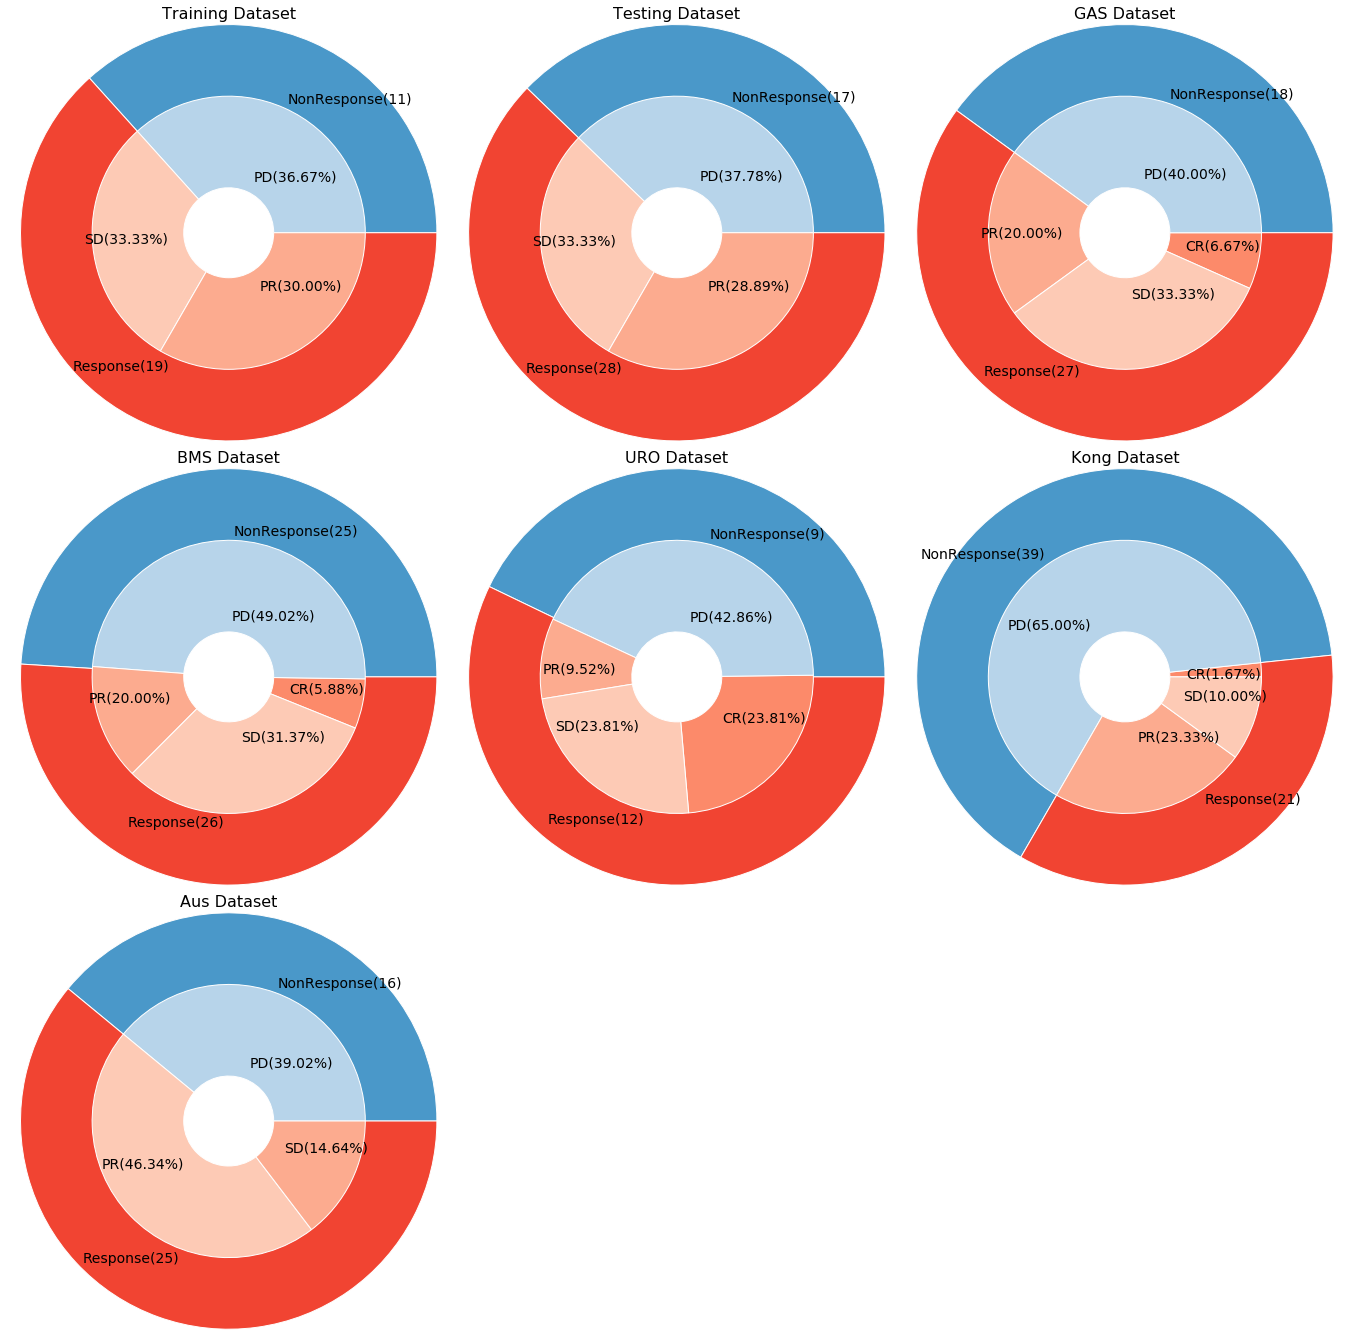

In [26]:
import matplotlib.pyplot as plt
fig=plt.figure(num=None, figsize=(24, 24))
#fig,axs = plt.subplots(3,3,figsize=(24, 24))
grid = plt.GridSpec(24, 24, wspace=0.1, hspace=1)
t1=plt.subplot(grid[0:8,0:8])
t2=plt.subplot(grid[0:8,8:16])
t3=plt.subplot(grid[0:8,16:24])
t4=plt.subplot(grid[8:16,0:8])
t5=plt.subplot(grid[8:16,8:16])
t6=plt.subplot(grid[8:16,16:24])
t7=plt.subplot(grid[16:24,0:8])

a, b, c=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens]

group_names=["NonResponse(11)","Response(19)"]
group_size=All_cli.loc[Lung_train_index,].groupby("Blabel").count().Response.tolist()
subgroup_names=["PD(36.67%)","SD(33.33%)","PR(30.00%)"]
subgroup_size=All_cli.loc[Lung_train_index,].groupby("Response").count().Blabel.tolist()
 
# First Ring (outside)
t1.axis('equal')
mypie, _ = t1.pie(group_size, radius=1.25,textprops={'fontsize':14}, labels=group_names, labeldistance=0.7,colors=[a(0.6), b(0.6)] )
plt.setp( mypie, width=0.55, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _  = t1.pie(subgroup_size, radius=1.3-0.48,textprops={'fontsize':14},labels=subgroup_names, labeldistance=0.45, colors=[a(0.3), b(0.2), b(0.3)])
plt.setp( mypie2, width=0.55, edgecolor='white')
plt.margins(0,0)
t1.set_title("Training Dataset",fontsize=16)
##############################################
group_names=["NonResponse(17)","Response(28)"]
group_size=All_cli.loc[Lung_test_index,].groupby("Blabel").count().Response.tolist()
subgroup_names=["PD(37.78%)","SD(33.33%)","PR(28.89%)"]
subgroup_size=All_cli.loc[Lung_test_index,].groupby("Response").count().Blabel.tolist()
 
# First Ring (outside)
t2.axis('equal')
mypie, _ = t2.pie(group_size, radius=1.25,textprops={'fontsize':14}, labels=group_names, labeldistance=0.7,colors=[a(0.6), b(0.6)] )
plt.setp( mypie, width=0.55, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _  = t2.pie(subgroup_size, radius=1.3-0.48,textprops={'fontsize':14},labels=subgroup_names, labeldistance=0.45, colors=[a(0.3), b(0.2), b(0.3)])
plt.setp( mypie2, width=0.55, edgecolor='white')
plt.margins(0,0)
t2.set_title("Testing Dataset",fontsize=16)
##############################################

group_names=["NonResponse(18)","Response(27)"]
group_size=All_cli.loc[GAS_index,].groupby("Blabel").count().Response.tolist()
subgroup_names=["CR(6.67%)","PD(40.00%)","PR(20.00%)","SD(33.33%)"]
subgroup_size=All_cli.loc[GAS_index,].groupby("Response").count().Blabel.tolist()
 
# First Ring (outside)
t3.axis('equal')
mypie, _ = t3.pie(group_size, radius=1.25,textprops={'fontsize':14}, labels=group_names, labeldistance=0.7,colors=[a(0.6), b(0.6)] )
plt.setp( mypie, width=0.55, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _  = t3.pie(subgroup_size,startangle=-24, radius=1.3-0.48,textprops={'fontsize':14},labels=subgroup_names, labeldistance=0.45, colors=[b(0.4),a(0.3),b(0.3),b(0.2)])
plt.setp( mypie2, width=0.55, edgecolor='white')
plt.margins(0,0)
t3.set_title("GAS Dataset",fontsize=16)
##############################################

group_names=["NonResponse(25)","Response(26)"]
group_size=All_cli.loc[BMS_index,].groupby("Blabel").count().Response.tolist()
subgroup_names=["CR(5.88%)","PD(49.02%)","PR(20.00%)","SD(31.37%)"]
subgroup_size=All_cli.loc[BMS_index,].groupby("Response").count().Blabel.tolist()
 
# First Ring (outside)
t4.axis('equal')
mypie, _ = t4.pie(group_size, radius=1.25,textprops={'fontsize':14}, labels=group_names, labeldistance=0.7,colors=[a(0.6), b(0.6)] )
plt.setp( mypie, width=0.55, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _  = t4.pie(subgroup_size,startangle=-22, radius=1.3-0.48,textprops={'fontsize':14},labels=subgroup_names, labeldistance=0.45, colors=[b(0.4),a(0.3),b(0.3),b(0.2)])
plt.setp( mypie2, width=0.55, edgecolor='white')
plt.margins(0,0)
t4.set_title("BMS Dataset",fontsize=16)
##############################################

group_names=["NonResponse(9)","Response(12)"]
group_size=All_cli.loc[URO_index,].groupby("Blabel").count().Response.tolist()
subgroup_names=["CR(23.81%)","PD(42.86%)","PR(9.52%)","SD(23.81%)"]
subgroup_size=All_cli.loc[URO_index,].groupby("Response").count().Blabel.tolist()
 
# First Ring (outside)
t5.axis('equal')
mypie, _ = t5.pie(group_size, radius=1.25,textprops={'fontsize':14}, labels=group_names, labeldistance=0.7,colors=[a(0.6), b(0.6)] )
plt.setp( mypie, width=0.55, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _  = t5.pie(subgroup_size, startangle=-85,radius=1.3-0.48,textprops={'fontsize':14},labels=subgroup_names, labeldistance=0.45, colors=[b(0.4),a(0.3),b(0.3),b(0.2)])
plt.setp( mypie2, width=0.55, edgecolor='white')
plt.margins(0,0)
t5.set_title("URO Dataset",fontsize=16)
##############################################

group_names=["NonResponse(39)","Response(21)"]
group_size=All_cli.loc[Kong_index,].groupby("Blabel").count().Response.tolist()
subgroup_names=["CR(1.67%)","PD(65.00%)","PR(23.33%)","SD(10.00%)"]
subgroup_size=All_cli.loc[Kong_index,].groupby("Response").count().Blabel.tolist()
 
# First Ring (outside)
t6.axis('equal')
mypie, _ = t6.pie(group_size, radius=1.25,textprops={'fontsize':14}, startangle=6,labels=group_names, labeldistance=0.7,colors=[a(0.6), b(0.6)] )
plt.setp( mypie, width=0.55, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _  = t6.pie(subgroup_size,radius=1.3-0.48,textprops={'fontsize':14},labels=subgroup_names, labeldistance=0.45, colors=[b(0.4),a(0.3),b(0.3),b(0.2)])
plt.setp( mypie2, width=0.55, edgecolor='white')
plt.margins(0,0)
t6.set_title("Kong Dataset",fontsize=16)
#plt.subplots_adjust(wspace=0,hspace=0.1)
#plt.show()
##############################################
group_names=["NonResponse(16)","Response(25)"]
group_size=[16,25]
subgroup_names=["PD(39.02%)","PR(46.34%)","SD(14.64%)"]
subgroup_size=[16,19,6]
 
t7.axis('equal')
mypie, _ = t7.pie(group_size, radius=1.25,textprops={'fontsize':14}, labels=group_names, labeldistance=0.7,colors=[a(0.6), b(0.6)] )
plt.setp( mypie, width=0.55, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _  = t7.pie(subgroup_size, radius=1.3-0.48,textprops={'fontsize':14},labels=subgroup_names, labeldistance=0.45, colors=[a(0.3), b(0.2), b(0.3)])
plt.setp( mypie2, width=0.55, edgecolor='white')
plt.margins(0,0)
t7.set_title("Aus Dataset",fontsize=16)

######
plt.subplots_adjust(wspace=0,hspace=0.1)
plt.show()

# Leave One Out

In [18]:
def nested_dict(n, type):
    if n == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: nested_dict(n-1, type))

In [21]:
def Lung_model_loo(All_cli,All_exp_log2,GeneSet):
    
    Lung_train_index,Lung_test_index,train_y,test_y=train_test_split(All_cli[All_cli.DataSet.isin(["Wu1","Batch2"])].index,All_cli[All_cli.DataSet.isin(["Wu1","Batch2"])].Response,stratify=All_cli[All_cli.DataSet.isin(["Wu1","Batch2"])].Response,test_size=45,random_state=65209)
    
    skf = StratifiedKFold(n_splits=3,random_state=65209)
    skf_res=[]
    for t1,t2  in skf.split(Lung_train_index,All_cli.loc[Lung_train_index,"Response"]):
        skf_res.append(Lung_train_index[t1])
    
    GAS_index=All_cli[All_cli.DataSet=="GAS"].index
    BMS_index=All_cli[All_cli.DataSet=="BMS"].index
    HUGO_index=All_cli[All_cli.DataSet=="HUGO"].index
    URO_index=All_cli[All_cli.DataSet=="URO"].index

    Pan_train_index=Lung_train_index.append(GAS_index).append(BMS_index).append(URO_index)
    NonLung_index=GAS_index.append(BMS_index).append(URO_index)
    
    loo_res=nested_dict(2,list)
    
    Lung_split1_index_o,Lung_split2_index_o,Lung_split3_index_o=skf_res
    print(All_cli.loc[Lung_split1_index_o,:].groupby("Response").count())
    print(All_cli.loc[Lung_split2_index_o,:].groupby("Response").count())
    print(All_cli.loc[Lung_split3_index_o,:].groupby("Response").count())
    for LeaveOut in Lung_train_index:
        Lung_split1_index=Lung_split1_index_o[Lung_split1_index_o!=LeaveOut].copy()
        Lung_split2_index=Lung_split2_index_o[Lung_split2_index_o!=LeaveOut].copy()
        Lung_split3_index=Lung_split3_index_o[Lung_split3_index_o!=LeaveOut].copy()
    
        for gg in GeneSet:
        
            Cgeneset=set(Msigdb[gg])&set(All_exp_log2.columns)
    
            Cgeneset_Norm=All_exp_log2.loc[:,Cgeneset].T.apply(zscore).T.dropna(axis=1)
            Cgeneset=Cgeneset&set(Cgeneset_Norm.columns)
    
            CC=pd.concat([Cgeneset_Norm.loc[Lung_test_index,:].apply(lambda x:roc_auc_score(All_cli.loc[Lung_test_index,"Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[Lung_train_index,:].apply(lambda x:roc_auc_score(All_cli.loc[Lung_train_index,"Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[Lung_split1_index,:].apply(lambda x:roc_auc_score(All_cli.loc[Lung_split1_index,"Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[Lung_split2_index,:].apply(lambda x:roc_auc_score(All_cli.loc[Lung_split2_index,"Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[Lung_split3_index,:].apply(lambda x:roc_auc_score(All_cli.loc[Lung_split3_index,"Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[GAS_index,:].apply(lambda x:roc_auc_score(All_cli.loc[All_cli.DataSet=="GAS","Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[BMS_index,:].apply(lambda x:roc_auc_score(All_cli.loc[All_cli.DataSet=="BMS","Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[URO_index,:].apply(lambda x:roc_auc_score(All_cli.loc[All_cli.DataSet=="URO","Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[NonLung_index,:].apply(lambda x:roc_auc_score(All_cli.loc[NonLung_index,"Blabel"],x),axis=0),
                               ],
                               keys=["Test","Train","Split1","Split2","Split3","GAS","BMS","URO","Nonlung"],axis=1,sort=True)
            
            CC["auc_lung_min"]=CC.loc[:,["Train","Split1","Split2","Split3"]].min(axis=1)
            CC["auc_lung_max"]=CC.loc[:,["Train","Split1","Split2","Split3"]].max(axis=1)
            CC["auc_lung_cv"]=CC["auc_lung_max"]-CC["auc_lung_min"]
            CC["auc_lung_median"]=CC.loc[:,["Train","Split1","Split2","Split3"]].median(axis=1)
                
            CC["auc_nonlung_median"]=CC.loc[:,["Nonlung","URO","GAS","BMS"]].median(axis=1)
            CC["auc_nonlung_min"]=CC.loc[:,["Nonlung","URO","GAS","BMS"]].min(axis=1)
            CC["auc_nonlung_max"]=CC.loc[:,["Nonlung","URO","GAS","BMS"]].max(axis=1)
            CC["auc_nonlung_cv"]=CC["auc_nonlung_max"]-CC["auc_nonlung_min"]
        

            #####Fix_f 
            Fix_f=(CC["auc_nonlung_min"].append(1-CC["auc_nonlung_max"])).sort_values(ascending=False).index.tolist()[:3]
            
            ######Lung_prefer_f
            Tmp=CC.sort_values("auc_lung_median",ascending=False).head(n=10)
            Tmp_up=Tmp[(Tmp.auc_lung_median>0.55)&(Tmp.auc_lung_min>0.45)&(Tmp.auc_lung_cv<0.15)&(Tmp.auc_nonlung_median>0.5)&(Tmp.auc_nonlung_cv<0.2)&(Tmp.auc_nonlung_min>0.45)].auc_lung_median
    
            Tmp=CC.sort_values("auc_lung_median").head(n=10)
            Tmp_down=Tmp[(Tmp.auc_lung_median<0.45)&(Tmp.auc_lung_max<0.55)&(Tmp.auc_lung_cv<0.15)&(Tmp.auc_nonlung_median<0.5)&(Tmp.auc_nonlung_cv<0.2)&(Tmp.auc_nonlung_max<0.55)].auc_lung_median
            
            ######Combo prefer_f
            F_select=set((Tmp_up.append(1-Tmp_down)).sort_values(ascending=False).index.tolist()[:5]+Fix_f)
            feature_res=[]
    
            print(gg,F_select)
            if(len(F_select)!=0):
            
                Test_DScomb_res=pd.DataFrame()
                Train_DScomb_res=pd.DataFrame()
                
                #####URO pred
                F_select_URO=(0.5-CC.loc[F_select,"URO"])*(0.5-CC.loc[F_select,"Train"])
                F_select_URO=F_select_URO[F_select_URO>=0].index
                if(len(F_select_URO)!=0):
                    URO_model=LogisticRegressionCV(random_state=3,cv=3,max_iter=3000).fit(Cgeneset_Norm.loc[URO_index,F_select_URO],All_cli.loc[URO_index,"Blabel"])
                    tmp=URO_model.predict_proba(Cgeneset_Norm.loc[LeaveOut,F_select_URO].values.reshape(1,-1))[:,1][0]
                    #print(tmp)
                    loo_res[LeaveOut][gg].append(tmp)
                
                    
                #####BMS pred    
                F_select_BMS=(0.5-CC.loc[F_select,"BMS"])*(0.5-CC.loc[F_select,"Train"])
                F_select_BMS=F_select_BMS[F_select_BMS>=0].index
    
                if(len(F_select_BMS)!=0):
                    BMS_model=LogisticRegressionCV(random_state=3,cv=3,max_iter=3000).fit(Cgeneset_Norm.loc[BMS_index,F_select_BMS],All_cli.loc[BMS_index,"Blabel"])
                    tmp=BMS_model.predict_proba(Cgeneset_Norm.loc[LeaveOut,F_select_BMS].values.reshape(1,-1))[:,1][0]
                    loo_res[LeaveOut][gg].append(tmp)
                    
                #####GAS pred
                F_select_GAS=(0.5-CC.loc[F_select,"GAS"])*(0.5-CC.loc[F_select,"Train"])
                F_select_GAS=F_select_GAS[F_select_GAS>=0].index
    
                if(len(F_select_GAS)!=0):
                    GAS_model=LogisticRegressionCV(random_state=3,cv=3,max_iter=3000).fit(Cgeneset_Norm.loc[GAS_index,F_select_GAS],All_cli.loc[GAS_index,"Blabel"])
                    tmp=GAS_model.predict_proba(Cgeneset_Norm.loc[LeaveOut,F_select_GAS].values.reshape(1,-1))[:,1][0]
                    loo_res[LeaveOut][gg].append(tmp)
                    
                #####Lung pred
                Lung_model=LogisticRegressionCV(random_state=3,cv=3,max_iter=3000).fit(Cgeneset_Norm.loc[Lung_train_index,F_select],All_cli.loc[Lung_train_index,"Blabel"]) 
                tmp=Lung_model.predict_proba(Cgeneset_Norm.loc[LeaveOut,F_select].values.reshape(1,-1))[:,1][0]
                loo_res[LeaveOut][gg].append(tmp)
                    
    return(loo_res)

In [22]:
loo_res2P=Lung_model_loo(All_cli,All_exp_log2,GeneSet)

          Blabel  DataSet
Response                 
PD             7        7
PR             6        6
SD             6        6
          Blabel  DataSet
Response                 
PD             7        7
PR             6        6
SD             7        7
          Blabel  DataSet
Response                 
PD             8        8
PR             6        6
SD             7        7
ECM {'TIMP1', 'ACAN', 'SULF1', 'MMP1'}
Key {'TNFRSF17', 'CCR5', 'PRF1', 'HLA-DPB1', 'IL6', 'CD276', 'CD80', 'CD8A'}
BIOCARTA_PTEN_PATHWAY {'PDPK1', 'PIK3CA', 'GRB2'}
ZhouS {'PRF1', 'HIF1A', 'ICOS', 'BACH2', 'IL2RB'}
Macrophages_M2 {'FCER2', 'IL6', 'CXCL9'}
KEGG_NON_SMALL_CELL_LUNG_CANCER {'NRAS', 'STK4', 'CCND1', 'ARAF'}
ECM {'TIMP1', 'ACAN', 'SULF1', 'MMP1'}
Key {'BTLA', 'CCR5', 'PRF1', 'HLA-DPB1', 'IL6', 'CD276', 'CD80', 'CD8A'}
BIOCARTA_PTEN_PATHWAY {'PDPK1', 'PIK3CA', 'GRB2'}
ZhouS {'PRF1', 'HIF1A', 'ICOS', 'EOMES', 'BACH2', 'IL2RB'}
Macrophages_M2 {'FCER2', 'IL6', 'CXCL9'}
KEGG_NON_SMALL_CELL_LUNG_

Macrophages_M2 {'FCER2', 'IL6', 'CXCL9'}
KEGG_NON_SMALL_CELL_LUNG_CANCER {'NRAS', 'CCND1', 'ARAF'}
ECM {'TIMP1', 'ACAN', 'SULF1', 'MMP1'}
Key {'TNFRSF17', 'CCR5', 'PRF1', 'HLA-DPB1', 'IL6', 'CD276', 'CD80', 'CD8A'}
BIOCARTA_PTEN_PATHWAY {'PDPK1', 'PIK3CA', 'GRB2'}
ZhouS {'PRF1', 'HIF1A', 'ICOS', 'BACH2', 'IL2RB'}
Macrophages_M2 {'FCER2', 'IL6', 'CXCL9'}
KEGG_NON_SMALL_CELL_LUNG_CANCER {'NRAS', 'STK4', 'CCND1', 'ARAF'}
ECM {'TIMP1', 'ACAN', 'SULF1', 'MMP1'}
Key {'TNFRSF17', 'PRF1', 'IL6', 'HLA-DPB1', 'CD276', 'CD80', 'CD8A'}
BIOCARTA_PTEN_PATHWAY {'PDPK1', 'PIK3CA', 'GRB2'}
ZhouS {'PRF1', 'HIF1A', 'ICOS', 'EOMES', 'BACH2', 'IL2RB'}
Macrophages_M2 {'FCER2', 'IL6', 'CXCL9'}
KEGG_NON_SMALL_CELL_LUNG_CANCER {'NRAS', 'CCND1', 'ARAF', 'STK4', 'PDPK1'}
ECM {'TIMP1', 'ACAN', 'SULF1', 'MMP1'}
Key {'CCR5', 'PRF1', 'IL6', 'HLA-DPB1', 'CD276', 'CD80', 'CD8A'}
BIOCARTA_PTEN_PATHWAY {'PDPK1', 'PIK3CA', 'GRB2'}
ZhouS {'IL2RB', 'PRF1', 'HIF1A', 'ICOS'}
Macrophages_M2 {'FCER2', 'IL6', 'CXCL9'}
KEGG_NON_

In [23]:
loo_res2P=pd.DataFrame(loo_res2P)

loo_res2_PTEN=pd.DataFrame([loo_res2P.loc["BIOCARTA_PTEN_PATHWAY",i] for i in loo_res2P.columns],index=loo_res2P.columns).rank().median(axis=1)
loo_res2_ECM=pd.DataFrame([loo_res2P.loc["ECM",i] for i in loo_res2P.columns],index=loo_res2P.columns).rank().median(axis=1)
loo_res2_NSCL=pd.DataFrame([loo_res2P.loc["KEGG_NON_SMALL_CELL_LUNG_CANCER",i] for i in loo_res2P.columns],index=loo_res2P.columns).rank().median(axis=1)
loo_res2_Key=pd.DataFrame([loo_res2P.loc["Key",i] for i in loo_res2P.columns],index=loo_res2P.columns).rank().median(axis=1)
loo_res2_M2=pd.DataFrame([loo_res2P.loc["Macrophages_M2",i] for i in loo_res2P.columns],index=loo_res2P.columns).rank().median(axis=1)
loo_res2_ZhouS=pd.DataFrame([loo_res2P.loc["ZhouS",i] for i in loo_res2P.columns],index=loo_res2P.columns).rank().median(axis=1)

loo_res2P_rank=pd.concat([loo_res2_PTEN,loo_res2_ECM,loo_res2_NSCL,loo_res2_Key,loo_res2_M2,loo_res2_ZhouS],axis=1).mean(axis=1)
roc_auc_score(All_cli.loc[loo_res2P_rank.index,"Blabel"],loo_res2P_rank)

0.8253588516746411

In [27]:
import numpy as np
from scipy.stats import sem
from sklearn.metrics import roc_auc_score

def AUC_CI(y_pred,y_true):
    n_bootstraps = 1000
    rng_seed = 42  # control reproducibility
    bootstrapped_scores = []

    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred) - 1, len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
            continue

        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
        
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    
    return([confidence_lower,confidence_upper])

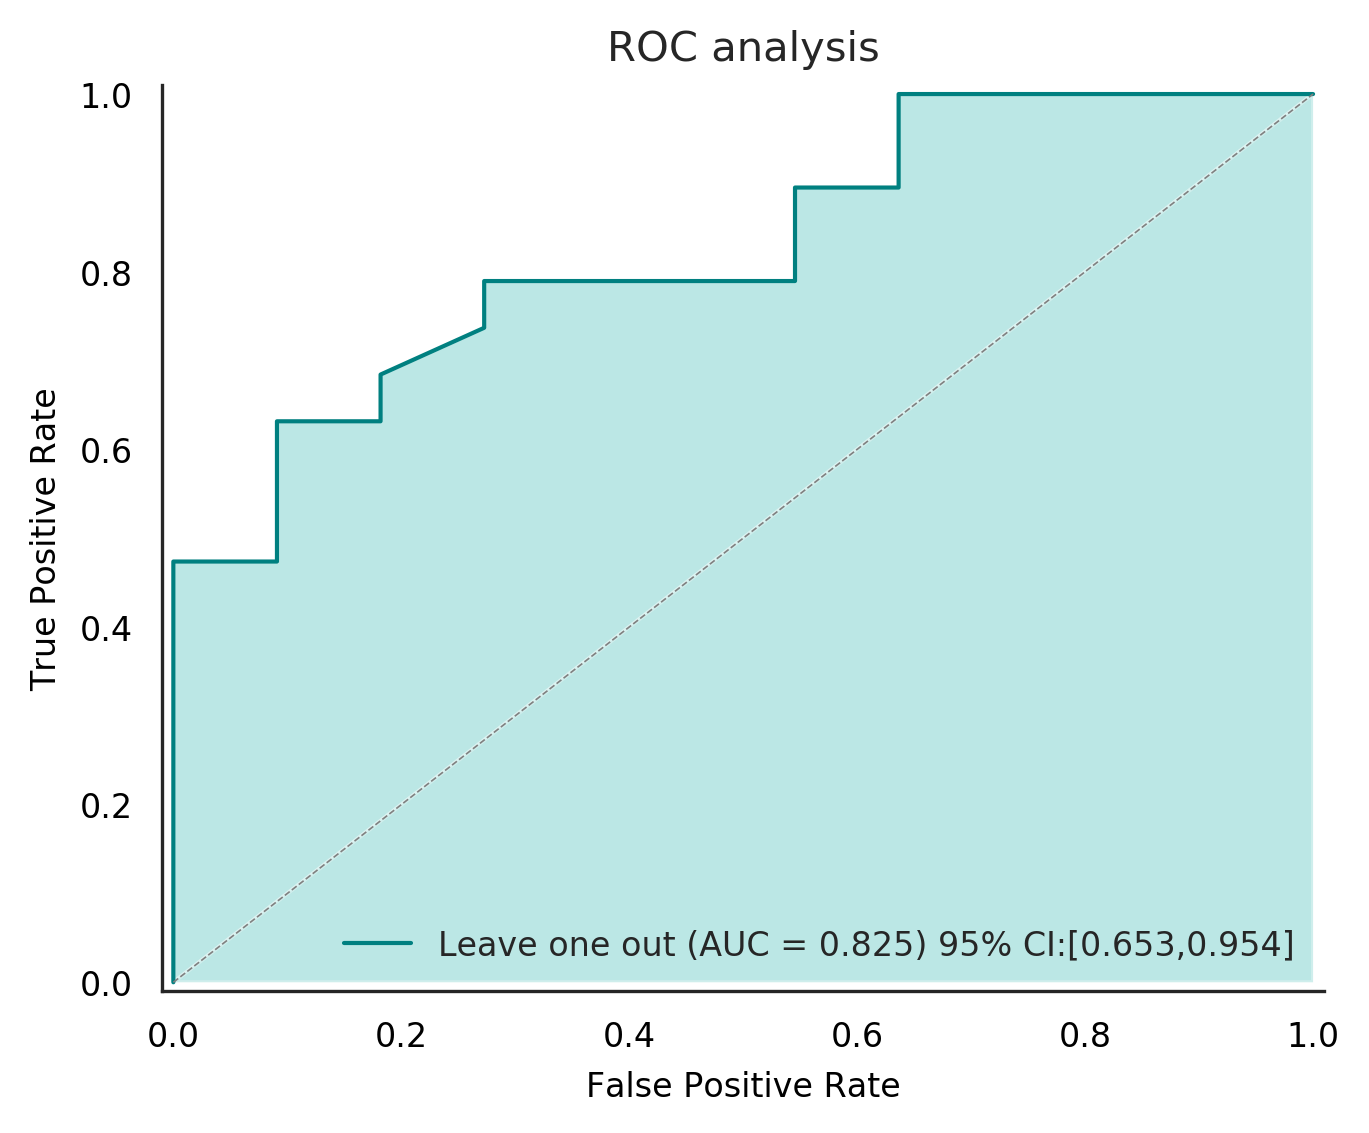

In [334]:
LOO_AUC_CI=AUC_CI(loo_res2P_rank,All_cli.loc[loo_res2P_rank.index,"Blabel"])

fig,ax = plt.subplots(figsize=(5,4),dpi=300)
colors=['teal']
linestypes=['-']
labels = ['Leave one out']
Pred = [loo_res2P_rank]
CI=[LOO_AUC_CI]
Blabels=[All_cli.loc[loo_res2P_rank.index,"Blabel"]]
for p,b,lab,col,ls,ci in zip(Pred,Blabels,labels,colors,linestypes,CI):
    fpr,tpr,thresholds = roc_curve(y_true= b,y_score=p)
    roc_auc = auc(x=fpr,y=tpr)
    ax.plot(fpr,tpr,color=col,linestyle=ls,label='%s (AUC = %0.3f) 95%% CI:[%0.3f,%0.3f]'%(lab, roc_auc,ci[0],ci[1]),linewidth=1)
    ax.fill(fpr,tpr, 'lightseagreen', alpha=0.3)#skyblue
    ax.fill([0,1,1],[0,1,0],'lightseagreen',alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
            
    ax.legend(loc='lower right',fontsize=8,frameon=False)
    
ax.plot([0,1],[0,1],linestyle='--',color='gray',linewidth=0.4)
plt.xlim([-0.01,1.01])
plt.xticks(fontsize=8,color='black')
plt.yticks(fontsize=8,color='black')
plt.ylim([-0.01,1.01])
 
plt.xlabel('False Positive Rate',fontsize=8,color='black')
plt.ylabel('True Positive Rate',fontsize=8,color='black')
plt.title('ROC analysis',fontsize=10)
plt.show()

## Parameter selection

In [32]:
def Lung_model_para(All_cli,All_exp_log2,GeneSet,Lung_top,Pan_top):
    
    Lung_train_index,Lung_test_index,train_y,test_y=train_test_split(All_cli[All_cli.DataSet.isin(["Wu1","Batch2"])].index,All_cli[All_cli.DataSet.isin(["Wu1","Batch2"])].Response,stratify=All_cli[All_cli.DataSet.isin(["Wu1","Batch2"])].Response,test_size=45,random_state=65209)
    
    skf = StratifiedKFold(n_splits=3,random_state=65209)
    skf_res=[]
    for t1,t2  in skf.split(Lung_train_index,All_cli.loc[Lung_train_index,"Response"]):
        skf_res.append(Lung_train_index[t1])
    
    Lung_split1_index,Lung_split2_index,Lung_split3_index=skf_res

    GAS_index=All_cli[All_cli.DataSet=="GAS"].index
    BMS_index=All_cli[All_cli.DataSet=="BMS"].index
    HUGO_index=All_cli[All_cli.DataSet=="HUGO"].index
    URO_index=All_cli[All_cli.DataSet=="URO"].index
    Zhou_index=All_cli[All_cli.DataSet=="Zhou"].index
    Wu_zb1_index=All_cli[All_cli.DataSet=="Wu_zb1"].index
    
    Pan_train_index=Lung_train_index.append(GAS_index).append(BMS_index).append(URO_index)
    NonLung_index=GAS_index.append(BMS_index).append(URO_index)
    
    test_res=pd.DataFrame()
    train_res=pd.DataFrame()
    GAS_res=pd.DataFrame()
    BMS_res=pd.DataFrame()
    URO_res=pd.DataFrame() 
    test_comb_res=[]
    feature_comb_res=[]
    other_res=[]
    zhou_res=pd.DataFrame()
    wu_zb1_res=pd.DataFrame()
    
    for gg in GeneSet:
    
        Cgeneset=set(Msigdb[gg])&set(All_exp_log2.columns)

        Cgeneset_Norm=All_exp_log2.loc[:,Cgeneset].T.apply(zscore).T.dropna(axis=1)
        Cgeneset=Cgeneset&set(Cgeneset_Norm.columns)

        CC=pd.concat([Cgeneset_Norm.loc[Lung_test_index,:].apply(lambda x:roc_auc_score(All_cli.loc[Lung_test_index,"Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[Lung_train_index,:].apply(lambda x:roc_auc_score(All_cli.loc[Lung_train_index,"Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[Lung_split1_index,:].apply(lambda x:roc_auc_score(All_cli.loc[Lung_split1_index,"Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[Lung_split2_index,:].apply(lambda x:roc_auc_score(All_cli.loc[Lung_split2_index,"Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[Lung_split3_index,:].apply(lambda x:roc_auc_score(All_cli.loc[Lung_split3_index,"Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[GAS_index,:].apply(lambda x:roc_auc_score(All_cli.loc[All_cli.DataSet=="GAS","Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[BMS_index,:].apply(lambda x:roc_auc_score(All_cli.loc[All_cli.DataSet=="BMS","Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[URO_index,:].apply(lambda x:roc_auc_score(All_cli.loc[All_cli.DataSet=="URO","Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[NonLung_index,:].apply(lambda x:roc_auc_score(All_cli.loc[NonLung_index,"Blabel"],x),axis=0),
                               ],
                               keys=["Test","Train","Split1","Split2","Split3","GAS","BMS","URO","Nonlung"],axis=1,sort=True)
            
        CC["auc_lung_min"]=CC.loc[:,["Train","Split1","Split2","Split3"]].min(axis=1)
        CC["auc_lung_max"]=CC.loc[:,["Train","Split1","Split2","Split3"]].max(axis=1)
        CC["auc_lung_cv"]=CC["auc_lung_max"]-CC["auc_lung_min"]
        CC["auc_lung_median"]=CC.loc[:,["Train","Split1","Split2","Split3"]].median(axis=1)
            
        CC["auc_nonlung_median"]=CC.loc[:,["Nonlung","URO","GAS","BMS"]].median(axis=1)
        CC["auc_nonlung_min"]=CC.loc[:,["Nonlung","URO","GAS","BMS"]].min(axis=1)
        CC["auc_nonlung_max"]=CC.loc[:,["Nonlung","URO","GAS","BMS"]].max(axis=1)
        CC["auc_nonlung_cv"]=CC["auc_nonlung_max"]-CC["auc_nonlung_min"]
        

        #####Fix_f 
        Fix_f=(CC["auc_nonlung_min"].append(1-CC["auc_nonlung_max"])).sort_values(ascending=False).index.tolist()[:Pan_top]
        
        ######Lung_prefer_f
        Tmp=CC.sort_values("auc_lung_median",ascending=False).head(n=10)
        Tmp_up=Tmp[(Tmp.auc_lung_median>0.55)&(Tmp.auc_lung_min>0.45)&(Tmp.auc_lung_cv<0.15)&(Tmp.auc_nonlung_median>0.5)&(Tmp.auc_nonlung_cv<0.2)&(Tmp.auc_nonlung_min>0.45)].auc_lung_median

        Tmp=CC.sort_values("auc_lung_median").head(n=10)
        Tmp_down=Tmp[(Tmp.auc_lung_median<0.45)&(Tmp.auc_lung_max<0.55)&(Tmp.auc_lung_cv<0.15)&(Tmp.auc_nonlung_median<0.5)&(Tmp.auc_nonlung_cv<0.2)&(Tmp.auc_nonlung_max<0.55)].auc_lung_median
        
        ######Combo prefer_f
        F_select=set((Tmp_up.append(1-Tmp_down)).sort_values(ascending=False).index.tolist()[:Lung_top]+Fix_f)
        feature_res=[]

        print(gg,F_select)
        if(len(F_select)!=0):
        
            Test_DScomb_res=pd.DataFrame()
            Train_DScomb_res=pd.DataFrame()
            Zhou_DScomb_res=pd.DataFrame()
            Wu_zb1_DScomb_res=pd.DataFrame()
            
            #####URO pred
            F_select_URO=(0.5-CC.loc[F_select,"URO"])*(0.5-CC.loc[F_select,"Train"])
            F_select_URO=F_select_URO[F_select_URO>=0].index
            if(len(F_select_URO)!=0):
                URO_model=LogisticRegressionCV(random_state=3,cv=3,max_iter=3000).fit(Cgeneset_Norm.loc[URO_index,F_select_URO],All_cli.loc[URO_index,"Blabel"])
                Test_DScomb_res["URO_model"]=URO_model.predict_proba(Cgeneset_Norm.loc[Lung_test_index,F_select_URO])[:,1]
                Train_DScomb_res["URO_model"]=URO_model.predict_proba(Cgeneset_Norm.loc[Lung_train_index,F_select_URO])[:,1]
                Zhou_DScomb_res["URO_model"]=URO_model.predict_proba(Cgeneset_Norm.loc[Zhou_index,F_select_URO])[:,1]
                Wu_zb1_DScomb_res["URO_model"]=URO_model.predict_proba(Cgeneset_Norm.loc[Wu_zb1_index,F_select_URO])[:,1]
                
                URO_res[gg]=URO_model.predict_proba(Cgeneset_Norm.loc[URO_index,F_select_URO])[:,1]
                feature_res.append(roc_auc_score(All_cli.loc[Lung_test_index,"Blabel"],Test_DScomb_res["URO_model"]))   
                
            #####BMS pred    
            F_select_BMS=(0.5-CC.loc[F_select,"BMS"])*(0.5-CC.loc[F_select,"Train"])
            F_select_BMS=F_select_BMS[F_select_BMS>=0].index

            if(len(F_select_BMS)!=0):
                BMS_model=LogisticRegressionCV(random_state=3,cv=3,max_iter=3000).fit(Cgeneset_Norm.loc[BMS_index,F_select_BMS],All_cli.loc[BMS_index,"Blabel"])
                Test_DScomb_res["BMS_model"]=BMS_model.predict_proba(Cgeneset_Norm.loc[Lung_test_index,F_select_BMS])[:,1]
                Train_DScomb_res["BMS_model"]=BMS_model.predict_proba(Cgeneset_Norm.loc[Lung_train_index,F_select_BMS])[:,1]
                Zhou_DScomb_res["BMS_model"]=BMS_model.predict_proba(Cgeneset_Norm.loc[Zhou_index,F_select_BMS])[:,1]
                Wu_zb1_DScomb_res["BMS_model"]=BMS_model.predict_proba(Cgeneset_Norm.loc[Wu_zb1_index,F_select_BMS])[:,1]
                
                BMS_res[gg]=BMS_model.predict_proba(Cgeneset_Norm.loc[BMS_index,F_select_BMS])[:,1]
                feature_res.append(roc_auc_score(All_cli.loc[Lung_test_index,"Blabel"],Test_DScomb_res["BMS_model"]))
            
            #####GAS pred
            F_select_GAS=(0.5-CC.loc[F_select,"GAS"])*(0.5-CC.loc[F_select,"Train"])
            F_select_GAS=F_select_GAS[F_select_GAS>=0].index

            if(len(F_select_GAS)!=0):
                GAS_model=LogisticRegressionCV(random_state=3,cv=3,max_iter=3000).fit(Cgeneset_Norm.loc[GAS_index,F_select_GAS],All_cli.loc[GAS_index,"Blabel"])
                Test_DScomb_res["GAS_model"]=GAS_model.predict_proba(Cgeneset_Norm.loc[Lung_test_index,F_select_GAS])[:,1]
                Train_DScomb_res["GAS_model"]=GAS_model.predict_proba(Cgeneset_Norm.loc[Lung_train_index,F_select_GAS])[:,1]
                Zhou_DScomb_res["GAS_model"]=GAS_model.predict_proba(Cgeneset_Norm.loc[Zhou_index,F_select_GAS])[:,1]
                Wu_zb1_DScomb_res["GAS_model"]=GAS_model.predict_proba(Cgeneset_Norm.loc[Wu_zb1_index,F_select_GAS])[:,1]
                
                GAS_res[gg]=GAS_model.predict_proba(Cgeneset_Norm.loc[GAS_index,F_select_GAS])[:,1]
                feature_res.append(roc_auc_score(All_cli.loc[Lung_test_index,"Blabel"],Test_DScomb_res["GAS_model"]))
            
            #####Lung pred
            Lung_model=LogisticRegressionCV(random_state=3,cv=3,max_iter=3000).fit(Cgeneset_Norm.loc[Lung_train_index,F_select],All_cli.loc[Lung_train_index,"Blabel"]) 
            Test_DScomb_res["Lung_model"]=Lung_model.predict_proba(Cgeneset_Norm.loc[Lung_test_index,F_select])[:,1]
            Train_DScomb_res["Lung_model"]=Lung_model.predict_proba(Cgeneset_Norm.loc[Lung_train_index,F_select])[:,1]
            Zhou_DScomb_res["Lung_model"]=Lung_model.predict_proba(Cgeneset_Norm.loc[Zhou_index,F_select])[:,1]
            Wu_zb1_DScomb_res["Lung_model"]=Lung_model.predict_proba(Cgeneset_Norm.loc[Wu_zb1_index,F_select])[:,1]
            
            feature_res.append(roc_auc_score(All_cli.loc[Lung_test_index,"Blabel"],Test_DScomb_res["Lung_model"]))
            
            train_res[gg]=Train_DScomb_res.rank().median(axis=1)
            test_res[gg]=Test_DScomb_res.rank().median(axis=1)
            zhou_res[gg]=Zhou_DScomb_res.rank().median(axis=1)
            wu_zb1_res[gg]=Wu_zb1_DScomb_res.rank().median(axis=1)
            feature_comb_res.append(np.array(feature_res).mean())
                        
    test_res.index=Lung_test_index
    train_res.index=Lung_train_index
    zhou_res.index=Zhou_index
    wu_zb1_res.index=Wu_zb1_index
    
    GAS_res.index=GAS_index
    URO_res.index=URO_index
    BMS_res.index=BMS_index
     
    other_res.append(roc_auc_score(All_cli.loc[test_res.index,"Blabel"],test_res.rank().mean(axis=1)))
    other_res.append(roc_auc_score(All_cli.loc[train_res.index,"Blabel"],train_res.rank().mean(axis=1)))
    other_res.append(roc_auc_score(All_cli.loc[GAS_res.index,"Blabel"],GAS_res.rank().mean(axis=1)))
    other_res.append(roc_auc_score(All_cli.loc[URO_res.index,"Blabel"],URO_res.rank().mean(axis=1)))
    other_res.append(roc_auc_score(All_cli.loc[BMS_res.index,"Blabel"],BMS_res.rank().mean(axis=1)))
    #other_res.append(roc_auc_score(All_cli.loc[zhou_res.index,"Blabel"],zhou_res.rank().mean(axis=1)))
    #other_res.append(roc_auc_score(All_cli.loc[wu_zb1_res.index,"Blabel"],wu_zb1_res.rank().mean(axis=1)))
    #test_comb_res.append(roc_auc_score(All_cli.loc[test_res.index,"Blabel"],test_res.rank().mean(axis=1)))
      
    return(other_res)

In [34]:
Para_res=defaultdict(list)
for Lung_top in range(1,10):
    for Pan_top in range(1,10):
        Para_res[str(Lung_top)+"#"+str(Pan_top)]=Lung_model_para(All_cli,All_exp_log2,GeneSet,Lung_top,Pan_top)

ECM {'ACAN', 'SULF1'}
Key {'PRF1', 'IL6'}
BIOCARTA_PTEN_PATHWAY {'PDPK1', 'PIK3CA'}
ZhouS {'IL2RB', 'PRF1'}
Macrophages_M2 {'IL6'}
KEGG_NON_SMALL_CELL_LUNG_CANCER {'PDPK1', 'CCND1'}
ECM {'ACAN', 'SULF1', 'MMP1'}
Key {'PRF1', 'IL6', 'CD276'}
BIOCARTA_PTEN_PATHWAY {'PDPK1', 'PIK3CA'}
ZhouS {'IL2RB', 'PRF1', 'HIF1A'}
Macrophages_M2 {'IL6', 'CXCL9'}
KEGG_NON_SMALL_CELL_LUNG_CANCER {'PDPK1', 'CCND1', 'ARAF'}
ECM {'TIMP1', 'ACAN', 'SULF1', 'MMP1'}
Key {'CD80', 'PRF1', 'IL6', 'CD276'}
BIOCARTA_PTEN_PATHWAY {'PDPK1', 'PIK3CA', 'GRB2'}
ZhouS {'IL2RB', 'PRF1', 'HIF1A', 'ICOS'}
Macrophages_M2 {'FCER2', 'IL6', 'CXCL9'}
KEGG_NON_SMALL_CELL_LUNG_CANCER {'NRAS', 'PDPK1', 'CCND1', 'ARAF'}
ECM {'TIMP1', 'ACAN', 'MMP1', 'TGFB1', 'SULF1'}
Key {'PRF1', 'IL6', 'CD276', 'CD80', 'IL10'}
BIOCARTA_PTEN_PATHWAY {'MAPK3', 'PDPK1', 'PIK3CA', 'GRB2'}
ZhouS {'LAG3', 'PRF1', 'HIF1A', 'ICOS', 'IL2RB'}
Macrophages_M2 {'FCER2', 'CXCL11', 'IL6', 'CXCL9'}
KEGG_NON_SMALL_CELL_LUNG_CANCER {'NRAS', 'CDK4', 'CCND1', 'ARAF', 

BIOCARTA_PTEN_PATHWAY {'MAPK3', 'PIK3CA', 'GRB2', 'ITGB1', 'PDPK1'}
ZhouS {'LAG3', 'PRF1', 'HIF1A', 'ICOS', 'EOMES', 'BACH2', 'IL2', 'IL2RB'}
Macrophages_M2 {'CXCL9', 'FCER2', 'CXCL11', 'IL6', 'CXCL10'}
KEGG_NON_SMALL_CELL_LUNG_CANCER {'NRAS', 'PRKCA', 'CDK4', 'CCND1', 'ARAF', 'PDPK1'}
ECM {'TIMP1', 'ACAN', 'MMP1', 'TGFB1', 'SULF1', 'SPP1', 'COMP'}
Key {'NKG7', 'TGFB1', 'PRF1', 'IL6', 'HLA-DPB1', 'CD276', 'CD80', 'IL10', 'CD8A'}
BIOCARTA_PTEN_PATHWAY {'MAPK3', 'PIK3CA', 'GRB2', 'ITGB1', 'PDPK1', 'BCAR1'}
ZhouS {'LAG3', 'PRF1', 'HIF1A', 'ICOS', 'EOMES', 'BACH2', 'IL2', 'IL2RB', 'NFKB1'}
Macrophages_M2 {'CXCL9', 'FCER2', 'CXCL11', 'IL6', 'CXCL10', 'IL1B'}
KEGG_NON_SMALL_CELL_LUNG_CANCER {'NRAS', 'PRKCA', 'CDK4', 'MAP2K1', 'CCND1', 'ARAF', 'PDPK1'}
ECM {'TIMP1', 'ACAN', 'MMP1', 'TGFB1', 'SULF1', 'SPP1', 'COMP', 'COL5A3'}
Key {'NKG7', 'CD27', 'TGFB1', 'PRF1', 'IL6', 'HLA-DPB1', 'CD276', 'CD80', 'IL10', 'CD8A'}
BIOCARTA_PTEN_PATHWAY {'MAPK3', 'SHC1', 'PIK3CA', 'GRB2', 'ITGB1', 'PDPK1', 'BCA

BIOCARTA_PTEN_PATHWAY {'MAPK3', 'PIK3CA', 'GRB2', 'ITGB1', 'PDPK1', 'BCAR1'}
ZhouS {'LAG3', 'PRF1', 'HIF1A', 'ICOS', 'EOMES', 'BACH2', 'IL2', 'IL2RB', 'NFKB1'}
Macrophages_M2 {'CXCL9', 'FCER2', 'CXCL11', 'IL6', 'CXCL10', 'IL1B'}
KEGG_NON_SMALL_CELL_LUNG_CANCER {'NRAS', 'PRKCA', 'CDK4', 'MAP2K1', 'CCND1', 'ARAF', 'STK4', 'PDPK1'}
ECM {'TIMP1', 'ACAN', 'MMP1', 'TGFB1', 'SULF1', 'SPP1', 'COMP', 'COL5A3'}
Key {'TNFRSF17', 'NKG7', 'CD27', 'CCR5', 'TGFB1', 'PRF1', 'HLA-DPB1', 'IL6', 'CD276', 'CD80', 'IL10', 'CD8A'}
BIOCARTA_PTEN_PATHWAY {'MAPK3', 'SHC1', 'PIK3CA', 'GRB2', 'ITGB1', 'PDPK1', 'BCAR1'}
ZhouS {'LAG3', 'PRF1', 'HIF1A', 'ICOS', 'EOMES', 'BACH2', 'IL2', 'PRDM1', 'IL2RB', 'NFKB1'}
Macrophages_M2 {'CCL17', 'CXCL9', 'FCER2', 'CXCL11', 'IL6', 'CXCL10', 'IL1B'}
KEGG_NON_SMALL_CELL_LUNG_CANCER {'NRAS', 'PRKCA', 'CDK4', 'AKT1', 'MAP2K1', 'CCND1', 'ARAF', 'STK4', 'PDPK1'}
ECM {'TIMP1', 'ACAN', 'MMP1', 'TGFB1', 'SULF1', 'SPP1', 'MMP9', 'COMP', 'COL5A3'}
Key {'TNFRSF17', 'NKG7', 'CD27', 'CCR5

KEGG_NON_SMALL_CELL_LUNG_CANCER {'NRAS', 'PRKCA', 'CDK4', 'MAP2K1', 'CCND1', 'ARAF', 'STK4', 'PDPK1'}
ECM {'TIMP1', 'ACAN', 'MMP1', 'TGFB1', 'SULF1', 'SPP1', 'COMP', 'COL5A3'}
Key {'TNFRSF17', 'NKG7', 'CD27', 'CCR5', 'TGFB1', 'PRF1', 'HLA-DPB1', 'IL6', 'CD276', 'CD80', 'IL10', 'CD8A'}
BIOCARTA_PTEN_PATHWAY {'MAPK3', 'SHC1', 'PIK3CA', 'GRB2', 'ITGB1', 'PDPK1', 'BCAR1'}
ZhouS {'LAG3', 'PRF1', 'HIF1A', 'ICOS', 'EOMES', 'BACH2', 'IL2', 'PRDM1', 'IL2RB', 'NFKB1'}
Macrophages_M2 {'CCL17', 'CXCL9', 'FCER2', 'CXCL11', 'IL6', 'CXCL10', 'IL1B'}
KEGG_NON_SMALL_CELL_LUNG_CANCER {'NRAS', 'PRKCA', 'CDK4', 'AKT1', 'MAP2K1', 'CCND1', 'ARAF', 'STK4', 'PDPK1'}
ECM {'TIMP1', 'ACAN', 'MMP1', 'TGFB1', 'SULF1', 'SPP1', 'MMP9', 'COMP', 'COL5A3'}
Key {'TNFRSF17', 'NKG7', 'CD27', 'CCR5', 'TGFB1', 'PRF1', 'HLA-DPB1', 'IL6', 'CD276', 'CD80', 'IL10', 'CD8A'}
BIOCARTA_PTEN_PATHWAY {'MAPK3', 'SHC1', 'PIK3CA', 'GRB2', 'ITGB1', 'CDKN1B', 'PDPK1', 'BCAR1'}
ZhouS {'LAG3', 'PRF1', 'HIF1A', 'ICOS', 'EOMES', 'BACH2', 'IL2

BIOCARTA_PTEN_PATHWAY {'MAPK3', 'SHC1', 'PIK3CA', 'GRB2', 'ITGB1', 'PDPK1', 'BCAR1'}
ZhouS {'LAG3', 'PRF1', 'HIF1A', 'ICOS', 'EOMES', 'BACH2', 'IL2', 'PRDM1', 'IL2RB', 'NFKB1'}
Macrophages_M2 {'CCL17', 'CXCL9', 'FCER2', 'CXCL11', 'IL6', 'CXCL10', 'IL1B'}
KEGG_NON_SMALL_CELL_LUNG_CANCER {'NRAS', 'PRKCA', 'CDK4', 'AKT1', 'MAP2K1', 'CCND1', 'ARAF', 'STK4', 'PDPK1'}
ECM {'TIMP1', 'ACAN', 'MMP1', 'TGFB1', 'SULF1', 'SPP1', 'MMP9', 'COMP', 'COL5A3'}
Key {'TNFRSF17', 'NKG7', 'CD27', 'CCR5', 'TGFB1', 'PRF1', 'HLA-DPB1', 'IL6', 'CD276', 'CD80', 'IL10', 'CD8A'}
BIOCARTA_PTEN_PATHWAY {'MAPK3', 'SHC1', 'PIK3CA', 'GRB2', 'ITGB1', 'CDKN1B', 'PDPK1', 'BCAR1'}
ZhouS {'LAG3', 'PRF1', 'HIF1A', 'ICOS', 'EOMES', 'BACH2', 'IL2', 'PRDM1', 'IL2RB', 'NFKB1'}
Macrophages_M2 {'CCL17', 'CXCL9', 'FCER2', 'CXCL11', 'IL6', 'CXCL10', 'IL1B', 'TNF'}
KEGG_NON_SMALL_CELL_LUNG_CANCER {'NRAS', 'BRAF', 'PRKCA', 'CDK4', 'AKT1', 'MAP2K1', 'CCND1', 'ARAF', 'STK4', 'PDPK1'}
ECM {'COL7A1', 'TIMP1', 'ACAN', 'MMP1', 'TGFB1', 'SUL

In [35]:
Para_res_plot=pd.DataFrame(Para_res,index=["Test","Train","GAS","URO","BMS"]).T
Para_res_plot["Top_num"]=[np.sum(np.array(x.split("#"),dtype="int")) for x in Para_res_plot.index]
Para_res_plot[(Para_res_plot.GAS>0.7)&(Para_res_plot.URO>0.7)&(Para_res_plot.BMS>0.7)].sort_values("Top_num")

,Test,Train,GAS,URO,BMS,Top_num
3#3,0.862395,0.822967,0.726337,0.722222,0.713846,6
4#2,0.848739,0.803828,0.707819,0.745370,0.737692,6
5#1,0.847689,0.827751,0.721193,0.740741,0.732308,6
1#6,0.752101,0.765550,0.757202,0.796296,0.736923,7
6#1,0.847689,0.827751,0.721193,0.740741,0.732308,7
4#3,0.845588,0.830144,0.733539,0.763889,0.713077,7
5#2,0.859244,0.837321,0.744856,0.740741,0.737692,7
1#7,0.817227,0.794258,0.789095,0.814815,0.741538,8
2#6,0.737395,0.784689,0.765432,0.768519,0.705385,8
7#1,0.847689,0.827751,0.721193,0.740741,0.732308,8


In [36]:
Para_res_plot["Lung_num"]=[int(x.split("#")[0]) for x in Para_res_plot.index]
Para_res_plot["Pan_num"]=[int(x.split("#")[1]) for x in Para_res_plot.index]

Para_res_plot2=pd.melt(Para_res_plot,id_vars=["Top_num","Lung_num","Pan_num"],value_vars=["Train","GAS","URO","BMS"],var_name='DataSet', value_name='Auc')

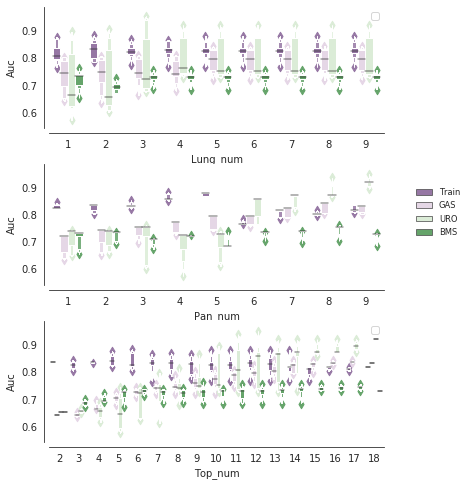

In [37]:
sns.set_style('white', {'legend.frameon':True})
fig=plt.figure(num=None, figsize=(6, 8))
grid = plt.GridSpec(3, 1, wspace=0.05, hspace=0.3)
t1=plt.subplot(grid[0, :])
t2=plt.subplot(grid[1, :])
t3=plt.subplot(grid[2,:])

sns.boxenplot(x="Lung_num", y="Auc", hue="DataSet", data=Para_res_plot2, palette="PRGn",ax=t1) 
sns.despine(offset=5,top=True,ax=t1)
t1.legend("")
sns.boxenplot(x="Pan_num", y="Auc", hue="DataSet", data=Para_res_plot2, palette="PRGn",ax=t2)
sns.despine(offset=5,top=True,ax=t2)
t2.legend(loc="right", bbox_to_anchor=[1.25, 0.6],frameon=False,fontsize="small")
sns.boxenplot(x="Top_num", y="Auc", hue="DataSet", data=Para_res_plot2, palette="PRGn",ax=t3) 
sns.despine(offset=5,top=True,ax=t3)
t3.legend("")
#plt.suptitle('Feature Performace According to diff Num',size=12)

## Sweet point response/Non response

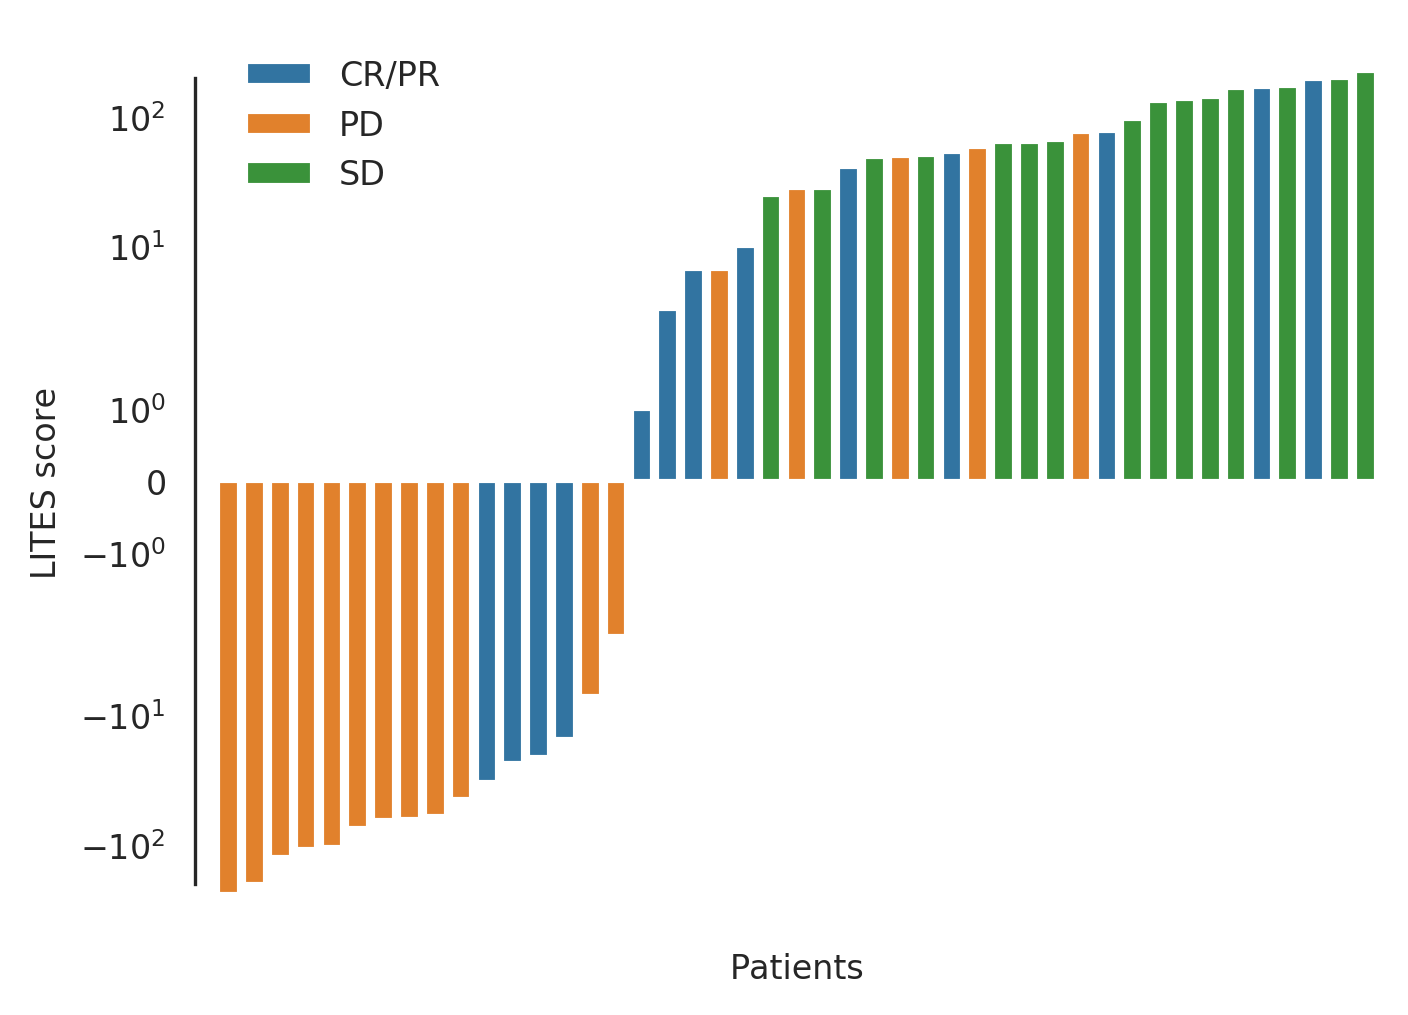

In [38]:
test_pred_plot=pd.Series(zscore(test_pred),index=test_pred.index,name="AmoyIO_test")
fpr,tpr,thresholds=roc_curve(All_cli.loc[test_pred.index,"Blabel"],test_pred_plot)
opt_idx = np.argmin(np.sqrt(np.square(1-tpr) + np.square(fpr)))
test_pred_rg=test_pred[test_pred_plot>=thresholds[opt_idx]].index
test_pred_nrg=test_pred[test_pred_plot<thresholds[opt_idx]].index

test_pred_plot=(test_pred_plot-thresholds[opt_idx]+0.01)*100
test_pred_plot=pd.concat([test_pred_plot,All_cli.loc[test_pred_plot.index,"Response"]],axis=1)
test_pred_plot.Response=test_pred_plot.Response.replace(["PR","CR"],["CR/PR","CR/PR"]).astype("category")
test_pred_plot=test_pred_plot.sort_values("AmoyIO_test")
test_pred_plot["Sample"]=test_pred_plot.index

fig,ax = plt.subplots(figsize=(5,4),dpi=300)
t1=sns.barplot(x="Sample", y="AmoyIO_test",hue="Response",dodge=False, data=test_pred_plot)
t1=sns.despine(offset=5,trim=True,bottom=True,ax=t1)
plt.xticks([])
#plt.yticks([])
plt.legend(frameon=False,loc="upper left",fontsize=8)
ax.set_yticklabels([-100,-10,-1,1,10,100],fontsize=8)
plt.ylabel("LITES score",fontsize=8)
plt.xlabel("Patients",fontsize=8)
plt.yscale('symlog')

In [103]:
all_pred_plot=pd.Series(zscore(all_pred),index=all_pred.index,name="AmoyIO_all")
fpr,tpr,thresholds=roc_curve(All_cli.loc[all_pred.index,"Blabel"],all_pred_plot)
opt_idx = np.argmin(np.sqrt(np.square(1-tpr) + np.square(fpr)))
all_pred_rg=all_pred[all_pred_plot>=thresholds[opt_idx]].index
all_pred_nrg=all_pred[all_pred_plot<thresholds[opt_idx]].index

all_pred_plot=(all_pred_plot-thresholds[opt_idx]+0.01)*100
all_pred_plot=pd.concat([all_pred_plot,All_cli.loc[all_pred_plot.index,"Response"]],axis=1)
all_pred_plot.Response=all_pred_plot.Response.replace(["PR","CR"],["CR/PR","CR/PR"]).astype("category")
all_pred_plot=all_pred_plot.sort_values("AmoyIO_all")
all_pred_plot["Sample"]=all_pred_plot.index

all_pred_plot["Group"]=["ResPred" if x > 0 else "NonResPred" for x in all_pred_plot.AmoyIO_all]

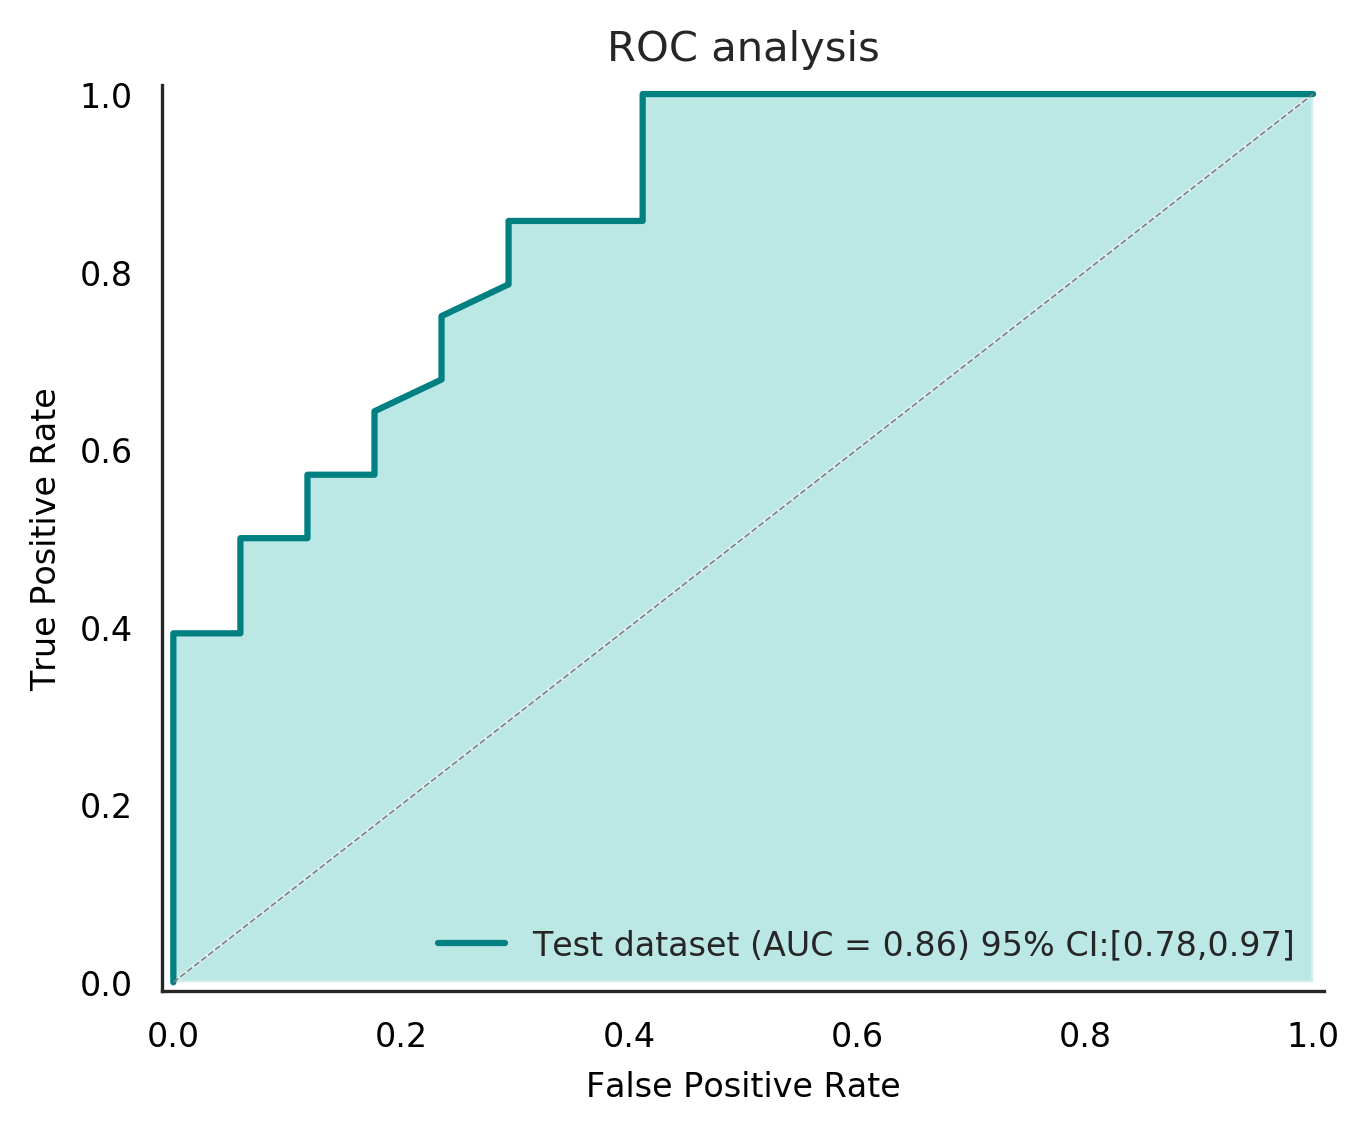

In [335]:
RNA_AUC_CI=AUC_CI(test_pred,All_cli.loc[test_pred.index,"Blabel"])
fig,ax = plt.subplots(figsize=(5,4),dpi=300)

colors=['teal']
linestypes=['-']
Pred=[test_pred]
labels = ['Test dataset']
CI=[RNA_AUC_CI]
Blabels=[All_cli.loc[test_pred.index,"Blabel"]]
for p,b,lab,col,ls,ci in zip(Pred,Blabels,labels,colors,linestypes,CI):
    fpr,tpr,thresholds = roc_curve(y_true= b,y_score=p)
    roc_auc = auc(x=fpr,y=tpr)
    ax.plot(fpr,tpr,color=col,linestyle=ls,label='%s (AUC = %0.2f) 95%% CI:[%0.2f,%0.2f]'%(lab, roc_auc,ci[0],ci[1]),linewidth=1.5)
    ax.legend(loc='lower right',fontsize=8,frameon=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.fill(fpr,tpr, 'lightseagreen', alpha=0.3)
    ax.fill([0,1,1],[0,1,0],'lightseagreen',alpha=0.3)
ax.plot([0,1],[0,1],linestyle='--',color='gray',linewidth=0.4)
plt.xlim([-0.01,1.01])
plt.xticks(fontsize=8,color='black')
plt.yticks(fontsize=8,color='black')
plt.ylim([-0.01,1.01])
 
plt.xlabel('False Positive Rate',fontsize=8,color='black')
plt.ylabel('True Positive Rate',fontsize=8,color='black')
plt.title('ROC analysis',fontsize=10)
plt.show()

## Public IO marker

In [89]:
##TMB
TMB=pd.read_csv("./TMB/Batch1.TMB.value.txt",sep="\t")
TMB_overlap=set(TMB["厦维编号"])&set(all_res.index)
roc_auc_score(TMB[TMB["厦维编号"].isin(TMB_overlap)].Response,TMB[TMB["厦维编号"].isin(TMB_overlap)]["TMB_value_1.16"])

0.5925324675324675

In [54]:
## PD-L1 TPS
pdl1_Wu1=pd.read_excel("./PD_L1/PDL1_2batches.xlsx",sheet_name="wu1",index_col=0)
pdl1_Wu2=pd.read_excel("./PD_L1/PDL1_2batches.xlsx",sheet_name="wu2",index_col=0)

Wu1_cli=All_cli[All_cli.DataSet=="Wu1"].copy()
Wu1_cli["PDL1_name"]=[x[:8] for x in Wu1_cli.index]

Wu2_cli=All_cli[All_cli.DataSet=="Batch2"].copy()
Wu2_name_trans=pd.read_csv("./PD_L1/wu_42_meta.csv",index_col=0)
Wu2_name_trans["PDL1_name"]=[x[:8] for x in Wu2_name_trans.SampleID]
Wu2_cli=Wu2_cli.join(Wu2_name_trans["PDL1_name"])

Wu_cli=pd.concat([Wu1_cli,Wu2_cli],axis=0)


TPS=pd.concat([pdl1_Wu1.iloc[:,0],pdl1_Wu2.iloc[:,0]]).dropna()
TPS=TPS.replace(["-"],[0])
TPS.name="TPS"
TPS.index=TPS.index.astype(str)

Wu_TPS=pd.merge(Wu_cli,TPS,left_on="PDL1_name",right_index=True)
roc_auc_score(Wu_TPS.Blabel,Wu_TPS["TPS"])

0.5

In [56]:
## Neoantigen
Neoantigen=pd.read_excel("./Neoantigen/Neoantigen.xls",sheet_name=0,index_col=0)
roc_auc_score(All_cli.loc[Neoantigen.index,"Blabel"],Neoantigen.Neo_SNV_30)

0.6753246753246754

In [57]:
## HLA LOH
HLA=pd.read_csv("./HLA/39SAMPLE_HLA_LOH.result",sep="\t",index_col=0)

HLA["GENE_num"]=HLA.GENE.astype(np.str).apply(lambda x: "NaN" if x=="NaN" else len(x.split(",")))
HLA["LOH_Blabel"]=HLA["HLA-LOH"].replace(["NO","YES"],[0,1])
HLA=HLA.join(All_cli.loc[:,"Blabel"],how="inner")

roc_auc_score(HLA["Blabel"],HLA["LOH_Blabel"])

0.5292207792207793

In [59]:
## TIDE
TIDE_res=pd.read_csv("./TIDE/TIDE_res.csv",index_col=0)
roc_auc_score(All_cli.loc[TIDE_res.index,"Blabel"],TIDE_res["TIDE"])

0.44642857142857145

In [60]:
## Immunophenoscore
Immunophenoscore=pd.read_table("./Immunophenoscore/IPS.txt",index_col=0)
roc_auc_score(All_cli.loc[Immunophenoscore.index,"Blabel"],Immunophenoscore["IPS"])

0.506838905775076

In [64]:
## IFNG
Lung_IFNG_pred2=All_exp_log2.loc[all_res.index,IFNG_marker].apply(zscore).mean(axis=1)
roc_auc_score(All_cli.loc[all_res.index,"Blabel"],Lung_IFNG_pred2)

0.5759878419452888

In [67]:
RNA45_AUC_CI=AUC_CI(test_pred,All_cli.loc[test_pred.index,"Blabel"])
HLA36_AUC_CI=AUC_CI(HLA["LOH_Blabel"],HLA["Blabel"])
TMB36_AUC_CI=AUC_CI(TMB["TMB_value_1.16"],TMB.Response)
TIDE75_AUC_CI=AUC_CI(TIDE_res["TIDE"],All_cli.loc[TIDE_res.index,"Blabel"])
Immunophenoscore75_AUC_CI=AUC_CI(Immunophenoscore["IPS"],All_cli.loc[Immunophenoscore.index,"Blabel"])
INFG75_AUC_CI=AUC_CI(Lung_IFNG_pred2,All_cli.loc[Lung_IFNG_pred2.index,"Blabel"])
PDL145_AUC_CI=AUC_CI(Wu_TPS["TPS"],Wu_TPS.Blabel)
Neoantigen36_AUC_CI=AUC_CI(Neoantigen.Neo_SNV_30,All_cli.loc[Neoantigen.index,"Blabel"])

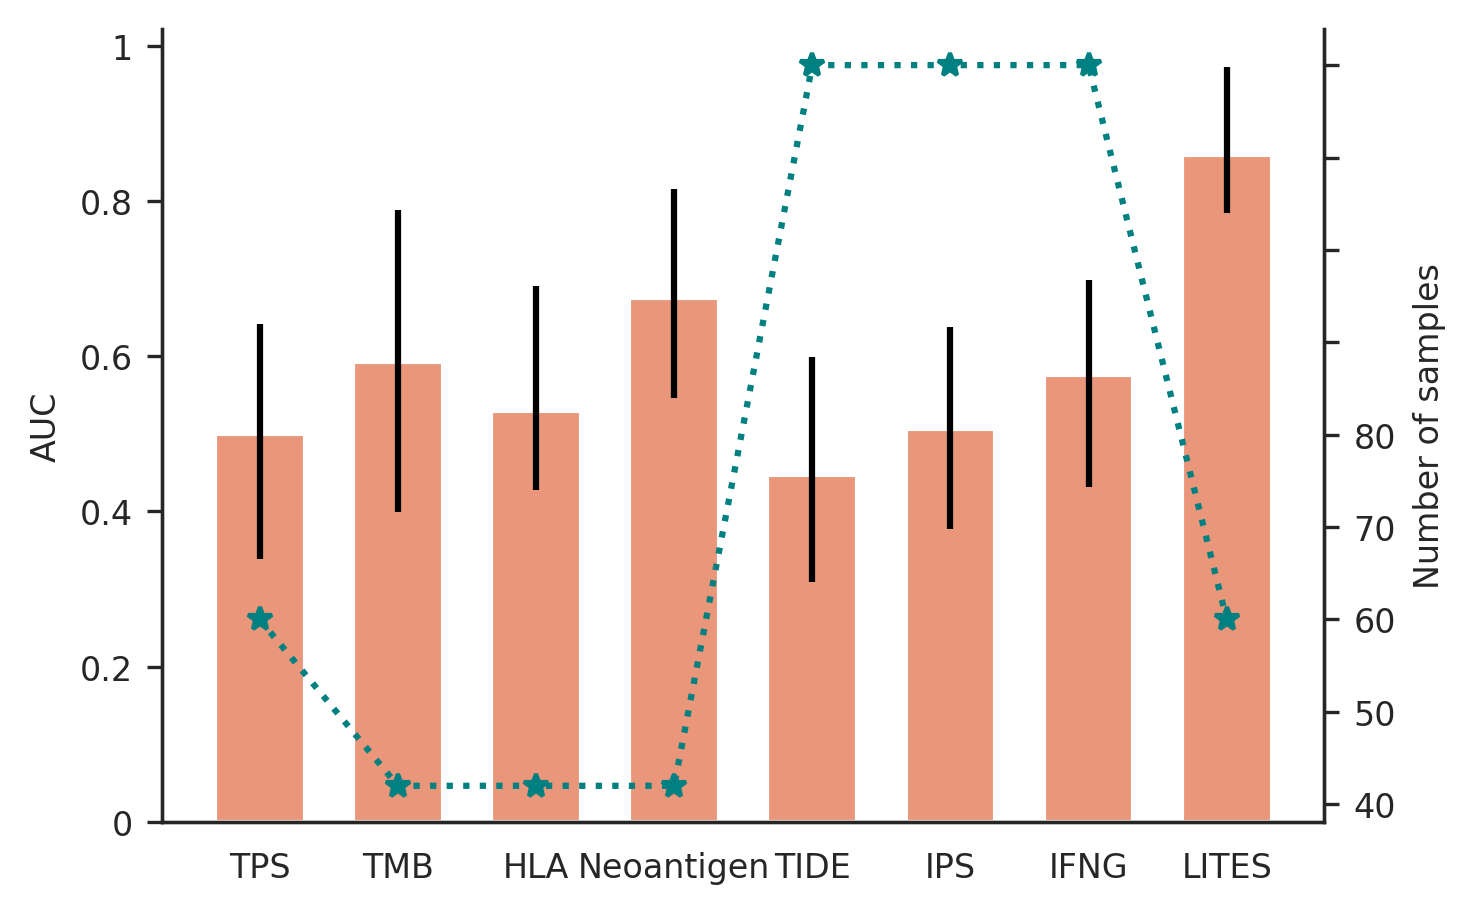

In [95]:
All_platform_AUC=pd.Series([roc_auc_score(Wu_TPS.Blabel,Wu_TPS["TPS"]),
                            roc_auc_score(TMB[TMB["厦维编号"].isin(TMB_overlap)].Response,TMB[TMB["厦维编号"].isin(TMB_overlap)]["TMB_value_1.16"]),
                            roc_auc_score(HLA["Blabel"],HLA["LOH_Blabel"]),
                            roc_auc_score(All_cli.loc[Neoantigen.index,"Blabel"],Neoantigen.Neo_SNV_30),
                            roc_auc_score(All_cli.loc[TIDE_res.index,"Blabel"],TIDE_res["TIDE"]),
                            roc_auc_score(All_cli.loc[Immunophenoscore.index,"Blabel"],Immunophenoscore["IPS"]),
                            roc_auc_score(All_cli.loc[all_res.index,"Blabel"],Lung_IFNG_pred2),
                            roc_auc_score(All_cli.loc[test_pred.index,"Blabel"],test_pred),
                           ],index=["TPS","TMB","HLA","Neoantigen","TIDE","IPS","IFNG","LICBP"])
CI_bar=(PDL145_AUC_CI,TMB36_AUC_CI,HLA36_AUC_CI,Neoantigen36_AUC_CI,TIDE75_AUC_CI,Immunophenoscore75_AUC_CI,INFG75_AUC_CI,RNA45_AUC_CI)
Sample_num=[45,36,36,36,75,75,75,45]

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,3.5),dpi=300)#yerr = np.array(CI_bar).T
ax.bar(list(range(0,len(All_platform_AUC))),list(All_platform_AUC.values),yerr = np.abs(np.array(CI_bar).T-All_platform_AUC.values),tick_label =All_platform_AUC.index.tolist(),color="darksalmon",width=0.65)
ax.set_xticklabels(["TPS","TMB","HLA","Neoantigen","TIDE","IPS","IFNG","LITES"],fontsize=8)
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1],fontsize=8)
ax2=ax.twinx()
ax2.plot(list(range(0,len(All_platform_AUC))),Sample_num,':',marker='*',c="teal")
ax2.set_yticklabels([30,40,50,60,70,80],fontsize=8)

ax.set_ylabel('AUC',fontsize=8)
ax2.set_ylabel('Number of samples',fontsize=8)
ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)


## Correlation between TPS/TMB with LICBP

In [127]:
PDL1_group=Wu_TPS.join(all_pred_plot.loc[:,["Group","all_pred_plot"]])
TMB_group=pd.merge(all_pred_plot.loc[:,["Group","all_pred_plot"]],TMB.loc[:,["TMB_value_1.16","Sample"]],left_index=True,right_on="Sample",how="inner")

TMB_group.index=TMB_group.Sample

PDL1_group["all_pred"]=all_pred[PDL1_group.index].tolist()
TMB_group["all_pred"]=all_pred[TMB_group.index].tolist()

/amoydx/USER/yangshuang/software/anaconda2/envs/tf_gpu/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Text(1.25, 28.5, 'p=0.374')

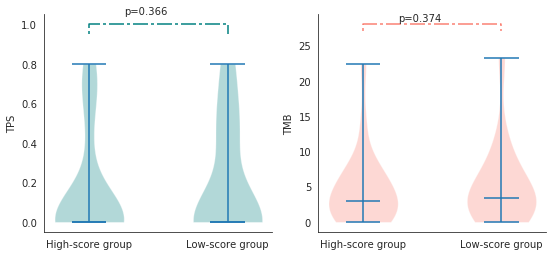

In [112]:
import matplotlib.patches as mpatches
from scipy import stats
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

PDL1_violin=axes[0].violinplot([PDL1_group.loc[PDL1_group.Group=="ResPred","TPS"].tolist(),PDL1_group.loc[PDL1_group.Group=="NonResPred","TPS"].tolist()],showmeans=False,showmedians=True,positions=[1,2])
axes[0].set_xticks([1,2])
axes[0].set_xticklabels(["High-score group","Low-score group"])
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set(ylabel='TPS')
TMB_violin=axes[1].violinplot([TMB_group.loc[TMB_group.Group=="ResPred","TMB_value_1.16"].tolist(),TMB_group.loc[TMB_group.Group=="NonResPred","TMB_value_1.16"].tolist()],showmeans=False,showmedians=True,positions=[1,2])
axes[1].set_xticks([1,2])
axes[1].set_xticklabels(["High-score group","Low-score group"])
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set(ylabel='TMB')
for vp,cc in zip(PDL1_violin['bodies'],['teal','teal']):
    vp.set_facecolor(cc)
for vp,cc in zip(TMB_violin['bodies'],['salmon','salmon']):
    vp.set_facecolor(cc)   
TMB_patch = mpatches.Patch(color="teal", label='TMB')
TPS_patch = mpatches.Patch(color="salmon", label='TPS')
#plt.legend(handles=[TMB_patch,TPS_patch],loc='right',frameon=False)
axes[0].plot([1,1,2,2], [0.95,1,1,0.95],c='teal', dashes=[2, 2, 10, 2])
axes[1].plot([1,1,2,2], [27,28,28,27],c='salmon', dashes=[2, 2, 10, 2])

PDL1_p=round(list(stats.mannwhitneyu(PDL1_group.loc[PDL1_group.Group=="ResPred","TPS"],PDL1_group.loc[PDL1_group.Group=="NonResPred","TPS"]))[1],3)
TMB_p=round(list(stats.mannwhitneyu(TMB_group.loc[TMB_group.Group=="ResPred","TMB_value_1.16"],TMB_group.loc[TMB_group.Group=="NonResPred","TMB_value_1.16"]))[1],3)

axes[0].text(1.25,1.05, 'p={}'.format(PDL1_p),fontsize=10)
axes[1].text(1.25,28.5, 'p={}'.format(TMB_p),fontsize=10)

Text(20, 0.3, 'r=-0.038\np=0.83')

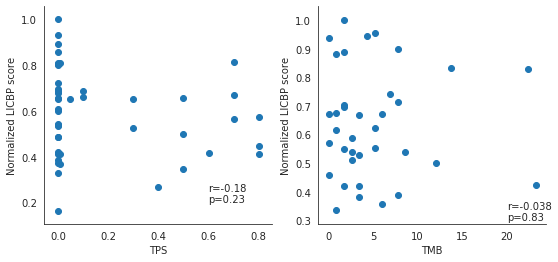

In [128]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
PDL1_cor=list(spearmanr(PDL1_group.TPS,PDL1_group.all_pred))
TMB_cor=list(spearmanr(TMB_group["TMB_value_1.16"],TMB_group.all_pred))
axes[0].scatter(PDL1_group.TPS,PDL1_group.all_pred/np.max(PDL1_group.all_pred))
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set(xlabel='TPS',ylabel='Normalized LICBP score')
axes[1].scatter(TMB_group["TMB_value_1.16"],TMB_group.all_pred/np.max(TMB_group.all_pred))
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set(xlabel='TMB',ylabel='Normalized LICBP score')

axes[0].text(0.6,0.2, 'r={:.2}\np={:.2}'.format(*PDL1_cor),fontsize=10)
axes[1].text(20,0.3, 'r={:.2}\np={:.2}'.format(*TMB_cor),fontsize=10)

## Feature Performance

In [167]:
all_res_f_plot=all_res.apply(zscore).T.loc[:,all_pred_plot.index]
all_res_f_auc=all_res.apply(zscore).apply(lambda x:roc_auc_score(All_cli.loc[all_res.index,"Blabel"],x))
f=["Key","ZhouS","Macrophages_M2","ECM","BIOCARTA_PTEN_PATHWAY","KEGG_NON_SMALL_CELL_LUNG_CANCER"]
all_res_f_auc=pd.DataFrame(all_res_f_auc[f].values,index=f,columns=["AUC"])
all_res_f_plot=all_res_f_plot.loc[f,:]

In [398]:
all_res_f_plot.index=["Immune checkpoints","Exhausted CD8+ T cell","Macrophage","Extracellular matrix","PTEN pathway","Lung cancer-specific gene set"]

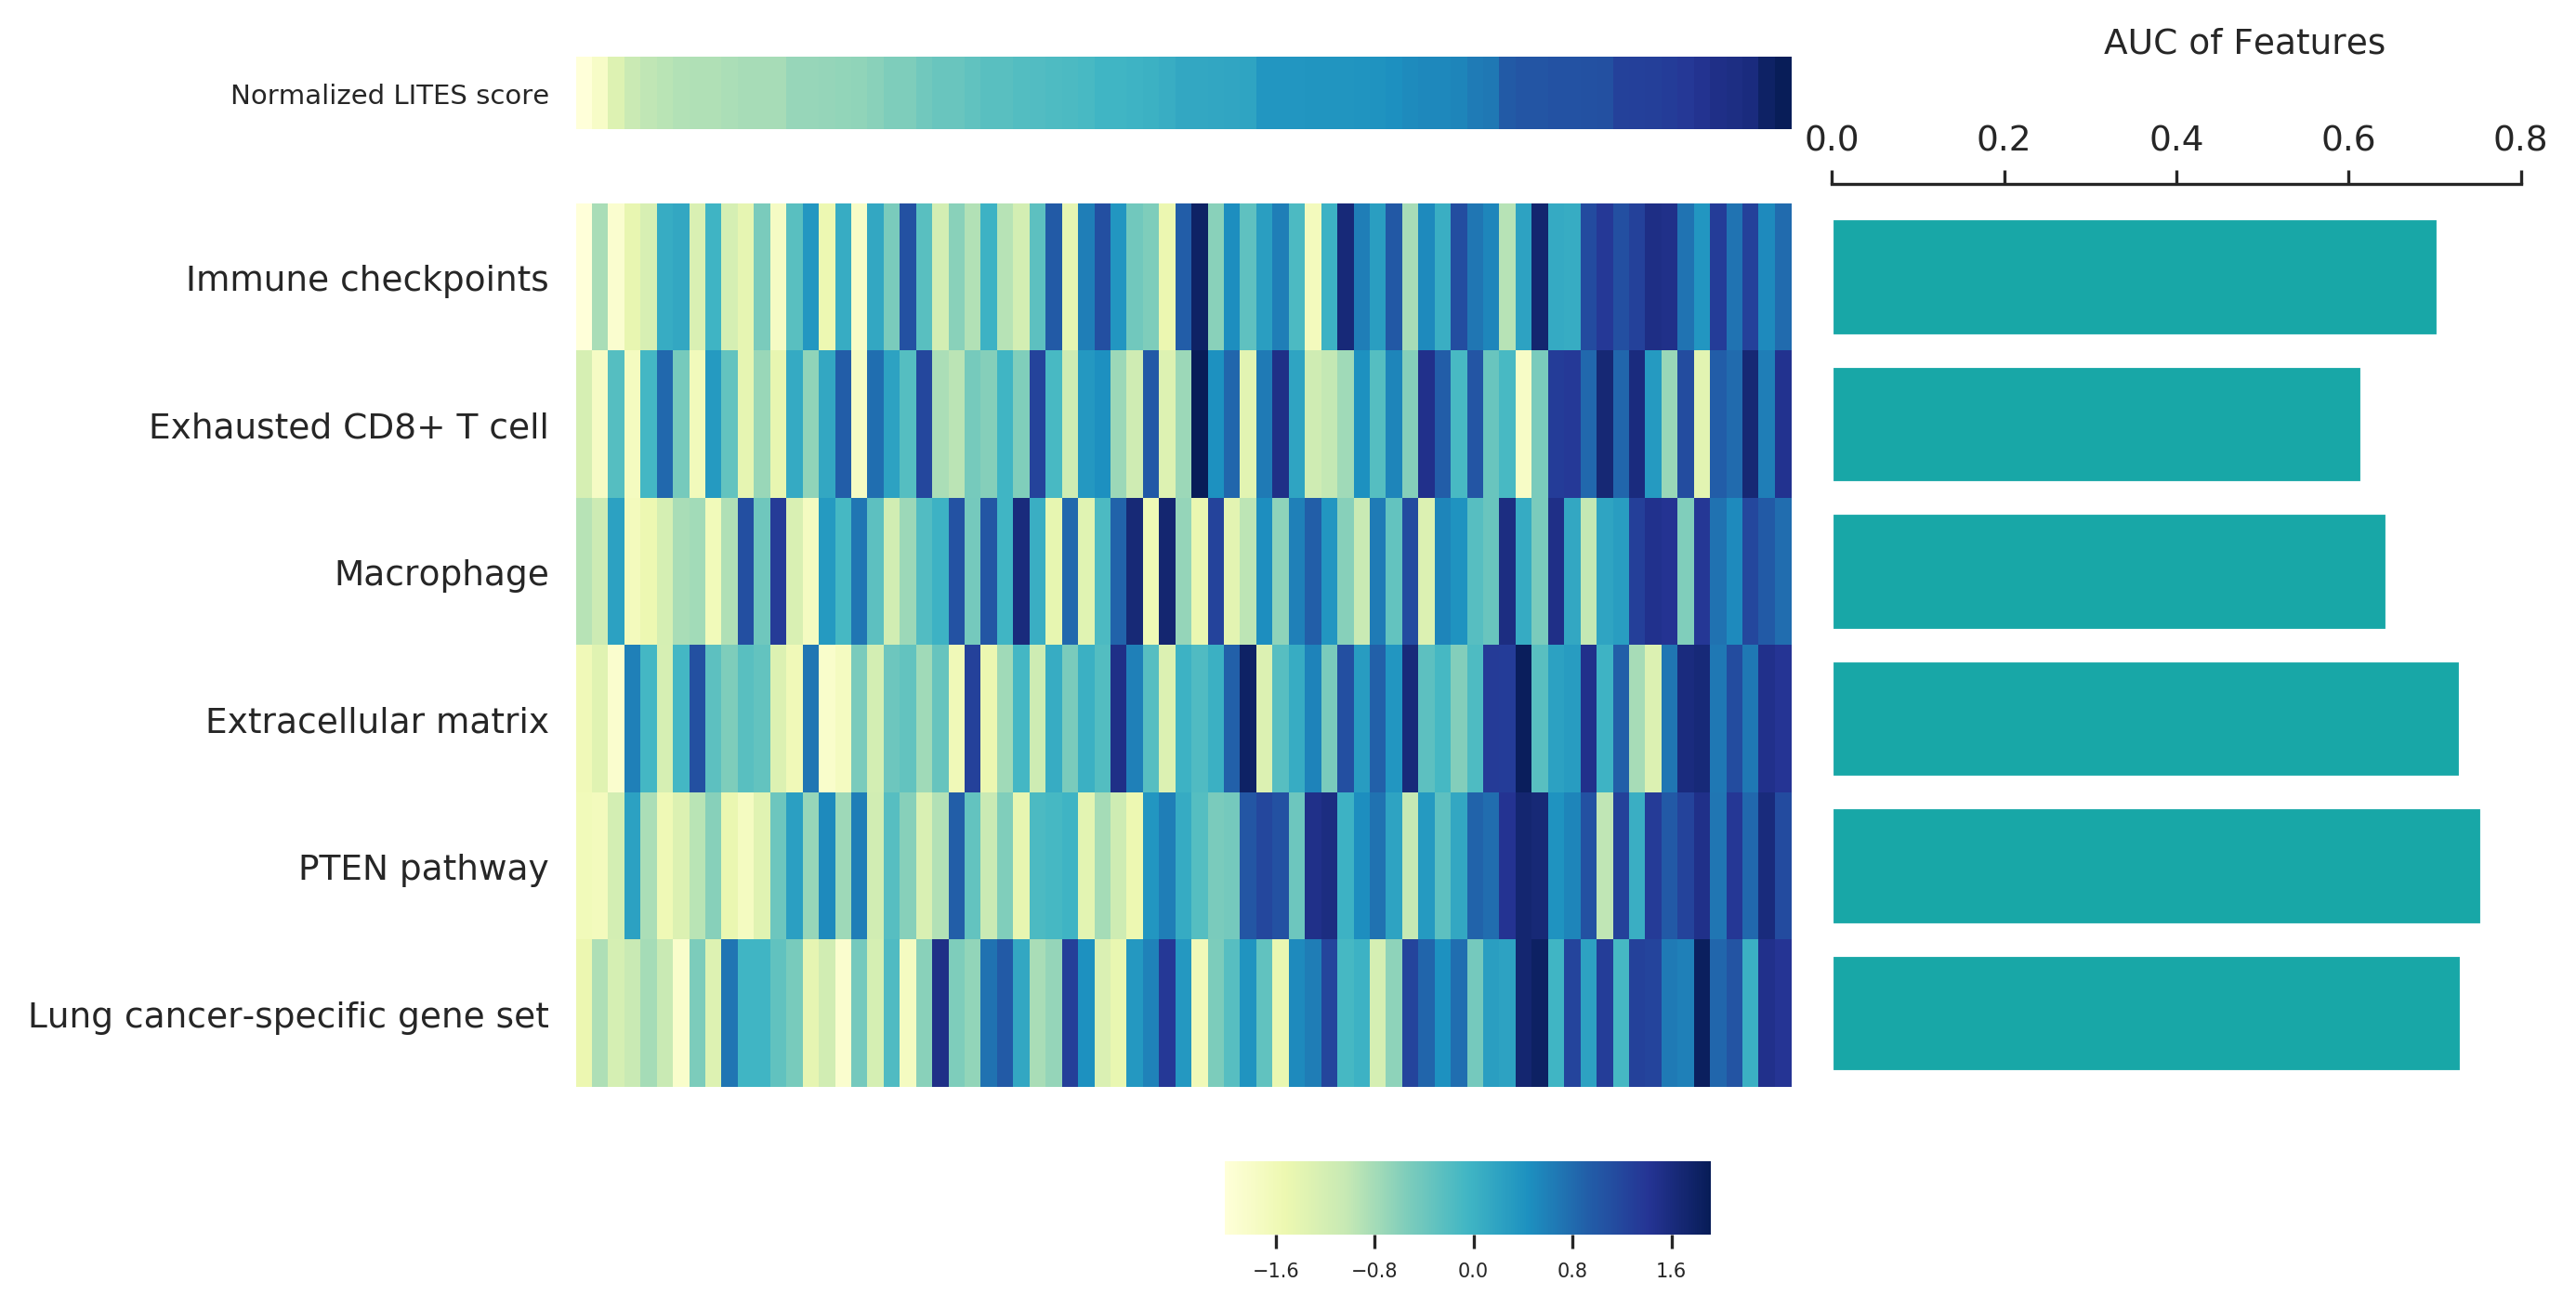

In [429]:
sns.set_style('white', {'legend.frameon':True})
fig=plt.figure(num=None, figsize=(9, 7),dpi=300)
grid = plt.GridSpec(20, 48, wspace=0, hspace=0.01)
t1=plt.subplot(grid[2:3,:30])
t2=plt.subplot(grid[4:16,:30])
t3=plt.subplot(grid[4:16,31:48])
t4=plt.subplot(grid[17,16:28])
#t5=plt.subplot(grid[18,23:24])

t1=sns.heatmap(all_pred_plot.loc[all_res_f_plot.columns,["AmoyIO_all"]].T,annot=False,ax=t1,cbar=False,cbar_kws={"orientation": "horizontal"},cmap="YlGnBu")
t1.tick_params(bottom=False)
t1.set_xticklabels([])
t1.set_yticklabels(["Normalized LITES score"],rotation=0,fontsize=10)

sns.heatmap(all_res_f_plot, cmap="YlGnBu",ax=t2,cbar_ax=t4,cbar_kws={"orientation": "horizontal"})
t2.tick_params(bottom=False)
t2.set_xticklabels([])
bottom, top = t2.get_ylim()
t2.set_ylim(bottom + 0.5, top - 0.5)
t2.set_yticklabels(all_res_f_plot.index.tolist(),fontsize=10)

sns.barplot(y=f,x="AUC",data=all_res_f_auc,color="c",ax=t3)
t3.set_xticks([0,0.2,0.4,0.6,0.8])
sns.despine(offset=5,left=True,bottom=True,top=False,ax=t3)
t3.tick_params(left=False,labelsize=10)
t3.set_yticklabels([])
t3.set_xlabel("AUC of Features",fontsize=10)
t3.xaxis.set_ticks_position("top")
t3.xaxis.set_label_coords(0.6,1.2)


In [427]:
help(t3.set_xticks)

Help on method set_xticks in module matplotlib.axes._base:

set_xticks(ticks, minor=False) method of matplotlib.axes._subplots.AxesSubplot instance
    Set the x ticks with list of *ticks*
    
    Parameters
    ----------
    ticks : list
        List of x-axis tick locations.
    
    minor : bool, optional
        If ``False`` sets major ticks, if ``True`` sets minor ticks.
        Default is ``False``.



Iteration 1: norm_delta = 0.69972, step_size = 0.9500, ll = -204.23741, newton_decrement = 13.83278, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.16696, step_size = 0.9500, ll = -189.77014, newton_decrement = 0.32927, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.01232, step_size = 0.9500, ll = -189.38639, newton_decrement = 0.00193, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00064, step_size = 1.0000, ll = -189.38011, newton_decrement = 0.00001, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -189.37986, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence completed after 5 iterations.


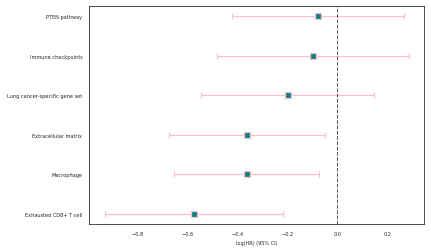

In [402]:
from lifelines import CoxPHFitter
#fig, ax = plt.subplots(figsize=(4,3),dpi=300)
PFS=pd.read_csv("PFS.csv",index_col=0)
PFS=PFS.join(all_pred_plot.Group,how="inner",rsuffix="Predition")
PFS=PFS[PFS.PFS.notnull()]

PFS_f=PFS.join(all_res_f_plot.T.iloc[:,:6],how="inner")
cph = CoxPHFitter(penalizer=0.5)
cph.fit(PFS_f.drop(columns=["Group","GroupPredition"]), duration_col='PFS', event_col='Status', show_progress=True)
cph.plot(markerfacecolor="teal",c="pink")

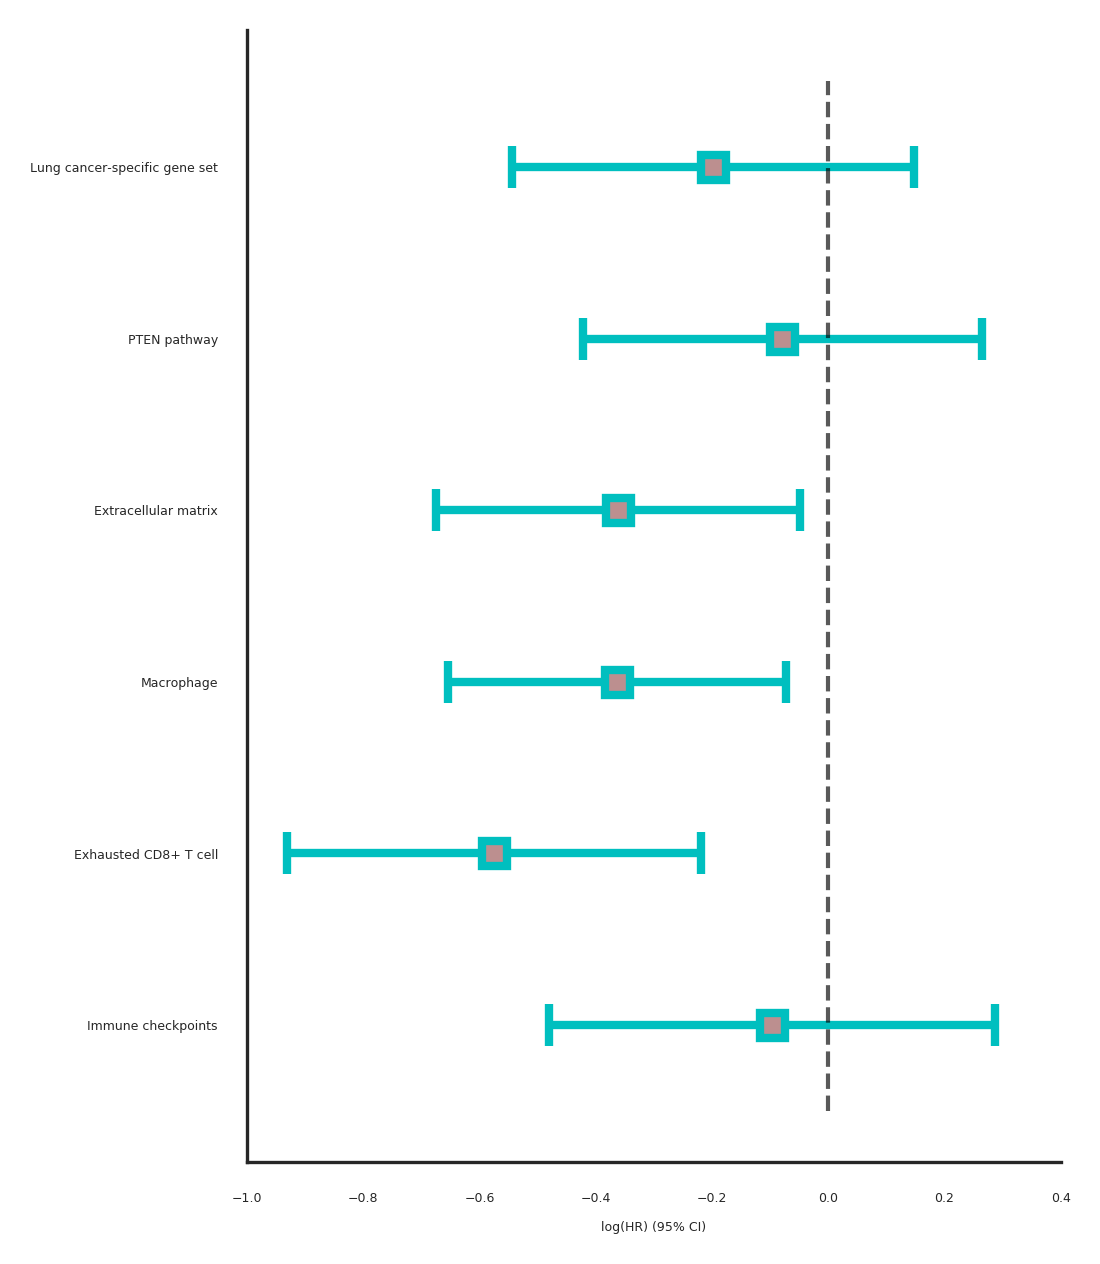

In [418]:
cph_plot=cph.summary
cph_plot.loc[:,["upper 0.95","lower 0.95"]].T-cph_plot["coef"].values

errorbar_kwargs=dict()
errorbar_kwargs.setdefault("c", "c")
errorbar_kwargs.setdefault("fmt", "s")
errorbar_kwargs.setdefault("markerfacecolor", "rosybrown")
errorbar_kwargs.setdefault("markeredgewidth", 2)
errorbar_kwargs.setdefault("elinewidth", 2)
errorbar_kwargs.setdefault("capsize",5)
fig, ax = plt.subplots(figsize=(3.5,5),dpi=300)#yerr = np.array(CI_bar).T
xerr=np.abs(cph_plot.loc[:,["lower 0.95","upper 0.95"]].T-cph_plot["coef"]).values
#xerr=np.vstack([cph_plot["lower 0.95"],cph_plot["upper 0.95"]])
ax.set_xlim([-1,0.4])
ax.errorbar(cph_plot["coef"], list(range(0,6)), xerr=xerr,**errorbar_kwargs)
ax.vlines(0,-0.5,5.5,linestyles="dashed", linewidths=1, alpha=0.65)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yticks(list(range(0,6)), cph_plot.index.tolist())
plt.xlabel("log(HR) (95% CI)")
plt.rcParams.update({'font.size': 5})

In [404]:
all_res_f_plot.T.iloc[:,:6]

,Immune checkpoints,Exhausted CD8+ T cell,Macrophage,Extracellular matrix,PTEN pathway,Lung cancer-specific gene set
20144574Z01TF2,-2.014347,-1.216855,-0.923843,-1.609127,-1.619014,-1.502284
18002084E05TF1,-0.831966,-1.747770,-1.108611,-1.352351,-1.665245,-0.850251
20166007H01LF2,-1.879985,-0.208118,0.230961,-1.865902,-1.179818,-1.215389
190713-9T,-1.450029,-1.694678,-1.662917,0.599143,0.230231,-1.058901
20167157H15TF2,-1.235050,-0.075390,-1.524340,-0.068473,-0.833085,-0.798088
...,...,...,...,...,...,...
190713-25T,1.317817,0.933347,0.739074,0.676176,0.692542,0.845035
190713-27T,0.726627,0.800619,0.508113,1.138372,1.386009,1.053685
190713-36T,1.264072,1.676627,1.200995,0.676176,0.831236,0.036514
190713-12T,0.511648,0.614799,0.970035,1.497857,1.617165,1.497068


[Text(0, 0.5, 'Lung cancer-specific gene set'),
 Text(0, 1.5, 'PTEN pathway'),
 Text(0, 2.5, 'Immune checkpoints'),
 Text(0, 3.5, 'Exhausted CD8+ T cell'),
 Text(0, 4.5, 'Extracellular matrix'),
 Text(0, 5.5, 'Macrophage')]

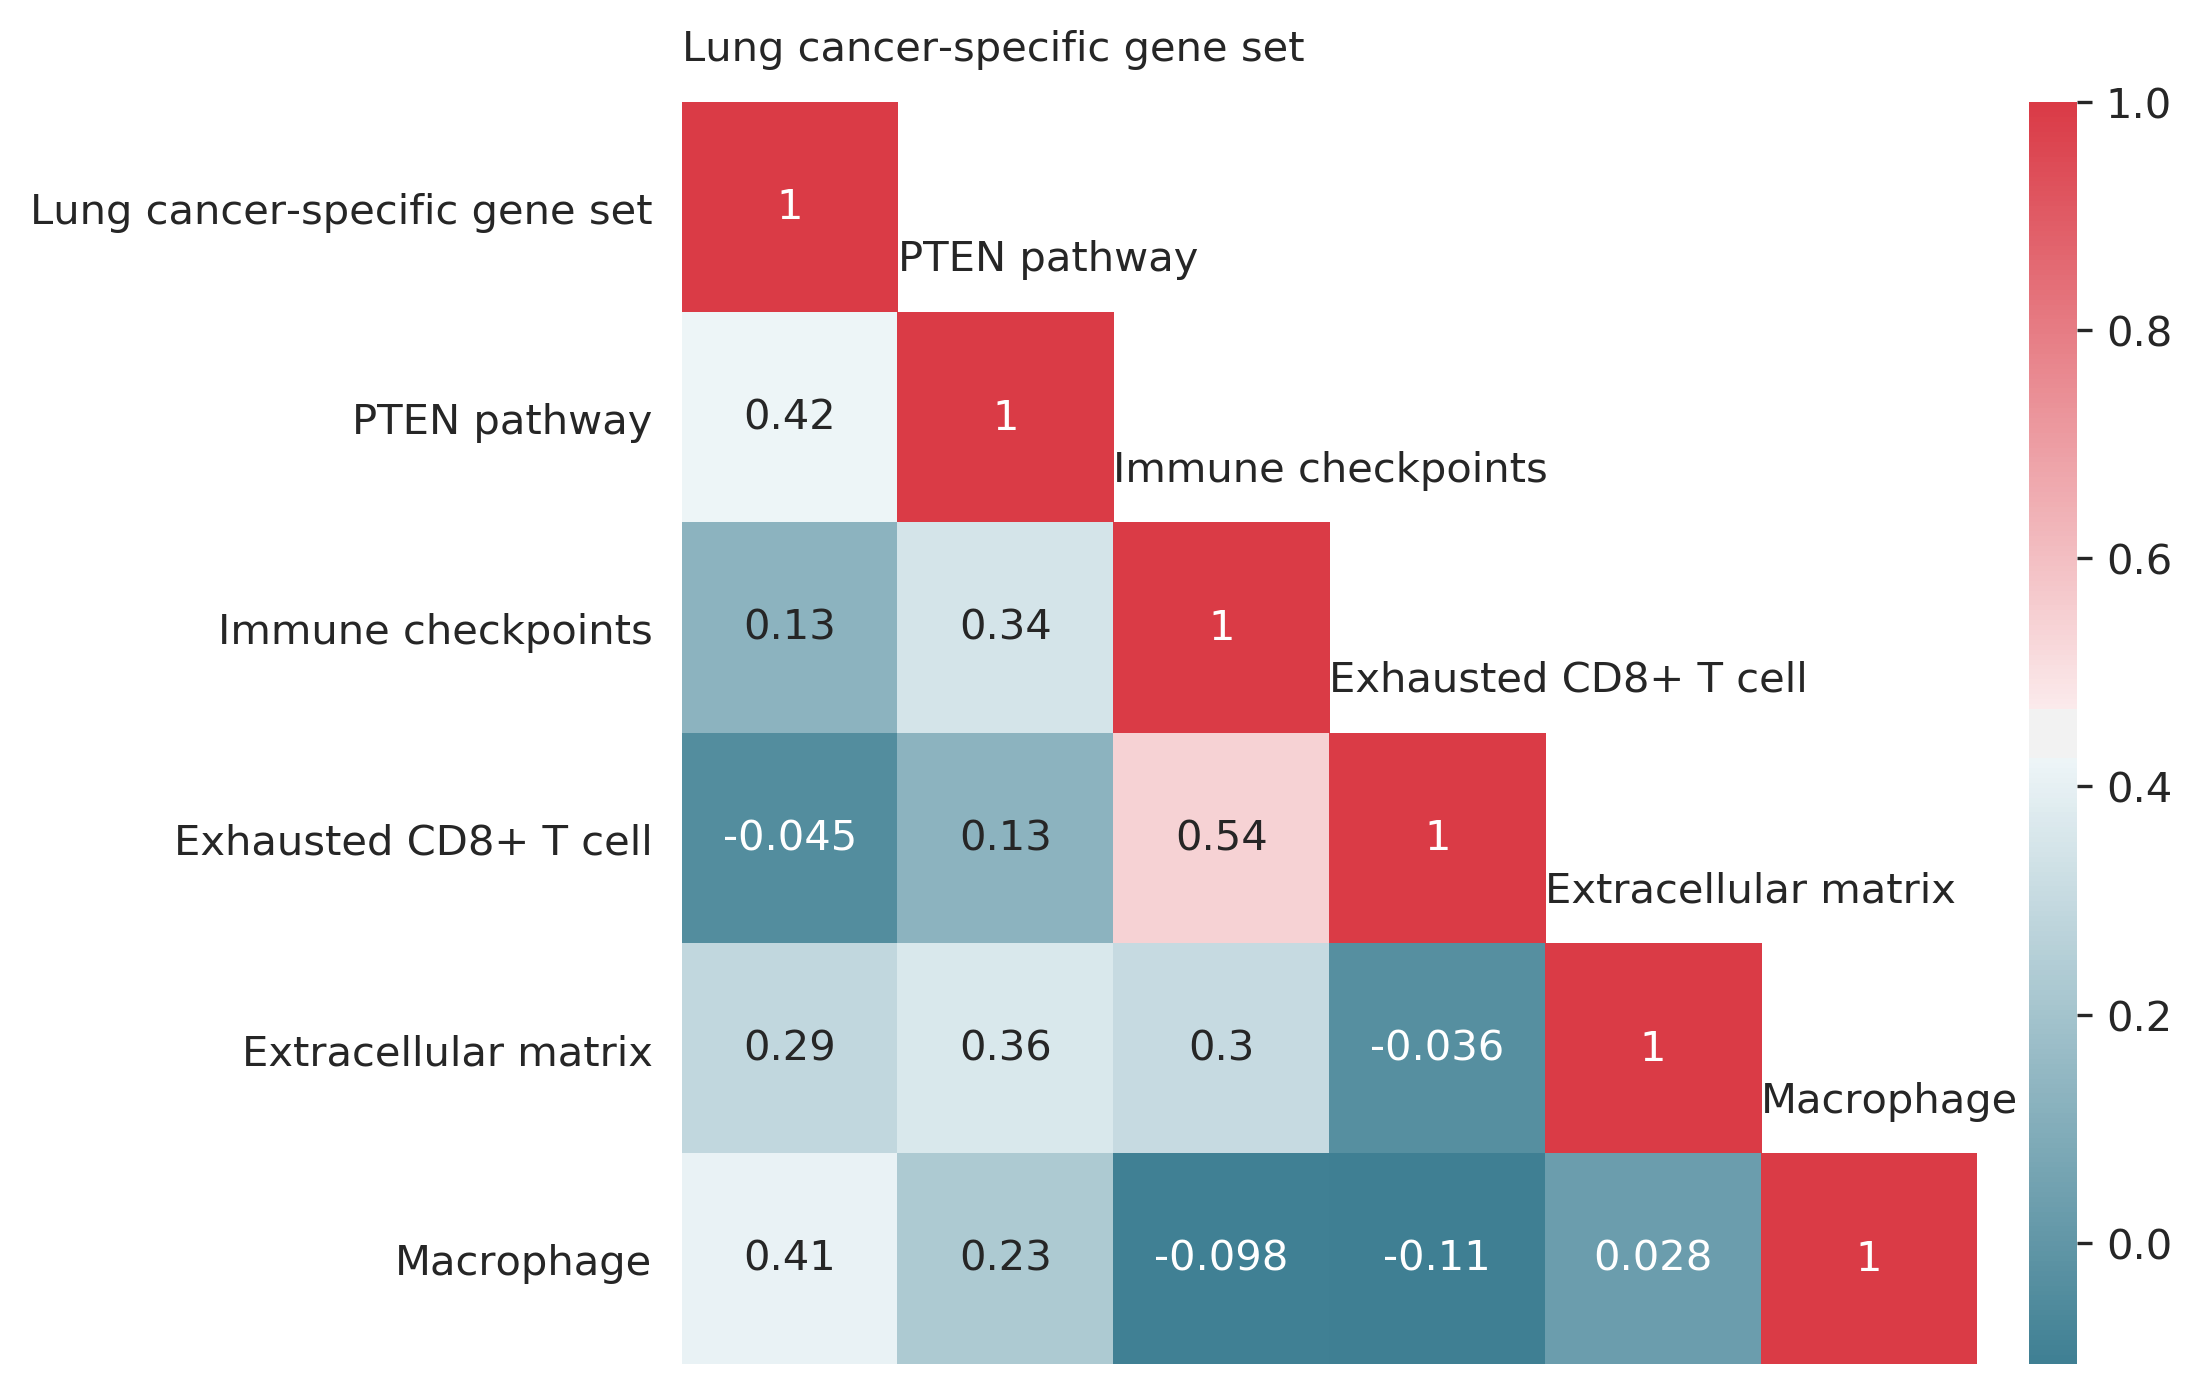

In [405]:
f_corr=all_res_f_plot.T.corr()
plt.rcParams.update({'font.size': 10})
#fig,ax = plt.subplots(figsize=(7,6),dpi=300)
index=["Lung cancer-specific gene set","PTEN pathway","Immune checkpoints","Exhausted CD8+ T cell","Extracellular matrix","Macrophage"]
fig=plt.figure(num=None, figsize=(6,6.5),dpi=300)
grid = plt.GridSpec(7, 28, wspace=0.05, hspace=0)
ax=plt.subplot(grid[:6, :26])
t2=plt.subplot(grid[:6, 27])
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.zeros_like(f_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(f_corr.loc[index,index],annot=True,mask=~mask.T,cmap=cmap,ax=ax,cbar_ax=t2)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_xticklabels([],rotation=90)
ax.set_yticklabels(["Lung cancer-specific gene set","PTEN pathway","Immune checkpoints","Exhausted CD8+ T cell","Extracellular matrix","Macrophage"])
ax.text(0,-0.2, 'Lung cancer-specific gene set',fontsize=10)
ax.text(1,0.8, 'PTEN pathway',fontsize=10)
ax.text(2,1.8, 'Immune checkpoints',fontsize=10)
ax.text(3,2.8, 'Exhausted CD8+ T cell',fontsize=10)
ax.text(4,3.8, 'Extracellular matrix',fontsize=10)
ax.text(5,4.8, 'Macrophage',fontsize=10)
ax.set_yticklabels(["Lung cancer-specific gene set","PTEN pathway","Immune checkpoints","Exhausted CD8+ T cell","Extracellular matrix","Macrophage"],fontsize=10)

In [435]:
from scipy.stats import pearsonr
print(pearsonr(all_res_f_plot.loc["Immune checkpoints",:],all_res_f_plot.loc["Exhausted CD8+ T cell",:]))
print(pearsonr(all_res_f_plot.loc["Lung cancer-specific gene set",:],all_res_f_plot.loc["PTEN pathway",:]))

(0.5422604920094255, 5.034475175369667e-07)
(0.42453669146247786, 0.000147008383943632)


Text(0, 0.5, '')

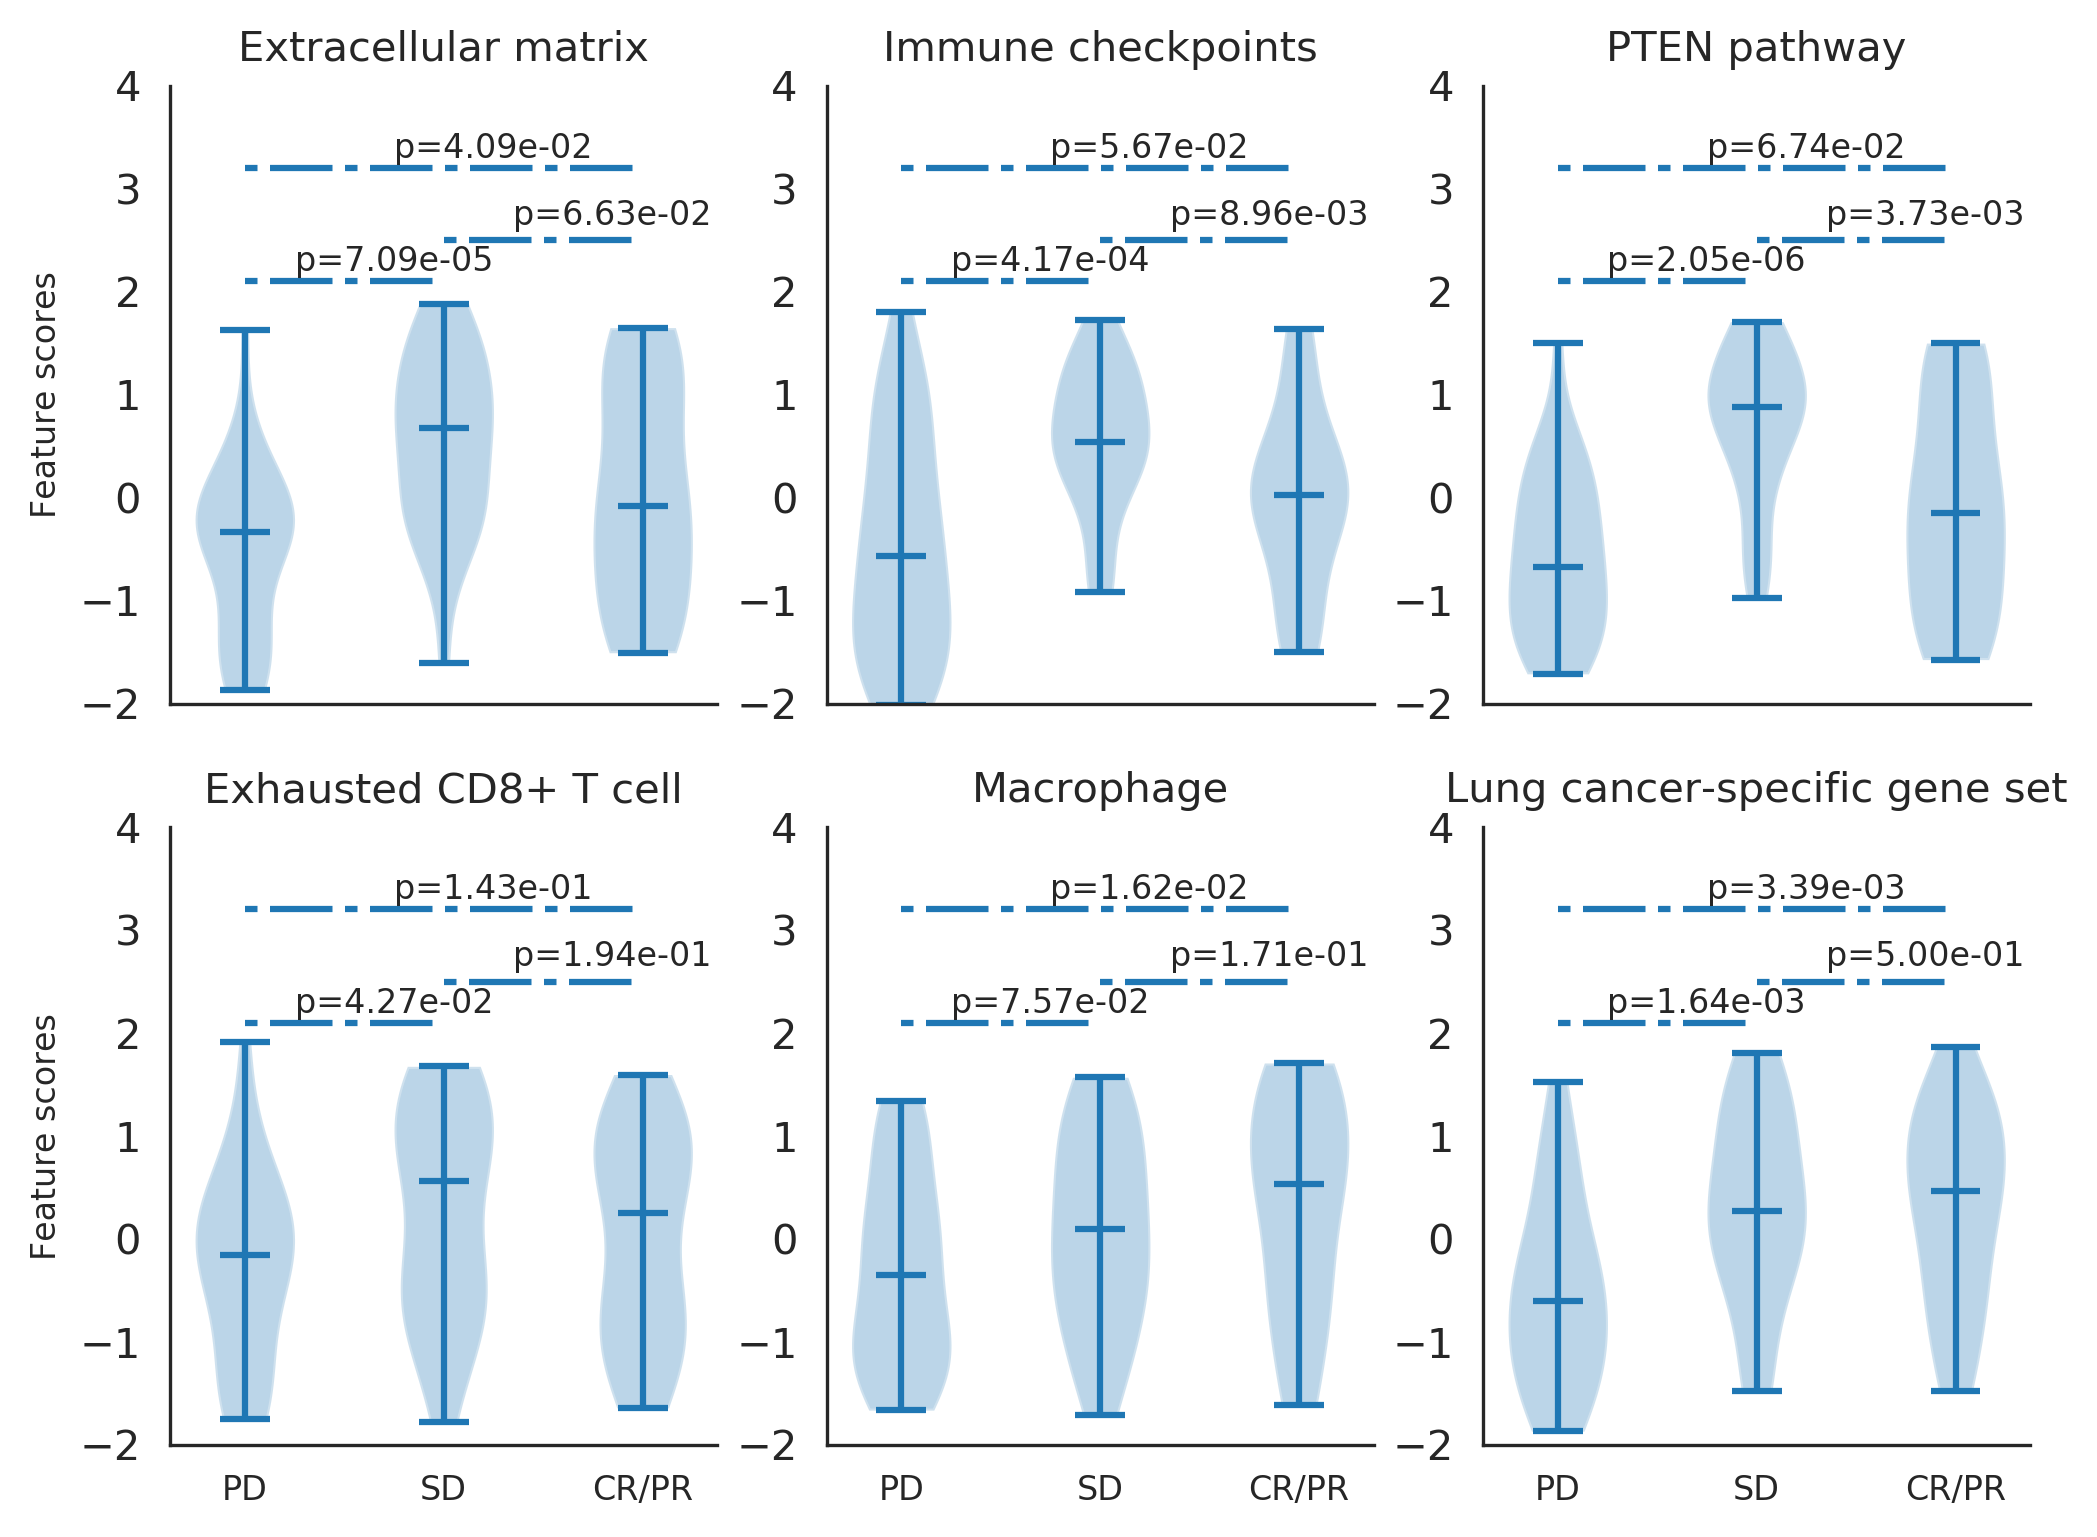

In [406]:
all_res_f_plot2=all_res_f_plot.T.join(all_pred_plot).copy()
import matplotlib.patches as mpatches
from scipy import stats
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 6),dpi=300,gridspec_kw={"wspace":0.2, "hspace":0.2})

def violin_plot(ax,f_dataframe,ff):
    ax.violinplot([f_dataframe.loc[f_dataframe.Response=="PD",ff].tolist(),f_dataframe.loc[f_dataframe.Response=="SD",ff].tolist(),f_dataframe.loc[f_dataframe.Response=="CR/PR",ff].tolist()],showmeans=False,showmedians=True,positions=[1,2,3])
    ax.set_xticks([1,2,3])
    ax.set_xticklabels(["PD","SD","CR/PR"],fontsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel('Feature scores',fontsize=8)
    ax.set_title(ff)
    PD_SD=list(stats.mannwhitneyu(f_dataframe.loc[f_dataframe.Response=="PD",ff],f_dataframe.loc[f_dataframe.Response=="SD",ff]))[1]
    SD_PR=list(stats.mannwhitneyu(f_dataframe.loc[f_dataframe.Response=="SD",ff],f_dataframe.loc[f_dataframe.Response=="CR/PR",ff]))[1]
    PD_PR=list(stats.mannwhitneyu(f_dataframe.loc[f_dataframe.Response=="PD",ff],f_dataframe.loc[f_dataframe.Response=="CR/PR",ff]))[1]
    ax.plot([1,2], [2.1,2.1],color="#1F77B4", dashes=[2, 2, 10, 2])
    ax.plot([2,3], [2.5,2.5],color="#1F77B4", dashes=[2, 2, 10, 2])
    ax.plot([1,3], [3.2,3.2],color="#1F77B4", dashes=[2, 2, 10, 2])
    ax.text(1.25,2.2, 'p={:.2e}'.format(PD_SD),fontsize=8)
    ax.text(2.35,2.65, 'p={:.2e}'.format(SD_PR),fontsize=8)
    ax.text(1.75,3.3, 'p={:.2e}'.format(PD_PR),fontsize=8)
    ax.set_ylim([-2,4])
    ax.set_title(ff,fontsize=10)
    return(ax)
axes[0,0]=violin_plot(axes[0,0],all_res_f_plot2,"Extracellular matrix")
axes[0,0].set_xticklabels([])
axes[0,1]=violin_plot(axes[0,1],all_res_f_plot2,"Immune checkpoints")
axes[0,1].set_xticklabels([])
axes[0,1].set_ylabel("")
axes[0,2]=violin_plot(axes[0,2],all_res_f_plot2,"PTEN pathway")
axes[0,2].set_xticklabels([])
axes[0,2].set_ylabel("")
axes[1,0]=violin_plot(axes[1,0],all_res_f_plot2,"Exhausted CD8+ T cell")
axes[1,1]=violin_plot(axes[1,1],all_res_f_plot2,"Macrophage")
axes[1,1].set_ylabel("")
axes[1,2]=violin_plot(axes[1,2],all_res_f_plot2,"Lung cancer-specific gene set")
axes[1,2].set_ylabel("")

## LITES biological function

Text(0, 0.5, '')

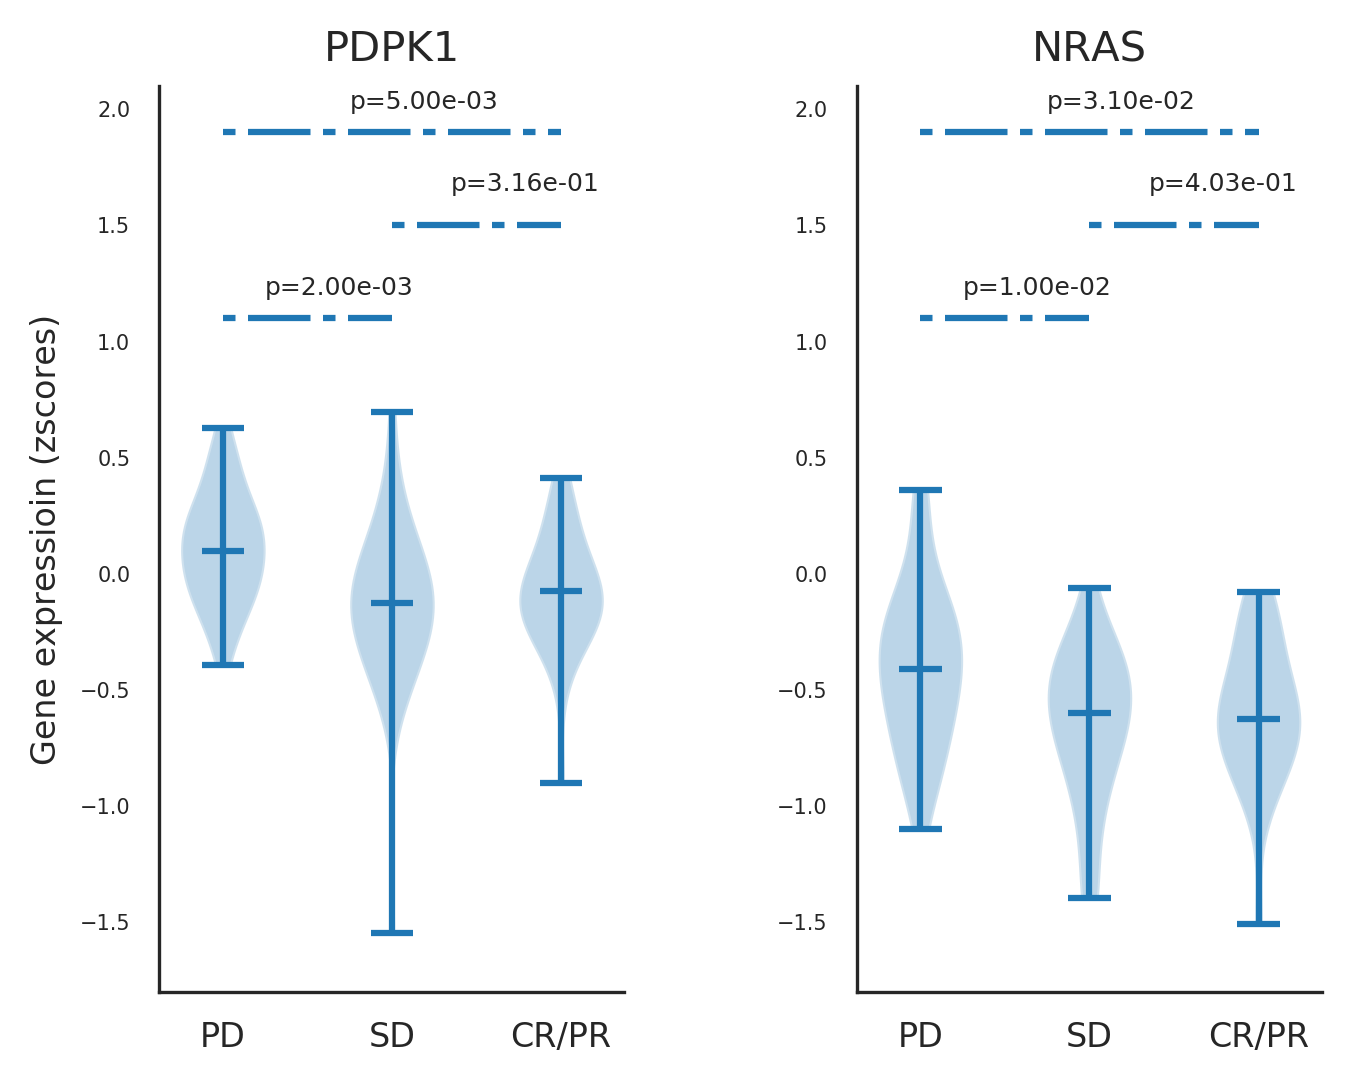

In [348]:
## NRAS PDPK1
def violin_plot(ax,f_dataframe,ff):
    ax.violinplot([f_dataframe.loc[f_dataframe.Response=="PD",ff].tolist(),f_dataframe.loc[f_dataframe.Response=="SD",ff].tolist(),f_dataframe.loc[f_dataframe.Response=="CR/PR",ff].tolist()],showmeans=False,showmedians=True,positions=[1,2,3])
    ax.set_xticks([1,2,3])
    ax.set_xticklabels(["PD","SD","CR/PR"],fontsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(ff)
    PD_SD=round(list(stats.mannwhitneyu(f_dataframe.loc[f_dataframe.Response=="PD",ff],f_dataframe.loc[f_dataframe.Response=="SD",ff]))[1],3)
    SD_PR=round(list(stats.mannwhitneyu(f_dataframe.loc[f_dataframe.Response=="SD",ff],f_dataframe.loc[f_dataframe.Response=="CR/PR",ff]))[1],3)
    PD_PR=round(list(stats.mannwhitneyu(f_dataframe.loc[f_dataframe.Response=="PD",ff],f_dataframe.loc[f_dataframe.Response=="CR/PR",ff]))[1],3)
    ax.plot([1,2], [1.1,1.1],color="#1F77B4", dashes=[2, 2, 10, 2])
    ax.plot([2,3], [1.5,1.5],color="#1F77B4", dashes=[2, 2, 10, 2])
    ax.plot([1,3], [1.9,1.9],color="#1F77B4", dashes=[2, 2, 10, 2])
    ax.text(1.25,1.2, 'p={:.2e}'.format(PD_SD),fontsize=6)
    ax.text(2.35,1.65, 'p={:.2e}'.format(SD_PR),fontsize=6)
    ax.text(1.75,2, 'p={:.2e}'.format(PD_PR),fontsize=6)
    ax.set_ylim([-1.8,2.1])
    ax.set_ylabel("Gene expressioin (zscores)",fontsize=8)
    ax.set_title(ff,fontsize=10)
    return(ax)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5,4),dpi=300,gridspec_kw={"wspace":0.5, "hspace":0.2})
gg="BIOCARTA_PTEN_PATHWAY"
Cgeneset=set(Msigdb[gg])&set(All_exp_log2.columns)
Cgeneset_Norm=All_exp_log2.loc[:,Cgeneset].T.apply(zscore).T.dropna(axis=1)
Cgeneset=Cgeneset&set(Cgeneset_Norm.columns)
Cgeneset_Norm=Cgeneset_Norm.loc[all_pred_plot.index,:].join(all_pred_plot.Response)

axes[0]=violin_plot(axes[0],Cgeneset_Norm,"PDPK1")


gg="KEGG_NON_SMALL_CELL_LUNG_CANCER"
Cgeneset=set(Msigdb[gg])&set(All_exp_log2.columns)
Cgeneset_Norm=All_exp_log2.loc[:,Cgeneset].T.apply(zscore).T.dropna(axis=1)
Cgeneset=Cgeneset&set(Cgeneset_Norm.columns)
Cgeneset_Norm=Cgeneset_Norm.loc[all_pred_plot.index,:].join(all_pred_plot.Response)

axes[1]=violin_plot(axes[1],Cgeneset_Norm,"NRAS")
axes[1].set_ylabel("")

In [250]:
## xcell
Wu_xcell=pd.read_csv("./xcell/Wu_xcell.csv",index_col=0)

all_pred.name="all_pred"
Wu_xcell=Wu_xcell.join(all_pred)
Wu_xcell=Wu_xcell.join(All_cli)


print("StromaScore vs LITES:",spearmanr(Wu_xcell.StromaScore,Wu_xcell.all_pred))

StromaScore vs LITES: SpearmanrResult(correlation=0.4801695694583681, pvalue=1.303580057442725e-05)


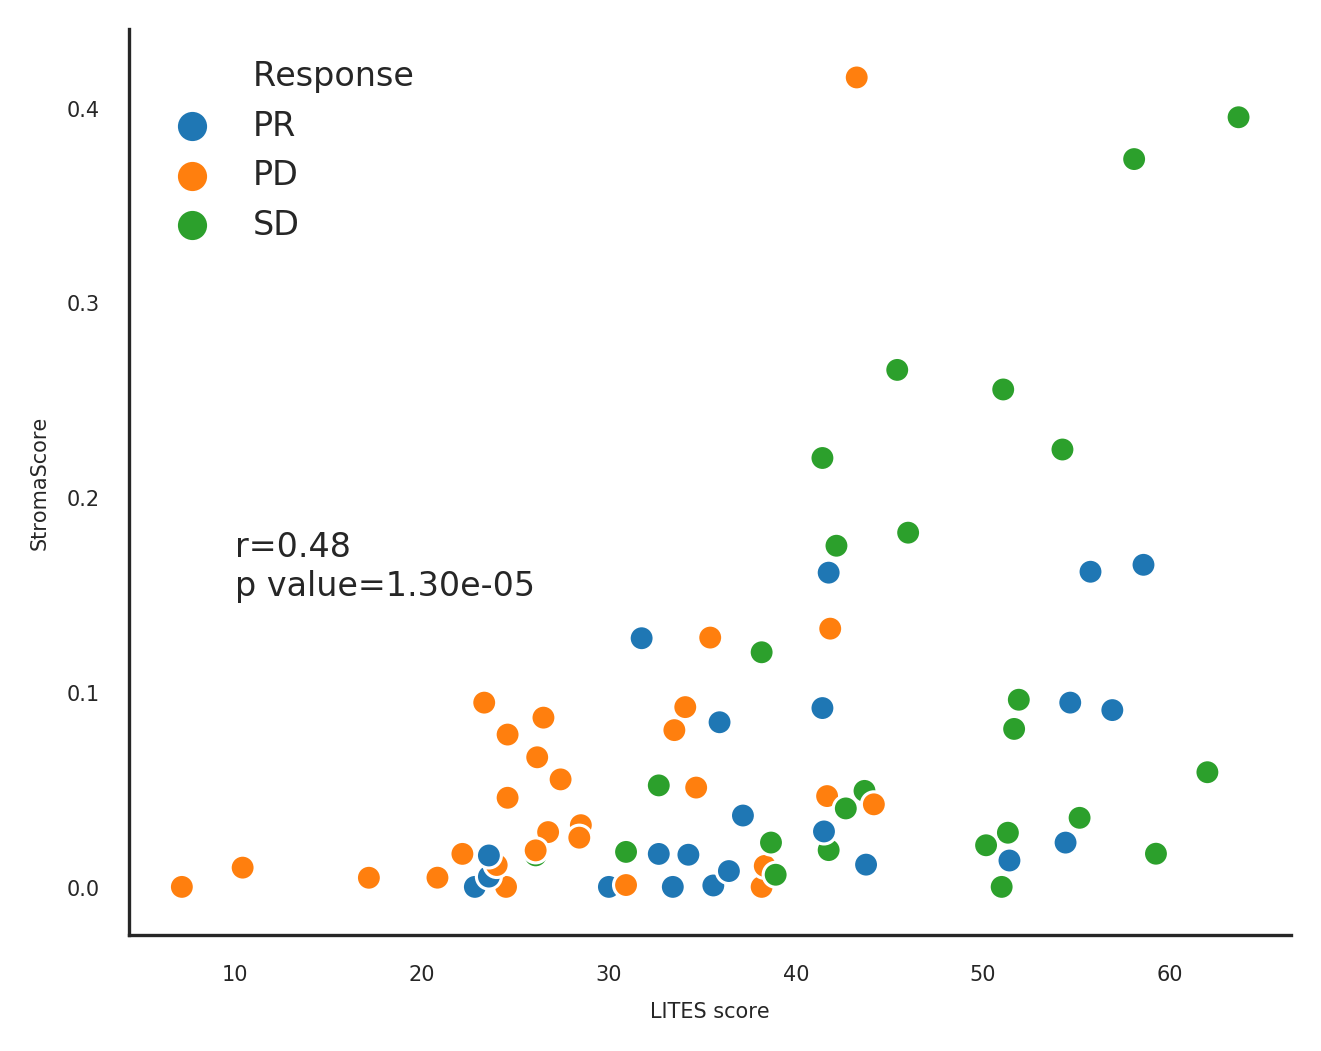

In [326]:
fig = plt.figure(figsize=(5,4),dpi=300)
ax=sns.scatterplot(x="all_pred", y="StromaScore", hue="Response", data=Wu_xcell)
ax.set(xlabel='LITES score')
plt.text(10, 0.15,'r=0.48\np value=1.30e-05',fontsize=8)
plt.legend(frameon=False,loc="upper left",fontsize=8)
sns.despine(top=True)

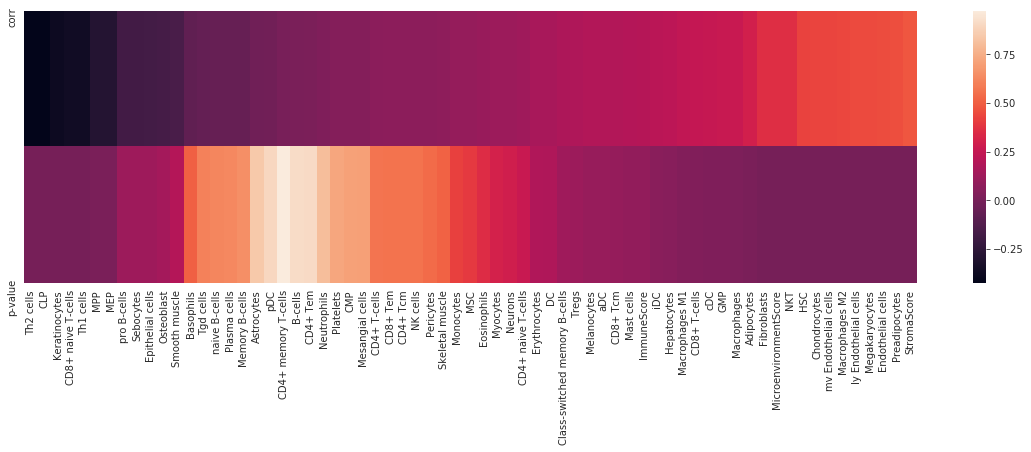

In [255]:
Wu_xcell_res=pd.DataFrame(Wu_xcell.drop(columns=["all_pred"]).apply(lambda x:list(spearmanr(Wu_xcell.all_pred,x)),axis=0))

Wu_xcell_res=pd.DataFrame(dict(Wu_xcell_res.iloc[:,0])).T
Wu_xcell_res.columns=["corr","p-value"]

fig=plt.figure(num=None, figsize=(20, 5))
sns.heatmap(Wu_xcell_res.drop(index=["DataSet","Blabel","Response"]).sort_values(by="corr").T)

In [259]:
print("StromaAUC:",roc_auc_score(Wu_xcell.Blabel,Wu_xcell.StromaScore))
print("T-cellsAUC:",roc_auc_score(Wu_xcell.Blabel,Wu_xcell["CD8+ T-cells"]))

CD875_AUC_CI=AUC_CI(Wu_xcell["CD8+ T-cells"],Wu_xcell.Blabel)
Strom75_AUC_CI=AUC_CI(Wu_xcell.StromaScore,Wu_xcell.Blabel)

StromaAUC: 0.5744680851063829
T-cellsAUC: 0.5957446808510638


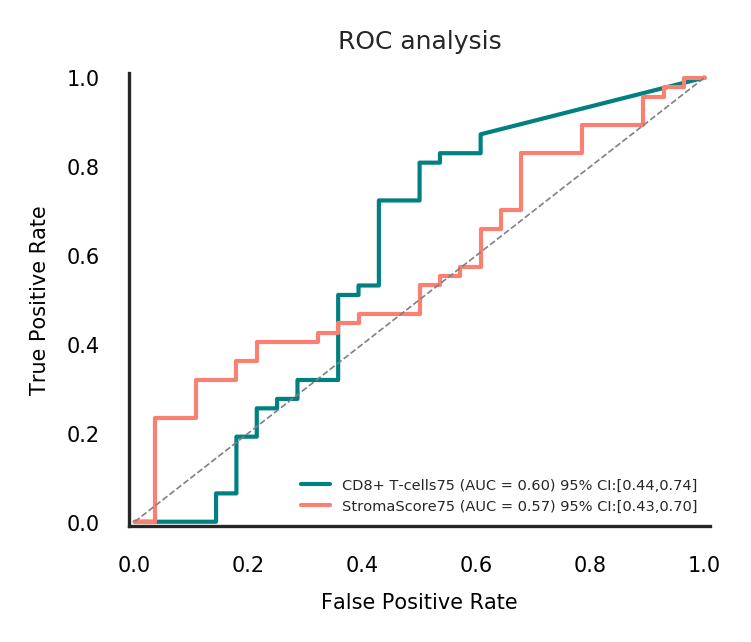

In [325]:
fig,ax = plt.subplots(figsize=(2.5,2),dpi=300)
colors=['teal','salmon']
linestypes=['-','-']
labels = ['CD8+ T-cells75','StromaScore75']
Pred = [Wu_xcell["CD8+ T-cells"],Wu_xcell.StromaScore]
CI=[CD875_AUC_CI,Strom75_AUC_CI]
Blabels=[Wu_xcell.Blabel,Wu_xcell.Blabel]
for p,b,lab,col,ls,ci in zip(Pred,Blabels,labels,colors,linestypes,CI):
    fpr,tpr,thresholds = roc_curve(y_true= b,y_score=p)
    roc_auc = auc(x=fpr,y=tpr)
    ax.plot(fpr,tpr,color=col,linestyle=ls,label='%s (AUC = %0.2f) 95%% CI:[%0.2f,%0.2f]'%(lab, roc_auc,ci[0],ci[1]),linewidth=1)
    ax.legend(frameon=False,loc='lower right',fontsize=3.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.plot([0,1],[0,1],linestyle='--',color='gray',linewidth=0.4)
plt.xlim([-0.01,1.01])
plt.xticks(fontsize=5,color='black')
plt.yticks(fontsize=5,color='black')
plt.ylim([-0.01,1.01])
 
plt.xlabel('False Positive Rate',fontsize=5,color='black')
plt.ylabel('True Positive Rate',fontsize=5,color='black')
plt.title('ROC analysis',fontsize=6)
plt.show()

## GSVA Enrichment

In [264]:
Wu_exp_log=All_exp_log2.loc[all_pred.index,:].join(all_pred)

Wu_cor_res=pd.DataFrame(Wu_exp_log.drop(columns=["all_pred"]).apply(lambda x:list(spearmanr(Wu_exp_log.all_pred,x)),axis=0))
Wu_cor_res=pd.DataFrame(dict(Wu_cor_res.iloc[:,0])).T
Wu_cor_res.columns=["corr","p-value"]

Wu_cor_res=Wu_cor_res.sort_values(by="corr")

/amoydx/USER/yangshuang/software/anaconda2/envs/tf_gpu/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/amoydx/USER/yangshuang/software/anaconda2/envs/tf_gpu/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/amoydx/USER/yangshuang/software/anaconda2/envs/tf_gpu/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/amoydx/USER/yangshuang/software/anaconda2/envs/tf_gpu/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/amoydx/USER/yangshuang/software/anaconda2/envs/tf_gpu/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (

In [266]:
Wu_cor_res.to_csv("./Enrichment/cor_res_rerun.csv")

## Melanoma model

In [267]:
Aus_exp=pd.read_csv("/amoydx/USER/yangshuang/PD-1/data/resplit/Aus/Aus_coding_tpm.csv",index_col=0)
Aus_cli=pd.read_csv("/amoydx/USER/yangshuang/PD-1/data/resplit/Aus/Aus.txt",index_col=0,sep="\t")

Aus_cli_use=Aus_cli[Aus_cli.treatment=="pre"].loc[:,["data_set","response"]]
Aus_cli_use.response=Aus_cli_use.response.replace([-1,0,1],["SD","PD","PR"])
Aus_cli_use.columns=["DataSet","Response"]
Aus_cli_use["Blabel"]=Aus_cli_use.Response.replace(["PD","SD","PR"],[-1,1,1])
All_cli_update=pd.concat([All_cli,Aus_cli_use.loc[:,["Response","Blabel","DataSet"]]],axis=0)
All_exp_update=pd.concat([All_exp,Aus_exp.loc[:,Aus_cli_use.index].T],axis=0)

In [268]:
def Melanoma_model_test(All_cli,All_exp_log2,Wu_TILs,GeneSet):
    
    Mela_train_index=All_cli[All_cli.DataSet=="BMS"].index
    
    skf = StratifiedKFold(n_splits=3,random_state=65209)
    skf_res=[]
    for t1,t2  in skf.split(Mela_train_index,All_cli.loc[Mela_train_index,"Response"]):
        skf_res.append(Mela_train_index[t1])
    
    Mela_split1_index,Mela_split2_index,Mela_split3_index=skf_res

    GAS_index=All_cli[All_cli.DataSet=="GAS"].index
    URO_index=All_cli[All_cli.DataSet=="URO"].index
    Lung_index=All_cli[All_cli.DataSet.isin(["Wu1","Batch2"])].index
    Kong_index=All_cli[All_cli.DataSet=="Kong"].index
    HUGO_index=All_cli[All_cli.DataSet=="HUGO"].index
    Aus_index=All_cli[All_cli.DataSet=="aus_mel"].index
    NonMela_index=GAS_index.append(Lung_index).append(URO_index)
    
   
    Kong_res=pd.DataFrame()
    feature_comb_res=[]
    URO_res=pd.DataFrame()
    Lung_res=pd.DataFrame()
    GAS_res=pd.DataFrame()
    HUGO_res=pd.DataFrame()
    Aus_res=pd.DataFrame()
    other_res=[]
    
    for gg in GeneSet:
    
        Cgeneset=set(Msigdb[gg])&set(All_exp_log2.columns)

        Cgeneset_Norm=All_exp_log2.loc[:,Cgeneset].T.apply(zscore).T.dropna(axis=1)
        Cgeneset=Cgeneset&set(Cgeneset_Norm.columns)

        CC=pd.concat([         Cgeneset_Norm.loc[Mela_train_index,:].apply(lambda x:roc_auc_score(All_cli.loc[Mela_train_index,"Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[Mela_split1_index,:].apply(lambda x:roc_auc_score(All_cli.loc[Mela_split1_index,"Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[Mela_split2_index,:].apply(lambda x:roc_auc_score(All_cli.loc[Mela_split2_index,"Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[Mela_split3_index,:].apply(lambda x:roc_auc_score(All_cli.loc[Mela_split3_index,"Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[GAS_index,:].apply(lambda x:roc_auc_score(All_cli.loc[GAS_index,"Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[Lung_index,:].apply(lambda x:roc_auc_score(All_cli.loc[Lung_index,"Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[URO_index,:].apply(lambda x:roc_auc_score(All_cli.loc[URO_index,"Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[NonMela_index,:].apply(lambda x:roc_auc_score(All_cli.loc[NonMela_index,"Blabel"],x),axis=0),
                               ],
                               keys=["Train","Split1","Split2","Split3","GAS","Lung","URO","NonMela"],axis=1,sort=True)
            
        CC["auc_Mela_min"]=CC.loc[:,["Train","Split1","Split2","Split3"]].min(axis=1)
        CC["auc_Mela_max"]=CC.loc[:,["Train","Split1","Split2","Split3"]].max(axis=1)
        CC["auc_Mela_cv"]=CC["auc_Mela_max"]-CC["auc_Mela_min"]
        CC["auc_Mela_median"]=CC.loc[:,["Train","Split1","Split2","Split3"]].median(axis=1)
            
        CC["auc_nonMela_median"]=CC.loc[:,["Nonlung","URO","GAS","Lung"]].median(axis=1)
        CC["auc_nonMela_min"]=CC.loc[:,["Nonlung","URO","GAS","Lung"]].min(axis=1)
        CC["auc_nonMela_max"]=CC.loc[:,["Nonlung","URO","GAS","Lung"]].max(axis=1)
        CC["auc_nonMela_cv"]=CC["auc_nonMela_max"]-CC["auc_nonMela_min"]
        

        #####Fix_f 
        Fix_f=(CC["auc_nonMela_min"].append(1-CC["auc_nonMela_max"])).sort_values(ascending=False).index.tolist()[:2]
        
        ######Mela_prefer_f
        Tmp=CC.sort_values("auc_Mela_median",ascending=False).head(n=10)
        Tmp_up=Tmp[(Tmp.auc_Mela_median>0.55)&(Tmp.auc_Mela_min>0.45)&(Tmp.auc_Mela_cv<0.15)&(Tmp.auc_nonMela_median>0.5)&(Tmp.auc_nonMela_cv<0.2)&(Tmp.auc_nonMela_min>0.45)].auc_Mela_median

        Tmp=CC.sort_values("auc_Mela_median").head(n=10)
        Tmp_down=Tmp[(Tmp.auc_Mela_median<0.45)&(Tmp.auc_Mela_max<0.55)&(Tmp.auc_Mela_cv<0.15)&(Tmp.auc_nonMela_median<0.5)&(Tmp.auc_nonMela_cv<0.2)&(Tmp.auc_nonMela_max<0.55)].auc_Mela_median
        
        ######Combo prefer_f
        F_select=set((Tmp_up.append(1-Tmp_down)).sort_values(ascending=False).index.tolist()[:5]+Fix_f)
        feature_res=[]

        print(gg,F_select)
        if(len(F_select)!=0):
        
            Kong_DScomb_res=pd.DataFrame()
            HUGO_DScomb_res=pd.DataFrame()
            Aus_DScomb_res=pd.DataFrame()
            
            #####URO pred
            F_select_URO=(0.5-CC.loc[F_select,"URO"])*(0.5-CC.loc[F_select,"Train"])
            F_select_URO=F_select_URO[F_select_URO>=0].index
            if(len(F_select_URO)!=0):
                URO_model=LogisticRegressionCV(random_state=3,cv=3,max_iter=3000).fit(Cgeneset_Norm.loc[URO_index,F_select_URO],All_cli.loc[URO_index,"Blabel"])
                Kong_DScomb_res["URO_model"]=URO_model.predict_proba(Cgeneset_Norm.loc[Kong_index,F_select_URO])[:,1]
                HUGO_DScomb_res["URO_model"]=URO_model.predict_proba(Cgeneset_Norm.loc[HUGO_index,F_select_URO])[:,1]
                Aus_DScomb_res["URO_model"]=URO_model.predict_proba(Cgeneset_Norm.loc[Aus_index,F_select_URO])[:,1]
                
                URO_res[gg]=URO_model.predict_proba(Cgeneset_Norm.loc[URO_index,F_select_URO])[:,1]
                feature_res.append(roc_auc_score(All_cli.loc[Kong_index,"Blabel"],Kong_DScomb_res["URO_model"]))   
                
            #####Lung pred    
            F_select_Lung=(0.5-CC.loc[F_select,"Lung"])*(0.5-CC.loc[F_select,"Train"])
            F_select_Lung=F_select_Lung[F_select_Lung>=0].index

            if(len(F_select_Lung)!=0):
                Lung_model=LogisticRegressionCV(random_state=3,cv=3,max_iter=3000).fit(Cgeneset_Norm.loc[Lung_index,F_select_Lung],All_cli.loc[Lung_index,"Blabel"])
                Kong_DScomb_res["Lung_model"]=Lung_model.predict_proba(Cgeneset_Norm.loc[Kong_index,F_select_Lung])[:,1]
                HUGO_DScomb_res["Lung_model"]=Lung_model.predict_proba(Cgeneset_Norm.loc[HUGO_index,F_select_Lung])[:,1]
                Aus_DScomb_res["Lung_model"]=Lung_model.predict_proba(Cgeneset_Norm.loc[Aus_index,F_select_Lung])[:,1]
                
                Lung_res[gg]=Lung_model.predict_proba(Cgeneset_Norm.loc[Lung_index,F_select_Lung])[:,1]
                feature_res.append(roc_auc_score(All_cli.loc[Kong_index,"Blabel"],Kong_DScomb_res["Lung_model"]))
            
            #####GAS pred
            F_select_GAS=(0.5-CC.loc[F_select,"GAS"])*(0.5-CC.loc[F_select,"Train"])
            F_select_GAS=F_select_GAS[F_select_GAS>=0].index

            if(len(F_select_GAS)!=0):
                GAS_model=LogisticRegressionCV(random_state=3,cv=3,max_iter=3000).fit(Cgeneset_Norm.loc[GAS_index,F_select_GAS],All_cli.loc[GAS_index,"Blabel"])
                Kong_DScomb_res["GAS_model"]=GAS_model.predict_proba(Cgeneset_Norm.loc[Kong_index,F_select_GAS])[:,1]
                HUGO_DScomb_res["GAS_model"]=GAS_model.predict_proba(Cgeneset_Norm.loc[HUGO_index,F_select_GAS])[:,1]
                Aus_DScomb_res["GAS_model"]=GAS_model.predict_proba(Cgeneset_Norm.loc[Aus_index,F_select_GAS])[:,1]
                
                GAS_res[gg]=GAS_model.predict_proba(Cgeneset_Norm.loc[GAS_index,F_select_GAS])[:,1]
                feature_res.append(roc_auc_score(All_cli.loc[Kong_index,"Blabel"],Kong_DScomb_res["GAS_model"]))
            
            #####BMS pred
            Mela_model=LogisticRegressionCV(random_state=3,cv=3,max_iter=3000).fit(Cgeneset_Norm.loc[Mela_train_index,F_select],All_cli.loc[Mela_train_index,"Blabel"]) 
            Kong_DScomb_res["Mela_model"]=Mela_model.predict_proba(Cgeneset_Norm.loc[Kong_index,F_select])[:,1]
            HUGO_DScomb_res["Mela_model"]=Mela_model.predict_proba(Cgeneset_Norm.loc[HUGO_index,F_select])[:,1]
            Aus_DScomb_res["Mela_model"]=Mela_model.predict_proba(Cgeneset_Norm.loc[Aus_index,F_select])[:,1]
            
            feature_res.append(roc_auc_score(All_cli.loc[Kong_index,"Blabel"],Kong_DScomb_res["Mela_model"]))
            
            Kong_res[gg]=Kong_DScomb_res.rank().median(axis=1)
            HUGO_res[gg]=HUGO_DScomb_res.rank().median(axis=1)
            Aus_res[gg]=Aus_DScomb_res.rank().median(axis=1)
            feature_comb_res.append(np.array(feature_res).mean())
    
    GAS_res.index=GAS_index
    URO_res.index=URO_index
    Lung_res.index=Lung_index
    Kong_res.index=Kong_index
    HUGO_res.index=HUGO_index
    Aus_res.index=Aus_index
    
    other_res.append(roc_auc_score(All_cli.loc[GAS_res.index,"Blabel"],GAS_res.rank().mean(axis=1)))
    other_res.append(roc_auc_score(All_cli.loc[URO_res.index,"Blabel"],URO_res.rank().mean(axis=1)))
    other_res.append(roc_auc_score(All_cli.loc[Lung_res.index,"Blabel"],Lung_res.rank().mean(axis=1)))
    other_res.append(roc_auc_score(All_cli.loc[Kong_res.index,"Blabel"],Kong_res.rank().mean(axis=1)))
    other_res.append(roc_auc_score(All_cli.loc[HUGO_res.index,"Blabel"],HUGO_res.rank().mean(axis=1)))
    other_res.append(roc_auc_score(All_cli.loc[Aus_res.index,"Blabel"],Aus_res.rank().mean(axis=1)))
    print(feature_comb_res)
    return([Kong_res.rank().mean(axis=1),Aus_res.rank().mean(axis=1)])

In [269]:
GeneSet=["ECM","Key","BIOCARTA_PTEN_PATHWAY","ZhouS","Macrophages_M2","KEGG_MELANOMA"]
Mela_pred=Melanoma_model_test(All_cli_update,np.log2(All_exp_update+1),Wu_TILs,GeneSet)

Kong_AUC_CI=AUC_CI(Mela_pred[0],All_cli_update.loc[Mela_pred[0].index,"Blabel"])
Aus_AUC_CI=AUC_CI(Mela_pred[1],All_cli_update.loc[Mela_pred[1].index,"Blabel"])

ECM {'TIMP1', 'ACAN', 'MMP1', 'SPP1'}
Key {'TNFSF13B', 'TNFRSF4', 'CD276', 'TGFB1'}
BIOCARTA_PTEN_PATHWAY {'PDPK1', 'BCAR1', 'PIK3CA'}
ZhouS {'BACH2', 'NFKB1', 'TOX', 'TNFRSF4'}
Macrophages_M2 {'CXCL11', 'CXCL9', 'IL1B'}
KEGG_MELANOMA {'EGFR', 'PIK3CD', 'FGF19'}
[0.5494505494505495, 0.6855921855921855, 0.5873015873015873, 0.6083638583638583, 0.7405372405372406, 0.5570818070818071]


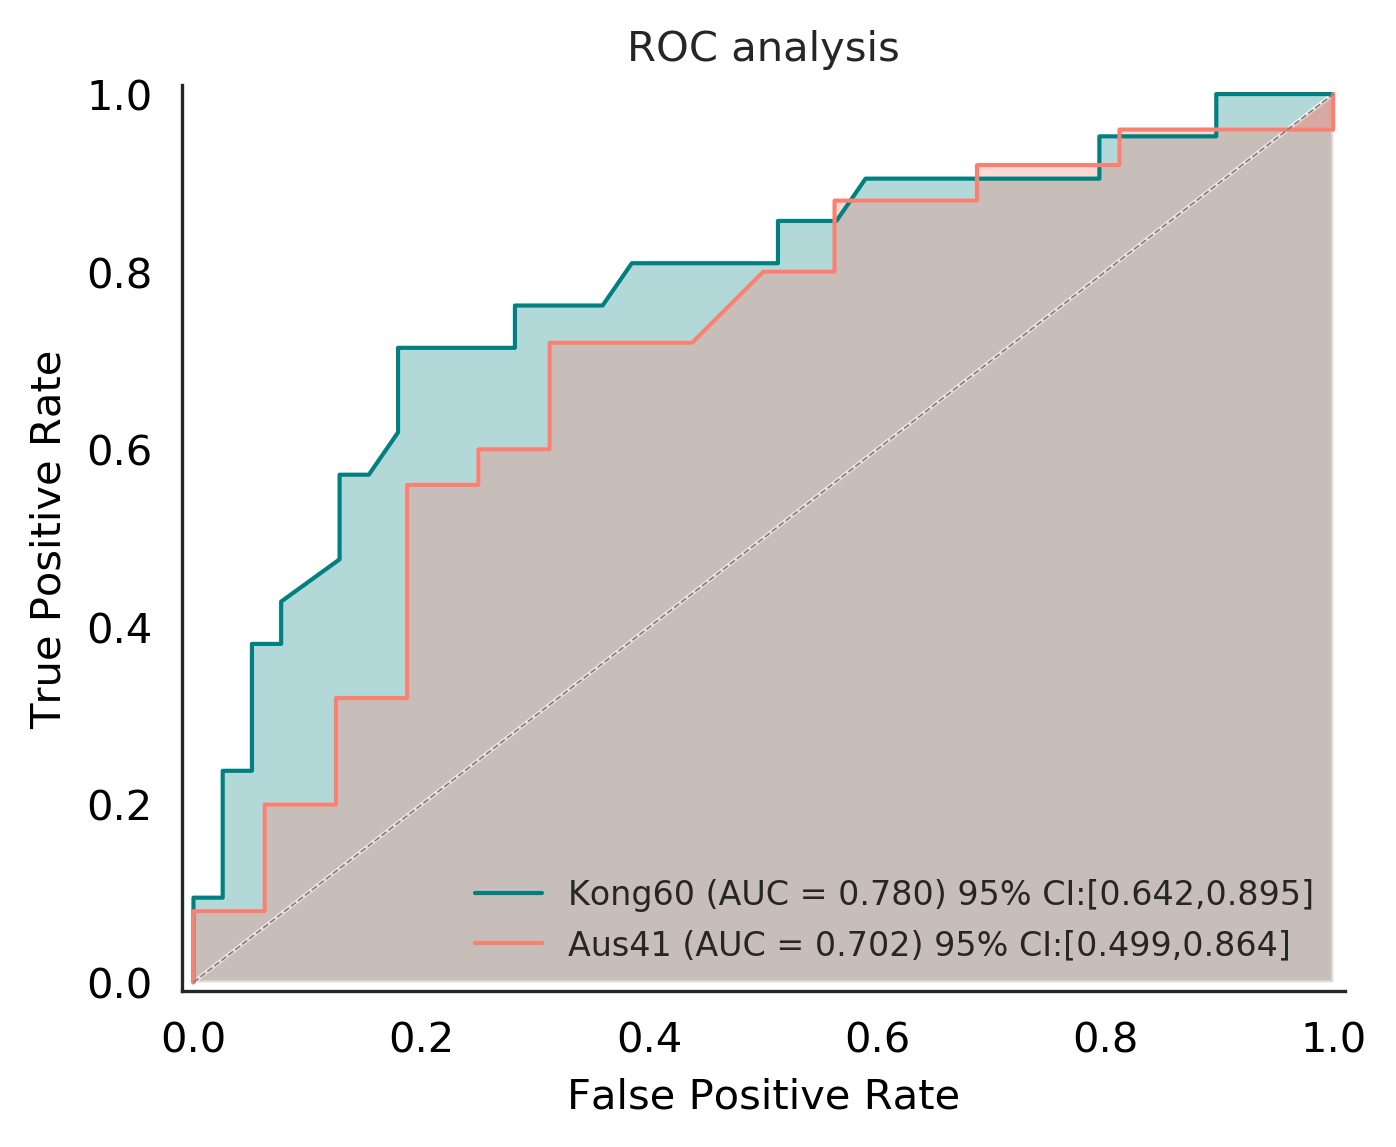

In [270]:
fig,ax = plt.subplots(figsize=(5,4),dpi=300)
colors=['teal','salmon']
linestypes=['-','-']
labels = ['Kong60','Aus41']
Pred = [Mela_pred[0],Mela_pred[1]]
CI=[Kong_AUC_CI,Aus_AUC_CI]
Blabels=[All_cli_update.loc[Mela_pred[0].index,"Blabel"],All_cli_update.loc[Mela_pred[1].index,"Blabel"]]
for p,b,lab,col,ls,ci in zip(Pred,Blabels,labels,colors,linestypes,CI):
    fpr,tpr,thresholds = roc_curve(y_true= b,y_score=p)
    roc_auc = auc(x=fpr,y=tpr)
    plt.plot(fpr,tpr,color=col,linestyle=ls,label='%s (AUC = %0.3f) 95%% CI:[%0.3f,%0.3f]'%(lab, roc_auc,ci[0],ci[1]),linewidth=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='lower right',fontsize=8,frameon=False)
    ax.fill(fpr,tpr, col, alpha=0.3)
    ax.fill([0,1,1],[0,1,0],col,alpha=0.3)
    
plt.plot([0,1],[0,1],linestyle='--',color='gray',linewidth=0.4)
plt.xlim([-0.01,1.01])
plt.xticks(fontsize=10,color='black')
plt.yticks(fontsize=10,color='black')
plt.ylim([-0.01,1.01])
 
plt.xlabel('False Positive Rate',fontsize=10,color='black')
plt.ylabel('True Positive Rate',fontsize=10,color='black')
plt.title('ROC analysis',fontsize=10)
plt.show()

## Choice 

In [275]:
def Lung_model_Pred(All_cli,All_exp_log2,GeneSet,TCGA_log2):
    
    Lung_train_index,Lung_test_index,train_y,test_y=train_test_split(All_cli[All_cli.DataSet.isin(["Wu1","Batch2"])].index,All_cli[All_cli.DataSet.isin(["Wu1","Batch2"])].Response,stratify=All_cli[All_cli.DataSet.isin(["Wu1","Batch2"])].Response,test_size=45,random_state=65209)
    
    skf = StratifiedKFold(n_splits=3,random_state=65209)
    skf_res=[]
    for t1,t2  in skf.split(Lung_train_index,All_cli.loc[Lung_train_index,"Response"]):
        skf_res.append(Lung_train_index[t1])
    
    Lung_split1_index,Lung_split2_index,Lung_split3_index=skf_res

    GAS_index=All_cli[All_cli.DataSet=="GAS"].index
    BMS_index=All_cli[All_cli.DataSet=="BMS"].index
    HUGO_index=All_cli[All_cli.DataSet=="HUGO"].index
    URO_index=All_cli[All_cli.DataSet=="URO"].index
    
    Pan_train_index=Lung_train_index.append(GAS_index).append(BMS_index).append(URO_index)
    NonLung_index=GAS_index.append(BMS_index).append(URO_index)
    
    test_res=pd.DataFrame()
    
    for gg in GeneSet:
    
        Cgeneset=set(Msigdb[gg])&set(All_exp_log2.columns)

        Cgeneset_Norm=All_exp_log2.loc[:,Cgeneset].T.apply(zscore).T.dropna(axis=1)
        Cgeneset=Cgeneset&set(Cgeneset_Norm.columns)

        CC=pd.concat([Cgeneset_Norm.loc[Lung_test_index,:].apply(lambda x:roc_auc_score(All_cli.loc[Lung_test_index,"Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[Lung_train_index,:].apply(lambda x:roc_auc_score(All_cli.loc[Lung_train_index,"Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[Lung_split1_index,:].apply(lambda x:roc_auc_score(All_cli.loc[Lung_split1_index,"Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[Lung_split2_index,:].apply(lambda x:roc_auc_score(All_cli.loc[Lung_split2_index,"Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[Lung_split3_index,:].apply(lambda x:roc_auc_score(All_cli.loc[Lung_split3_index,"Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[GAS_index,:].apply(lambda x:roc_auc_score(All_cli.loc[All_cli.DataSet=="GAS","Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[BMS_index,:].apply(lambda x:roc_auc_score(All_cli.loc[All_cli.DataSet=="BMS","Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[URO_index,:].apply(lambda x:roc_auc_score(All_cli.loc[All_cli.DataSet=="URO","Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[NonLung_index,:].apply(lambda x:roc_auc_score(All_cli.loc[NonLung_index,"Blabel"],x),axis=0),
                               ],
                               keys=["Test","Train","Split1","Split2","Split3","GAS","BMS","URO","Nonlung"],axis=1,sort=True)
            
        CC["auc_lung_min"]=CC.loc[:,["Train","Split1","Split2","Split3"]].min(axis=1)
        CC["auc_lung_max"]=CC.loc[:,["Train","Split1","Split2","Split3"]].max(axis=1)
        CC["auc_lung_cv"]=CC["auc_lung_max"]-CC["auc_lung_min"]
        CC["auc_lung_median"]=CC.loc[:,["Train","Split1","Split2","Split3"]].median(axis=1)
            
        CC["auc_nonlung_median"]=CC.loc[:,["Nonlung","URO","GAS","BMS"]].median(axis=1)
        CC["auc_nonlung_min"]=CC.loc[:,["Nonlung","URO","GAS","BMS"]].min(axis=1)
        CC["auc_nonlung_max"]=CC.loc[:,["Nonlung","URO","GAS","BMS"]].max(axis=1)
        CC["auc_nonlung_cv"]=CC["auc_nonlung_max"]-CC["auc_nonlung_min"]
        
        CTCGA=set(Msigdb[gg])&set(TCGA_log2.columns)
        CTCGA_Norm=TCGA_log2.loc[:,CTCGA].T.apply(zscore).T.dropna(axis=1)
        CTCGA=CTCGA&set(CTCGA_Norm.columns)
        
        
        #####Fix_f 
        Fix_f=(CC["auc_nonlung_min"].append(1-CC["auc_nonlung_max"])).sort_values(ascending=False).index.tolist()[:2]
        
        ######Lung_prefer_f
        Tmp=CC.sort_values("auc_lung_median",ascending=False).head(n=10)
        Tmp_up=Tmp[(Tmp.auc_lung_median>0.55)&(Tmp.auc_lung_min>0.45)&(Tmp.auc_lung_cv<0.15)&(Tmp.auc_nonlung_median>0.5)&(Tmp.auc_nonlung_cv<0.2)&(Tmp.auc_nonlung_min>0.45)].auc_lung_median

        Tmp=CC.sort_values("auc_lung_median").head(n=10)
        Tmp_down=Tmp[(Tmp.auc_lung_median<0.45)&(Tmp.auc_lung_max<0.55)&(Tmp.auc_lung_cv<0.15)&(Tmp.auc_nonlung_median<0.5)&(Tmp.auc_nonlung_cv<0.2)&(Tmp.auc_nonlung_max<0.55)].auc_lung_median
        
        ######Combo prefer_f
        F_select=set((Tmp_up.append(1-Tmp_down)).sort_values(ascending=False).index.tolist()[:5]+Fix_f)
       
        print(gg,F_select)
        if(len(F_select)!=0):
        
            Test_DScomb_res=pd.DataFrame()
            
            #####URO pred
            F_select_URO=(0.5-CC.loc[F_select,"URO"])*(0.5-CC.loc[F_select,"Train"])
            F_select_URO=F_select_URO[F_select_URO>=0].index
            if(len(F_select_URO)!=0):
                URO_model=LogisticRegressionCV(random_state=3,cv=3,max_iter=3000).fit(Cgeneset_Norm.loc[URO_index,F_select_URO],All_cli.loc[URO_index,"Blabel"])
                Test_DScomb_res["URO_model"]=URO_model.predict_proba(CTCGA_Norm.loc[:,F_select_URO])[:,1]
                
            #####BMS pred    
            F_select_BMS=(0.5-CC.loc[F_select,"BMS"])*(0.5-CC.loc[F_select,"Train"])
            F_select_BMS=F_select_BMS[F_select_BMS>=0].index

            if(len(F_select_BMS)!=0):
                BMS_model=LogisticRegressionCV(random_state=3,cv=3,max_iter=3000).fit(Cgeneset_Norm.loc[BMS_index,F_select_BMS],All_cli.loc[BMS_index,"Blabel"])
                Test_DScomb_res["BMS_model"]=BMS_model.predict_proba(CTCGA_Norm.loc[:,F_select_BMS])[:,1]
              
            #####GAS pred
            F_select_GAS=(0.5-CC.loc[F_select,"GAS"])*(0.5-CC.loc[F_select,"Train"])
            F_select_GAS=F_select_GAS[F_select_GAS>=0].index

            if(len(F_select_GAS)!=0):
                GAS_model=LogisticRegressionCV(random_state=3,cv=3,max_iter=3000).fit(Cgeneset_Norm.loc[GAS_index,F_select_GAS],All_cli.loc[GAS_index,"Blabel"])
                Test_DScomb_res["GAS_model"]=GAS_model.predict_proba(CTCGA_Norm.loc[:,F_select_GAS])[:,1]
            
            #####Lung pred
            Lung_model=LogisticRegressionCV(random_state=3,cv=3,max_iter=3000).fit(Cgeneset_Norm.loc[Lung_train_index,F_select],All_cli.loc[Lung_train_index,"Blabel"]) 
            Test_DScomb_res["Lung_model"]=Lung_model.predict_proba(CTCGA_Norm.loc[:,F_select])[:,1]
          
            test_res[gg]=Test_DScomb_res.rank().median(axis=1)
  
    test_res.index=CTCGA_Norm.index
    
    return(test_res)

In [277]:
wyl=pd.read_csv("../wyl_coding_tpm.csv",index_col=0).T
wyl_cli=pd.read_csv("../Cli/wyl_clinical_summary2.csv",sep="\t")

wyl_cli.index=wyl_cli.Sra
wyl_overlap=set(wyl_cli.index)&set(wyl.index)

wyl_log2=np.log2(wyl.loc[wyl_overlap,:]+1)
GeneSet=["ECM","Key","BIOCARTA_PTEN_PATHWAY","ZhouS","Macrophages_M2","KEGG_NON_SMALL_CELL_LUNG_CANCER"]
wyl_pred=Lung_model_Pred(All_cli,All_exp_log2,GeneSet,wyl_log2)

ECM {'ACAN', 'SULF1', 'MMP1'}
Key {'TNFRSF17', 'CCR5', 'PRF1', 'HLA-DPB1', 'IL6', 'CD276', 'CD8A'}
BIOCARTA_PTEN_PATHWAY {'PDPK1', 'PIK3CA'}
ZhouS {'PRF1', 'HIF1A', 'EOMES', 'BACH2', 'IL2RB'}
Macrophages_M2 {'IL6', 'CXCL9'}
KEGG_NON_SMALL_CELL_LUNG_CANCER {'NRAS', 'CCND1', 'ARAF', 'STK4', 'PDPK1'}


In [278]:
wyl_pred_res=wyl_pred.rank().mean(axis=1)
wyl_pred_rg=wyl_pred_res[wyl_pred_res>wyl_pred_res.quantile(0.5)].index
wyl_pred_nrg=wyl_pred_res[wyl_pred_res<wyl_pred_res.quantile(0.5)].index
wyl_group=pd.Series(["ResPred"]*len(wyl_pred_rg)+["NonResPred"]*len(wyl_pred_nrg),index=wyl_pred_rg.append(wyl_pred_nrg))
wyl_group.name="Group"

In [293]:
wyl_cli_surv=wyl_cli.loc[:,["os_event","os_time"]].join(wyl_group,how="inner")
wyl_cli_surv["os_event"]=wyl_cli_surv["os_event"].replace(["Yes","No"],[1,0])

wyl_cli_surv.loc[:,["os_time","os_event"]].to_csv("/amoydx/USER/yangshuang/PD-1/data/resplit/choice/wyl_cli.csv")

def survival_analysis(Survival,level,title):
    fig = plt.figure(figsize=(5,4),dpi=300)
    axis = plt.subplot(111)

    kmf1 = KaplanMeierFitter()
    kmf2 = KaplanMeierFitter()
    
    T = Survival.iloc[:,0]
    E = Survival.iloc[:,1]
    ix1 = (Survival.iloc[:,2] == level[0])
    ix2 = (Survival.iloc[:,2] == level[1])
    label1=level[0]
    label2=level[1]
    kmf1.fit(T[ix1], E[ix1], label=label1)
    ax = kmf1.plot(ax=axis, ci_show=False, show_censors=True,color="teal")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    kmf2.fit(T[ix2], E[ix2], label=label2)
    ax = kmf2.plot(ax=axis, ci_show=False, show_censors=True,color="salmon")
    add_at_risk_counts(kmf1, kmf2, ax=ax,labels=None)
    
    #ax.set_xlim([0,40])
    
    result = logrank_test(T[ix1],T[ix2], event_observed_A= E[ix1], event_observed_B=E[ix2])
    result.print_summary()##log_rank test

    plt.text(2000, .75, 'p={:.3e}'.format(result.p_value))
    plt.show()

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
 test_statistic    p  -log2(p)
           0.93 0.33      1.58


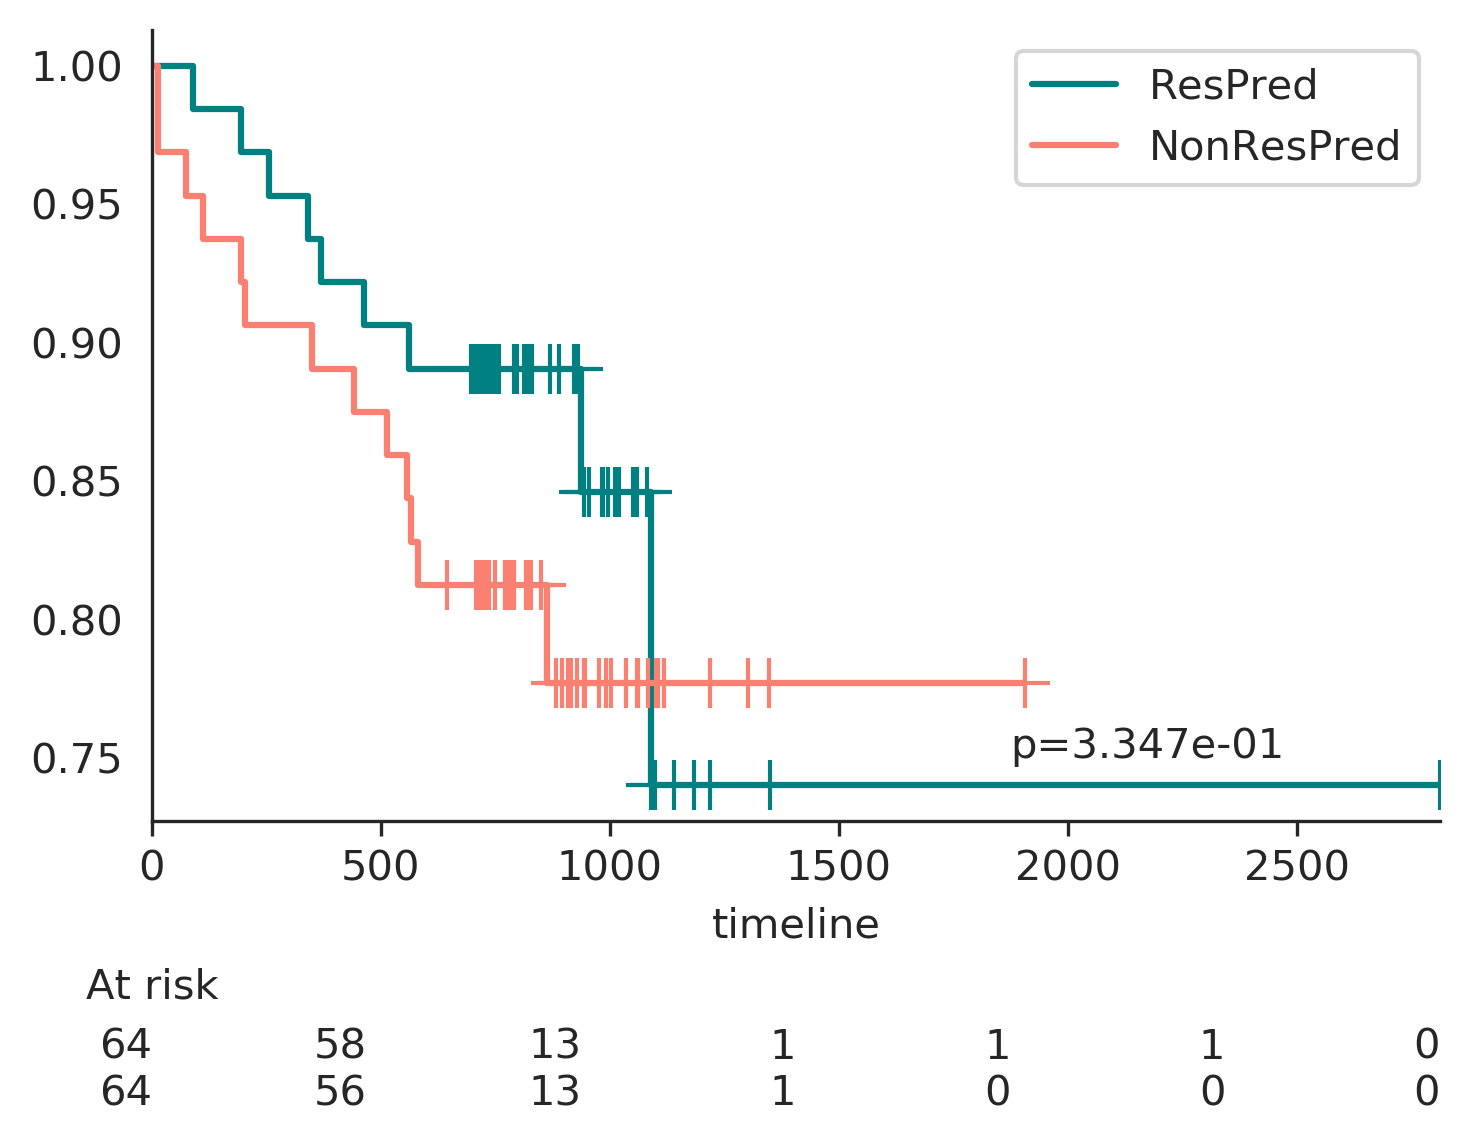

In [294]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts
survival_analysis(wyl_cli_surv.loc[:,["os_time","os_event","Group"]],["ResPred","NonResPred"],"IO_score")

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
 test_statistic    p  -log2(p)
           4.75 0.03      5.09


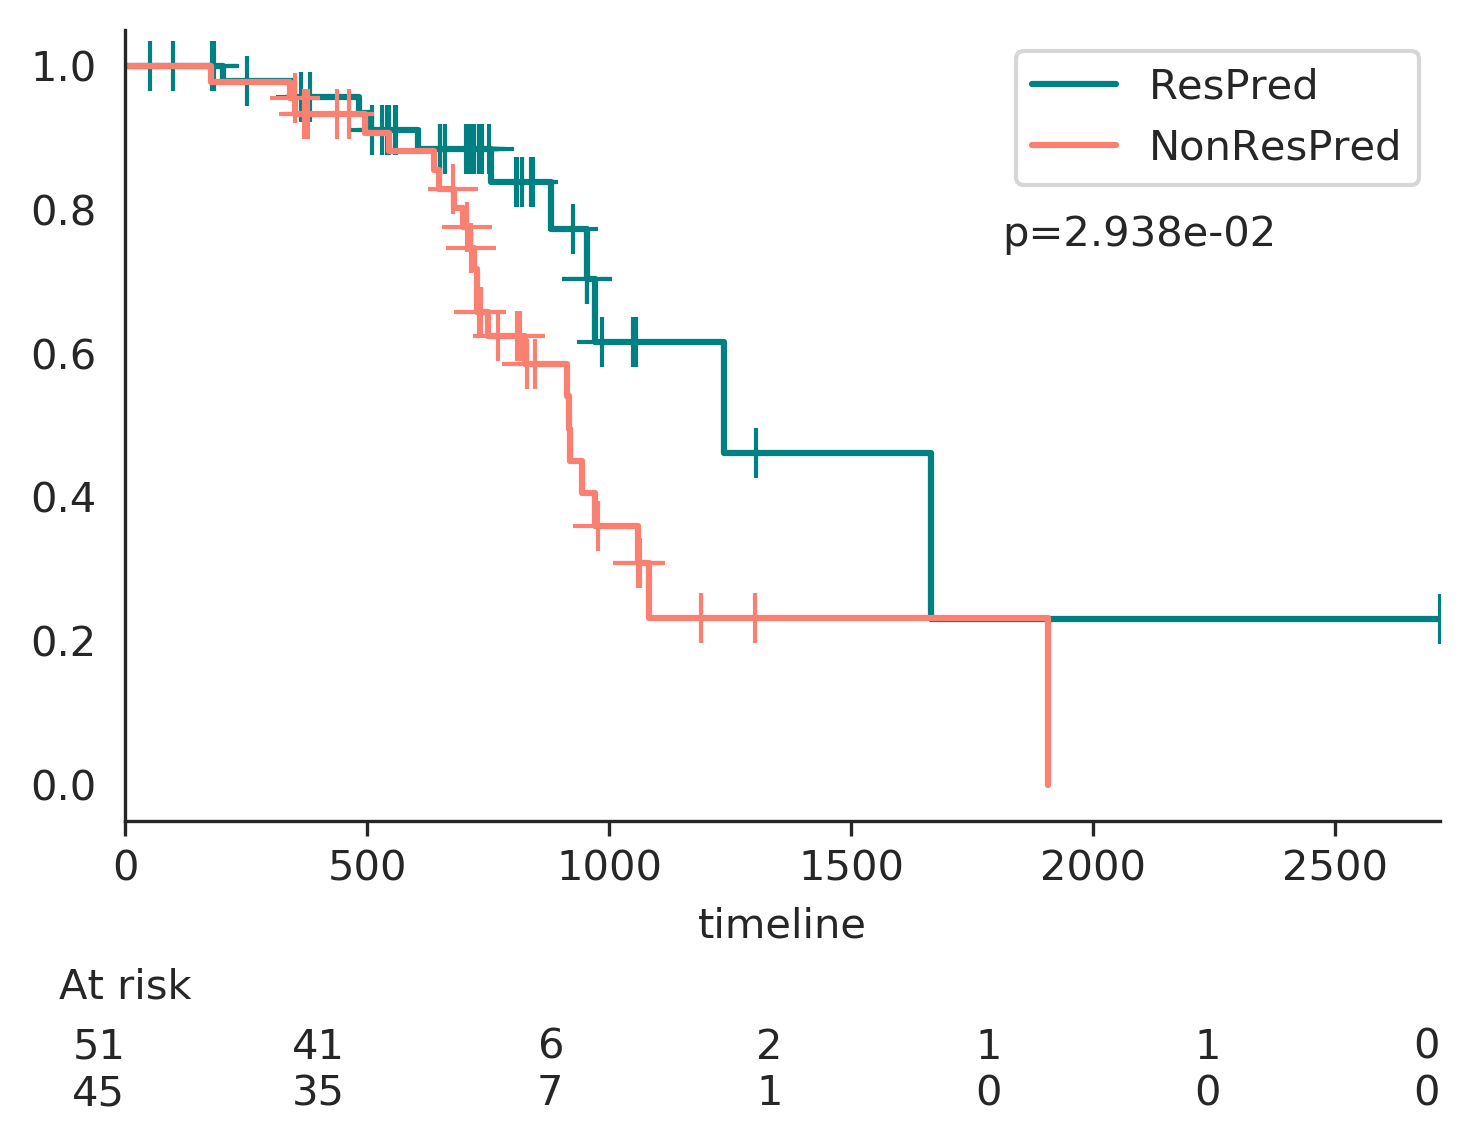

In [295]:
wyl_cli_surv.to_csv("/amoydx/USER/yangshuang/PD-1/data/resplit2/Choice_os.csv")
wyl_cli_surv2=wyl_cli.loc[:,["pfs_event","pfs_time"]].join(wyl_group,how="inner")
wyl_cli_surv2=wyl_cli_surv2[~wyl_cli_surv2.isnull().any(axis=1)]

survival_analysis(wyl_cli_surv2.loc[:,["pfs_time","pfs_event","Group"]],["ResPred","NonResPred"],"IO_score")

## TCGA

In [351]:
TCGA_exp=pd.read_table("/amoydx/USER/yangshuang/PD-1/TCGA_mRNA_Data.tsv",index_col=0)
TCGA_exp=TCGA_exp.groupby("gene_name").mean()

TCGA_cli=pd.read_table("/amoydx/USER/yangshuang/PD-1/data/resplit/TCGA_clinical.tsv",index_col=0)
TCGA_lung=TCGA_cli[TCGA_cli.tissue_or_organ_of_origin.str.contains("lung")]
TCGA_lung["days_during"]=TCGA_lung.loc[:,["days_to_death","days_to_last_follow_up"]].max(axis=1)
TCGA_lung["status"]=TCGA_lung.vital_status.replace(["Dead","Alive"],[1,0])
TCGA_lung=TCGA_lung.loc[TCGA_lung.days_during.dropna().index,:]

#TCGA_Lung_use=set(TCGA_lung.index)&set(["-".join(x.split("-")[:3]) for x in TCGA_exp.loc[:,TCGA_exp.columns.str.contains("-01A-")].columns])
TCGA_Lung_use=TCGA_exp.loc[:,TCGA_exp.columns.str.contains("-01A-")].columns[pd.Series(["-".join(x.split("-")[:3]) for x in TCGA_exp.loc[:,TCGA_exp.columns.str.contains("-01A-")].columns]).isin(TCGA_lung.index)]
#TCGA_Lung_Norm_use=TCGA_exp.loc[:,TCGA_exp.columns.str.contains("-11A-")].columns[pd.Series(["-".join(x.split("-")[:3]) for x in TCGA_exp.loc[:,TCGA_exp.columns.str.contains("-11A-")].columns]).isin(TCGA_lung.index)]

/amoydx/USER/yangshuang/software/anaconda2/envs/tf_gpu/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/amoydx/USER/yangshuang/software/anaconda2/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/amoydx/USER/yangshuang/software/anaconda2/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

In [350]:
def Lung_model_Pred(All_cli,All_exp_log2,GeneSet,TCGA_log2):
    
    Lung_train_index,Lung_test_index,train_y,test_y=train_test_split(All_cli[All_cli.DataSet.isin(["Wu1","Batch2"])].index,All_cli[All_cli.DataSet.isin(["Wu1","Batch2"])].Response,stratify=All_cli[All_cli.DataSet.isin(["Wu1","Batch2"])].Response,test_size=45,random_state=65209)
    
    skf = StratifiedKFold(n_splits=3,random_state=65209)
    skf_res=[]
    for t1,t2  in skf.split(Lung_train_index,All_cli.loc[Lung_train_index,"Response"]):
        skf_res.append(Lung_train_index[t1])
    
    Lung_split1_index,Lung_split2_index,Lung_split3_index=skf_res

    GAS_index=All_cli[All_cli.DataSet=="GAS"].index
    BMS_index=All_cli[All_cli.DataSet=="BMS"].index
    HUGO_index=All_cli[All_cli.DataSet=="HUGO"].index
    URO_index=All_cli[All_cli.DataSet=="URO"].index
    
    Pan_train_index=Lung_train_index.append(GAS_index).append(BMS_index).append(URO_index)
    NonLung_index=GAS_index.append(BMS_index).append(URO_index)
    
    test_res=pd.DataFrame()
    
    for gg in GeneSet:
    
        Cgeneset=set(Msigdb[gg])&set(All_exp_log2.columns)

        Cgeneset_Norm=All_exp_log2.loc[:,Cgeneset].T.apply(zscore).T.dropna(axis=1)
        Cgeneset=Cgeneset&set(Cgeneset_Norm.columns)

        CC=pd.concat([Cgeneset_Norm.loc[Lung_test_index,:].apply(lambda x:roc_auc_score(All_cli.loc[Lung_test_index,"Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[Lung_train_index,:].apply(lambda x:roc_auc_score(All_cli.loc[Lung_train_index,"Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[Lung_split1_index,:].apply(lambda x:roc_auc_score(All_cli.loc[Lung_split1_index,"Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[Lung_split2_index,:].apply(lambda x:roc_auc_score(All_cli.loc[Lung_split2_index,"Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[Lung_split3_index,:].apply(lambda x:roc_auc_score(All_cli.loc[Lung_split3_index,"Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[GAS_index,:].apply(lambda x:roc_auc_score(All_cli.loc[All_cli.DataSet=="GAS","Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[BMS_index,:].apply(lambda x:roc_auc_score(All_cli.loc[All_cli.DataSet=="BMS","Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[URO_index,:].apply(lambda x:roc_auc_score(All_cli.loc[All_cli.DataSet=="URO","Blabel"],x),axis=0),
                               Cgeneset_Norm.loc[NonLung_index,:].apply(lambda x:roc_auc_score(All_cli.loc[NonLung_index,"Blabel"],x),axis=0),
                               ],
                               keys=["Test","Train","Split1","Split2","Split3","GAS","BMS","URO","Nonlung"],axis=1,sort=True)
            
        CC["auc_lung_min"]=CC.loc[:,["Train","Split1","Split2","Split3"]].min(axis=1)
        CC["auc_lung_max"]=CC.loc[:,["Train","Split1","Split2","Split3"]].max(axis=1)
        CC["auc_lung_cv"]=CC["auc_lung_max"]-CC["auc_lung_min"]
        CC["auc_lung_median"]=CC.loc[:,["Train","Split1","Split2","Split3"]].median(axis=1)
            
        CC["auc_nonlung_median"]=CC.loc[:,["Nonlung","URO","GAS","BMS"]].median(axis=1)
        CC["auc_nonlung_min"]=CC.loc[:,["Nonlung","URO","GAS","BMS"]].min(axis=1)
        CC["auc_nonlung_max"]=CC.loc[:,["Nonlung","URO","GAS","BMS"]].max(axis=1)
        CC["auc_nonlung_cv"]=CC["auc_nonlung_max"]-CC["auc_nonlung_min"]
        
        CTCGA=set(Msigdb[gg])&set(TCGA_log2.columns)
        CTCGA_Norm=TCGA_log2.loc[:,CTCGA].T.apply(zscore).T.dropna(axis=1)
        CTCGA=CTCGA&set(CTCGA_Norm.columns)
        
        
        #####Fix_f 
        Fix_f=(CC["auc_nonlung_min"].append(1-CC["auc_nonlung_max"])).sort_values(ascending=False).index.tolist()[:2]
        
        ######Lung_prefer_f
        Tmp=CC.sort_values("auc_lung_median",ascending=False).head(n=10)
        Tmp_up=Tmp[(Tmp.auc_lung_median>0.55)&(Tmp.auc_lung_min>0.45)&(Tmp.auc_lung_cv<0.15)&(Tmp.auc_nonlung_median>0.5)&(Tmp.auc_nonlung_cv<0.2)&(Tmp.auc_nonlung_min>0.45)].auc_lung_median

        Tmp=CC.sort_values("auc_lung_median").head(n=10)
        Tmp_down=Tmp[(Tmp.auc_lung_median<0.45)&(Tmp.auc_lung_max<0.55)&(Tmp.auc_lung_cv<0.15)&(Tmp.auc_nonlung_median<0.5)&(Tmp.auc_nonlung_cv<0.2)&(Tmp.auc_nonlung_max<0.55)].auc_lung_median
        
        ######Combo prefer_f
        F_select=set((Tmp_up.append(1-Tmp_down)).sort_values(ascending=False).index.tolist()[:5]+Fix_f)
       
        print(gg,F_select)
        if(len(F_select)!=0):
        
            Test_DScomb_res=pd.DataFrame()
            
            #####URO pred
            F_select_URO=(0.5-CC.loc[F_select,"URO"])*(0.5-CC.loc[F_select,"Train"])
            F_select_URO=F_select_URO[F_select_URO>=0].index
            if(len(F_select_URO)!=0):
                URO_model=LogisticRegressionCV(random_state=3,cv=3,max_iter=3000).fit(Cgeneset_Norm.loc[URO_index,F_select_URO],All_cli.loc[URO_index,"Blabel"])
                Test_DScomb_res["URO_model"]=URO_model.predict_proba(CTCGA_Norm.loc[:,F_select_URO])[:,1]
                
            #####BMS pred    
            F_select_BMS=(0.5-CC.loc[F_select,"BMS"])*(0.5-CC.loc[F_select,"Train"])
            F_select_BMS=F_select_BMS[F_select_BMS>=0].index

            if(len(F_select_BMS)!=0):
                BMS_model=LogisticRegressionCV(random_state=3,cv=3,max_iter=3000).fit(Cgeneset_Norm.loc[BMS_index,F_select_BMS],All_cli.loc[BMS_index,"Blabel"])
                Test_DScomb_res["BMS_model"]=BMS_model.predict_proba(CTCGA_Norm.loc[:,F_select_BMS])[:,1]
              
            #####GAS pred
            F_select_GAS=(0.5-CC.loc[F_select,"GAS"])*(0.5-CC.loc[F_select,"Train"])
            F_select_GAS=F_select_GAS[F_select_GAS>=0].index

            if(len(F_select_GAS)!=0):
                GAS_model=LogisticRegressionCV(random_state=3,cv=3,max_iter=3000).fit(Cgeneset_Norm.loc[GAS_index,F_select_GAS],All_cli.loc[GAS_index,"Blabel"])
                Test_DScomb_res["GAS_model"]=GAS_model.predict_proba(CTCGA_Norm.loc[:,F_select_GAS])[:,1]
            
            #####Lung pred
            Lung_model=LogisticRegressionCV(random_state=3,cv=3,max_iter=3000).fit(Cgeneset_Norm.loc[Lung_train_index,F_select],All_cli.loc[Lung_train_index,"Blabel"]) 
            Test_DScomb_res["Lung_model"]=Lung_model.predict_proba(CTCGA_Norm.loc[:,F_select])[:,1]
          
            test_res[gg]=Test_DScomb_res.rank().median(axis=1)
  
    test_res.index=CTCGA_Norm.index
    
    return(test_res)

In [390]:
TCGA_Lung_use_exp_log2=np.log2(TCGA_exp.loc[:,TCGA_Lung_use]+1).T
TCGA_Lung_use_exp_log2.index=["-".join(x.split("-")[:3]) for x in TCGA_Lung_use_exp_log2.index]
TCGA_Lung_use_exp_log2=TCGA_Lung_use_exp_log2[~TCGA_Lung_use_exp_log2.index.duplicated()]
TCGA_pred=Lung_model_Pred(All_cli,All_exp_log2,GeneSet,TCGA_Lung_use_exp_log2)

ECM {'ACAN', 'SULF1', 'MMP1'}
Key {'TNFRSF17', 'CCR5', 'PRF1', 'HLA-DPB1', 'IL6', 'CD276', 'CD8A'}
BIOCARTA_PTEN_PATHWAY {'PDPK1', 'PIK3CA'}
ZhouS {'PRF1', 'HIF1A', 'EOMES', 'BACH2', 'IL2RB'}
Macrophages_M2 {'IL6', 'CXCL9'}
KEGG_NON_SMALL_CELL_LUNG_CANCER {'NRAS', 'CCND1', 'ARAF', 'STK4', 'PDPK1'}


In [391]:
TCGA_pred_res=TCGA_pred.rank().mean(axis=1)
TCGA_pred_rg=TCGA_pred_res[TCGA_pred_res>TCGA_pred_res.quantile(0.5)].index
TCGA_pred_nrg=TCGA_pred_res[TCGA_pred_res<TCGA_pred_res.quantile(0.5)].index
TCGA_group=pd.Series(["ResPred"]*len(TCGA_pred_rg)+["NonResPred"]*len(TCGA_pred_nrg),index=TCGA_pred_rg.append(TCGA_pred_nrg))
TCGA_group.name="Group"

/amoydx/USER/yangshuang/software/anaconda2/envs/tf_gpu/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:652: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)


<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
 test_statistic    p  -log2(p)
           0.57 0.45      1.15


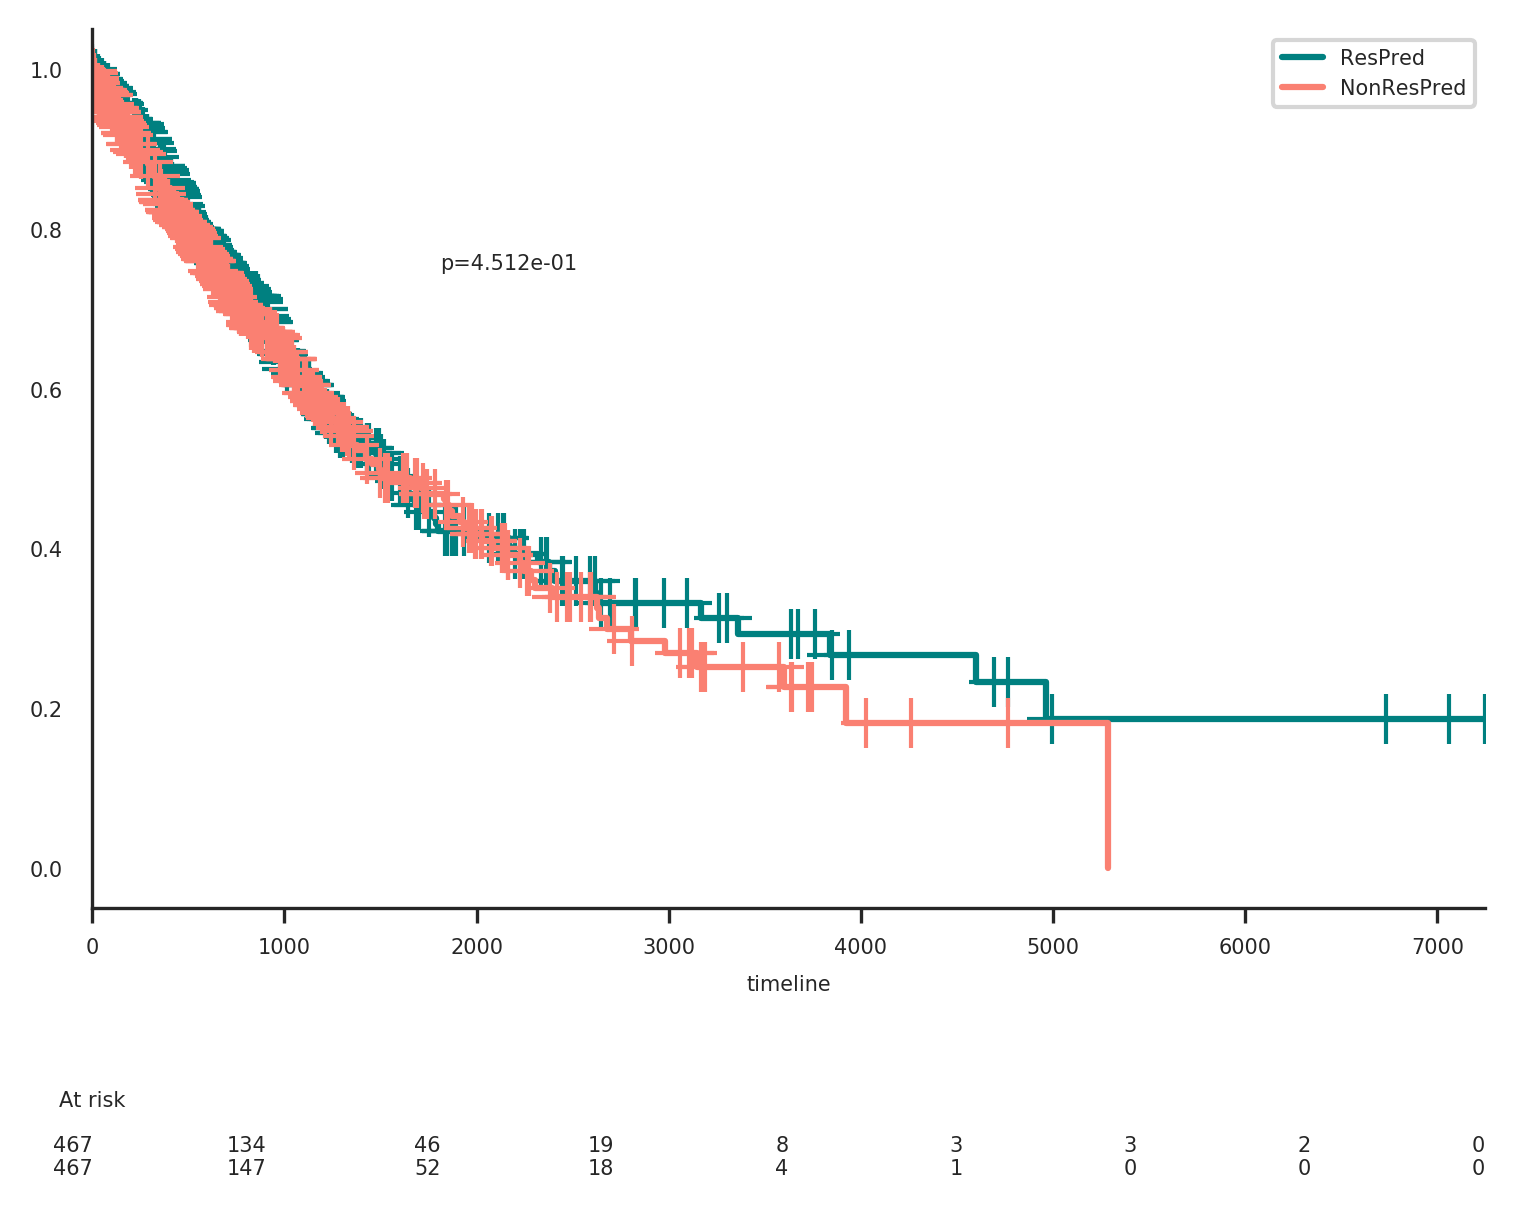

In [392]:
TCGA_pred_surv=TCGA_lung.loc[TCGA_group.index,["status","days_during"]]
TCGA_pred_surv=TCGA_pred_surv.join(TCGA_group)
survival_analysis(TCGA_pred_surv.loc[:,["days_during","status","Group"]],["ResPred","NonResPred"],"IO_score")

In [397]:
TCGA_pred_surv.to_csv("/amoydx/USER/yangshuang/PD-1/data/resplit/TCGA/TCGA_pred.csv")

In [395]:
TCGA_pred_surv.head()

,status,days_during,Group
TCGA-86-6851,0,179.0,ResPred
TCGA-86-6562,1,376.0,ResPred
TCGA-66-2763,0,30.0,ResPred
TCGA-50-6597,1,1268.0,ResPred
TCGA-53-A4EZ,0,1071.0,ResPred
